## Outline
* Simple exploratory data analysis
* Idea is to automate some parts of EDA, xcript is a work in progress

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_train = pd.read_csv('train/train.csv')

In [71]:
#high level summary of the data frame
def describe_data_frame(df):
    print("Number of rows: " + str(len(df)))
    print("Number of columns: " + str(len(df.columns)))
    
    numeric_count = 0
    na_count = 0
    for i in df.columns:
        if np.issubdtype(df[i].dtype, np.number):
            numeric_count += 1
        if df[i].isnull().values.any():
            na_count += 1
    print("Number of numeric columns: {}".format(numeric_count))
    print("Number of columns with a NA value: {}".format(na_count))
    
#display correlation
def display_corr(df):
    if len(df.columns) <= 100:
        pd.scatter_matrix(df, alpha=0.2, figsize=(6, 6), diagonal='kde')
        print(df.corr())
    else:
        #df too big, do it in sequence
        df_temp = df.corr()
        for i in df_temp.columns:
            #df_train.reindex(df_train.id.abs().sort_index(inplace=False,ascending=False).index)['id'][0:10]
            print("\n " + str(i))
            df_temp2 = pd.DataFrame({i:df_temp[i],'zz_abs':df_temp[i].abs()})
            print(df_temp2.sort_values(['zz_abs'],ascending=False)[i][1:11])

In [72]:
display_corr(df_train)


 id
price_doc                     0.121203
state                        -0.119621
incineration_km               0.104625
church_synagogue_km           0.103232
hospice_morgue_km             0.102406
cafe_sum_500_max_price_avg    0.102267
cafe_avg_price_500            0.099725
cafe_sum_500_min_price_avg    0.095040
school_km                     0.091893
preschool_km                  0.091805
Name: id, dtype: float64

 full_sq
num_room                0.695444
price_doc               0.341840
life_sq                 0.161112
max_floor               0.119225
state                  -0.091348
floor                   0.089649
public_healthcare_km    0.062565
build_count_block      -0.062357
oil_chemistry_km        0.060496
railroad_km             0.059345
Name: full_sq, dtype: float64

 life_sq
num_room                       0.191024
price_doc                      0.165606
full_sq                        0.161112
build_count_block             -0.109769
build_count_panel             -0.093463


In [8]:
describe_data_frame(df_train)

Number of rows: 30471
Number of columns: 292
Number of numeric columns: 276
Number of columns with a NA value: 51


In [78]:
#describes features:
#summary of data (mean, max, min, 25%, 75%, std, data type)
#is any NaN and if so what %
#histogram for numerical data
#violin plot vs. target variable for categorical
#level analysis for categorical


def describe_features(df,target_column,is_target_categorical):
    for i in df.columns:
        print('\n' + i + ' -- Feature ')
        details = ''
        
        if df[i].isnull().values.any():
            zFloat = len(df[df[i].isnull().values])/len(df[i]) 
            details += " | NaN " + str(np.round(zFloat,2))
        
        is_numeric = np.issubdtype(df[i].dtype, np.number)
        if is_numeric:
            z1 = 0
            if np.mean(df[i]) < 100:
                z1 = 2
            temp_describe = df[i].describe()
            print(np.round(temp_describe,z1))
            #print(df[i].describe())
            details += " | is numeric"
            
            #plot histogram
            temp_max = temp_describe['max']
            range_min = temp_describe['25%'] - temp_describe['std']*3
            range_max = temp_describe['75%'] + temp_describe['std']*3
            if range_min < temp_describe['min']:
                range_min = temp_describe['min']
            if range_max > temp_describe['max']:
                range_max = temp_describe['max']
            print(range_min, range_max)
            with np.errstate(invalid='ignore'):
                n, bins, patches = plt.hist(df[i], 25, range=[range_min,range_max])
                plt.show()
        else:
            #print(False)
            details += " | is not numeric"
        
        unique_values = len( df[i].unique() ) 
        details += " | " + str(unique_values) + " unique values "
        if unique_values < 100 or unique_values < len(df[i])/20:
            if is_numeric:
                details += " | consider one-hot? (ordinal?) "
            else:
                details += " | consider one-hot?"
                
        print(details)   
        
        if unique_values <= 20 and target_column != '':
            if is_target_categorical:
                print('TEST: Do targets by level')
                df.fillna('NaN').groupby([i,target_column]).agg({i:'count'})
                #df_raw.groupby(['created_month', 'interest_level']).agg({'created_month': 'count'})
            else:
                print( 'Levels | Count | Mean | Median | std')
                g0 = df.fillna('NaN').groupby([i]).agg({target_column:'count'})
                g1 = df.fillna('NaN').groupby([i]).agg({target_column:'mean'})
                g2 = df.fillna('NaN').groupby([i]).agg({target_column:'median'})
                g3 = df.fillna('NaN').groupby([i]).agg({target_column:'std'})
                result = pd.concat([g0, g1, g2, g3], axis=1, join_axes=[g0.index])
                print(result)
                
            #do violin plot
            plt.figure(figsize=(8,6))
            sns.violinplot(x=i, y=target_column, data=df)
            plt.show()
        


id -- Feature 
count    30471.0
mean     15238.0
std       8797.0
min          1.0
25%       7620.0
50%      15238.0
75%      22856.0
max      30473.0
Name: id, dtype: float64
1.0 30473.0


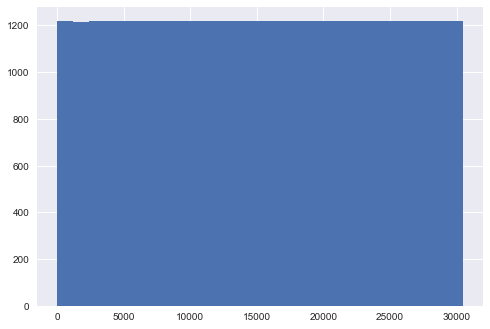

 | is numeric | 30471 unique values 

timestamp -- Feature 
 | is not numeric | 1161 unique values  | consider one-hot?

full_sq -- Feature 
count    30471.00
mean        54.21
std         38.03
min          0.00
25%         38.00
50%         49.00
75%         63.00
max       5326.00
Name: full_sq, dtype: float64
0.0 177.094461972


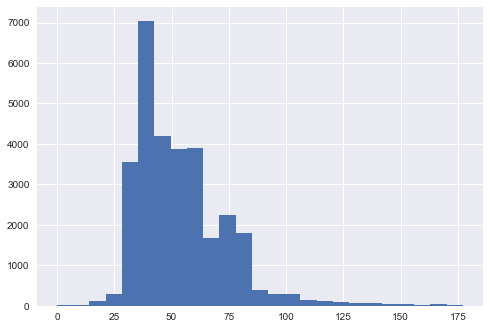

 | is numeric | 211 unique values  | consider one-hot? (ordinal?) 

life_sq -- Feature 
count    24088.00
mean        34.40
std         52.29
min          0.00
25%         20.00
50%         30.00
75%         43.00
max       7478.00
Name: life_sq, dtype: float64
0.0 199.857200428


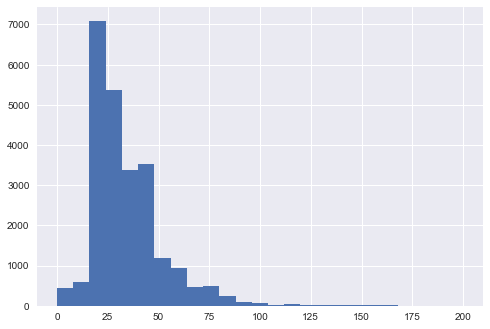

 | NaN 0.21 | is numeric | 176 unique values  | consider one-hot? (ordinal?) 

floor -- Feature 
count    30304.00
mean         7.67
std          5.32
min          0.00
25%          3.00
50%          6.50
75%         11.00
max         77.00
Name: floor, dtype: float64
0.0 26.9599655628


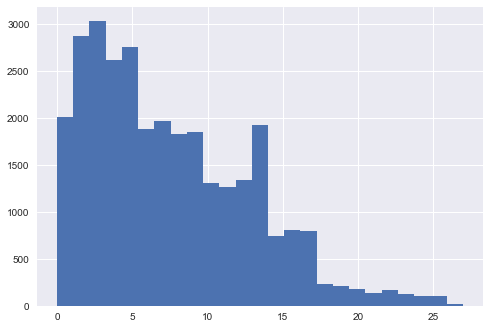

 | NaN 0.01 | is numeric | 42 unique values  | consider one-hot? (ordinal?) 

max_floor -- Feature 
count    20899.00
mean        12.56
std          6.76
min          0.00
25%          9.00
50%         12.00
75%         17.00
max        117.00
Name: max_floor, dtype: float64
0.0 37.2696514573


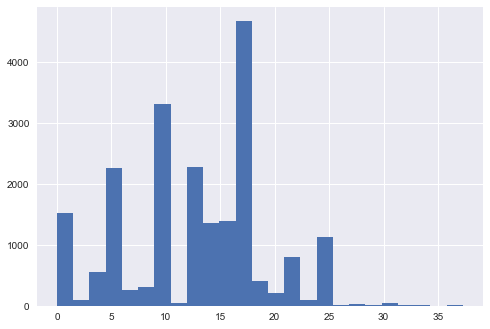

 | NaN 0.31 | is numeric | 50 unique values  | consider one-hot? (ordinal?) 

material -- Feature 
count    20899.00
mean         1.83
std          1.48
min          1.00
25%          1.00
50%          1.00
75%          2.00
max          6.00
Name: material, dtype: float64
1.0 6.0


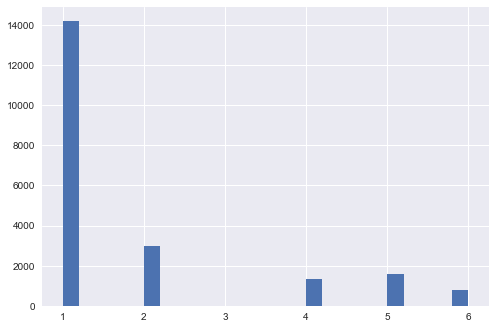

 | NaN 0.31 | is numeric | 7 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
          price_doc  price_doc  price_doc     price_doc
material                                               
1.0           14197    7088091    6500000  3.804656e+06
2.0            2993    8421236    6900000  6.076741e+06
3.0               1    6931143    6931143           NaN
4.0            1344   10183408    7247869  9.460111e+06
5.0            1561    6483121    6492000  2.879190e+06
6.0             803    7979828    6362318  6.787506e+06
NaN            9572    6371732    5650000  4.407112e+06


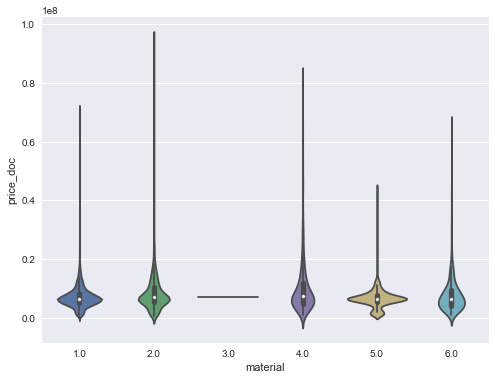


build_year -- Feature 
count       16866.0
mean         3068.0
std        154388.0
min             0.0
25%          1967.0
50%          1979.0
75%          2005.0
max      20052009.0
Name: build_year, dtype: float64
0.0 465168.38691


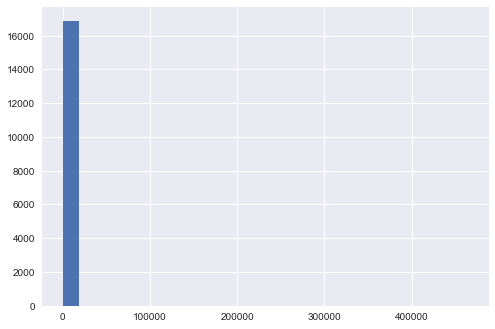

 | NaN 0.45 | is numeric | 120 unique values  | consider one-hot? (ordinal?) 

num_room -- Feature 
count    20899.00
mean         1.91
std          0.85
min          0.00
25%          1.00
50%          2.00
75%          2.00
max         19.00
Name: num_room, dtype: float64
0.0 4.5554135254


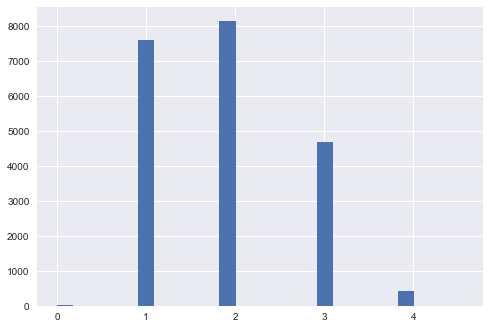

 | NaN 0.31 | is numeric | 14 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
          price_doc  price_doc  price_doc     price_doc
num_room                                               
0.0              14    7927055    7590001  5.117630e+06
1.0            7602    5330566    5250000  2.599334e+06
2.0            8132    7205595    6824493  3.298926e+06
3.0            4675   10269687    9205505  5.626292e+06
4.0             418   17903708   14400000  1.242838e+07
5.0              40   20458307   16850000  1.390973e+07
6.0               9   28676992   23000000  2.153429e+07
7.0               1   25500000   25500000           NaN
8.0               3   33855866   35000000  9.070482e+06
9.0               1   95122496   95122496           NaN
10.0              2    8500000    8500000  3.535534e+06
17.0              1   13150000   13150000           NaN
19.0              1    2630000    2630000           NaN
NaN            9572    6371732    5650000  4.4

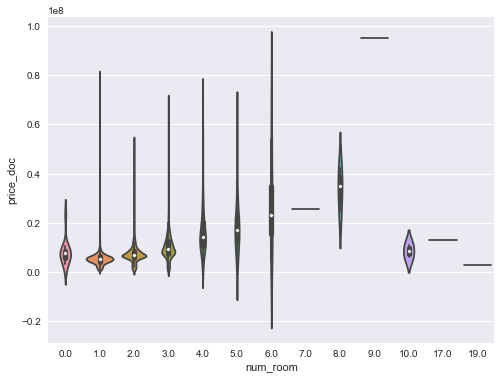


kitch_sq -- Feature 
count    20899.00
mean         6.40
std         28.27
min          0.00
25%          1.00
50%          6.00
75%          9.00
max       2014.00
Name: kitch_sq, dtype: float64
0.0 93.7979379457


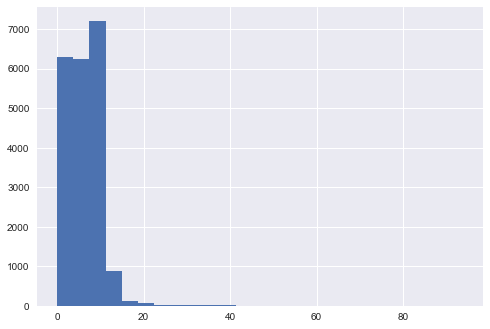

 | NaN 0.31 | is numeric | 75 unique values  | consider one-hot? (ordinal?) 

state -- Feature 
count    16912.00
mean         2.11
std          0.88
min          1.00
25%          1.00
50%          2.00
75%          3.00
max         33.00
Name: state, dtype: float64
1.0 5.64044417435


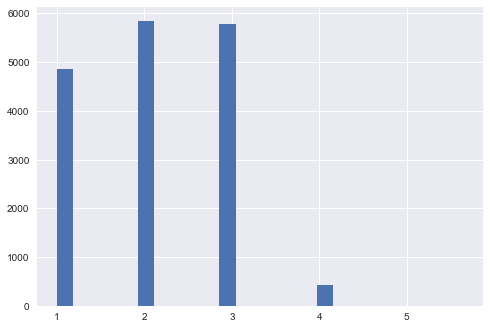

 | NaN 0.44 | is numeric | 6 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
       price_doc  price_doc  price_doc     price_doc
state                                               
1.0         4855    7315439    6156040  5.115678e+06
2.0         5844    7060064    6650000  3.700767e+06
3.0         5790    8078315    7250000  4.903700e+06
4.0          422   13345468   10060000  1.133675e+07
33.0           1    9000000    9000000           NaN
NaN        13559    6479555    5745850  4.449434e+06


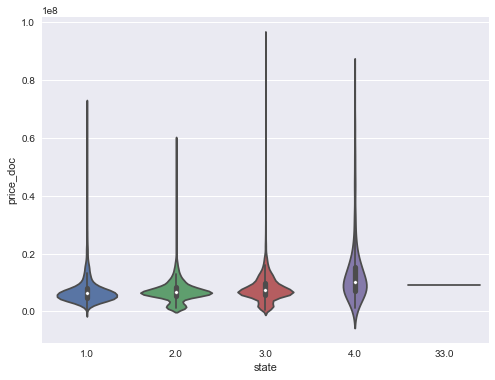


product_type -- Feature 
 | is not numeric | 2 unique values  | consider one-hot?
Levels | Count | Mean | Median | std
               price_doc  price_doc  price_doc     price_doc
product_type                                                
Investment         19448    7495294    6670000  5.054911e+06
OwnerOccupier      11023    6466254    5564090  4.172181e+06


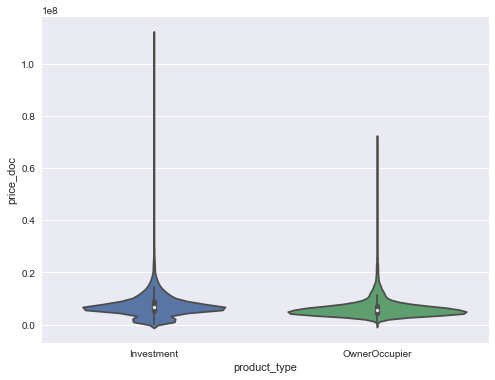


sub_area -- Feature 
 | is not numeric | 146 unique values  | consider one-hot?

area_m -- Feature 
count        30471.0
mean      17657051.0
std       20649608.0
min        2081628.0
25%        7307411.0
50%       10508030.0
75%       18036437.0
max      206071809.0
Name: area_m, dtype: float64
2081627.761 79985260.4801


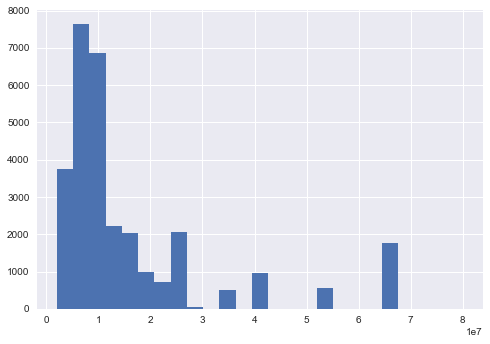

 | is numeric | 146 unique values  | consider one-hot? (ordinal?) 

raion_popul -- Feature 
count     30471.0
mean      84056.0
std       57871.0
min        2546.0
25%       21819.0
50%       83502.0
75%      122862.0
max      247469.0
Name: raion_popul, dtype: float64
2546.0 247469.0


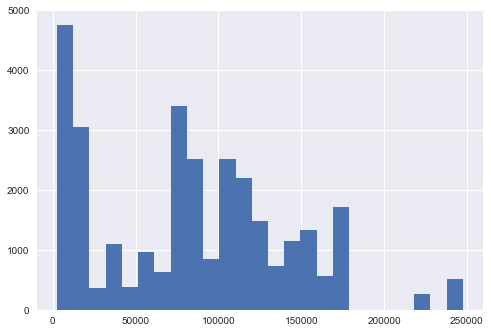

 | is numeric | 146 unique values  | consider one-hot? (ordinal?) 

green_zone_part -- Feature 
count    30471.00
mean         0.22
std          0.18
min          0.00
25%          0.06
50%          0.17
75%          0.34
max          0.85
Name: green_zone_part, dtype: float64
0.001879375 0.852922841


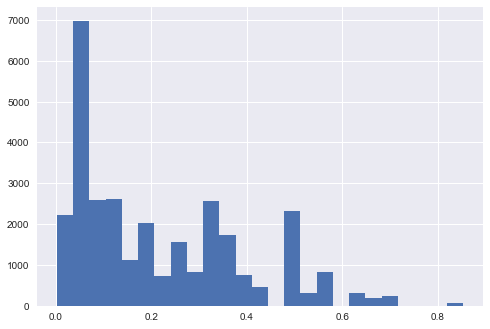

 | is numeric | 146 unique values  | consider one-hot? (ordinal?) 

indust_part -- Feature 
count    30471.00
mean         0.12
std          0.12
min          0.00
25%          0.02
50%          0.07
75%          0.20
max          0.52
Name: indust_part, dtype: float64
0.0 0.521867054


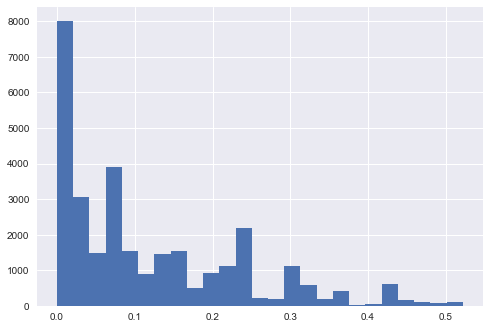

 | is numeric | 132 unique values  | consider one-hot? (ordinal?) 

children_preschool -- Feature 
count    30471.0
mean      5140.0
std       3817.0
min        175.0
25%       1706.0
50%       4857.0
75%       7103.0
max      19223.0
Name: children_preschool, dtype: float64
175.0 18552.8754201


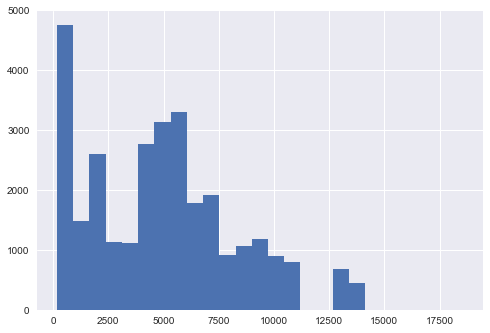

 | is numeric | 146 unique values  | consider one-hot? (ordinal?) 

preschool_quota -- Feature 
count    23783.0
mean      3271.0
std       2170.0
min          0.0
25%       1874.0
50%       2854.0
75%       4050.0
max      11926.0
Name: preschool_quota, dtype: float64
0.0 10559.2787757


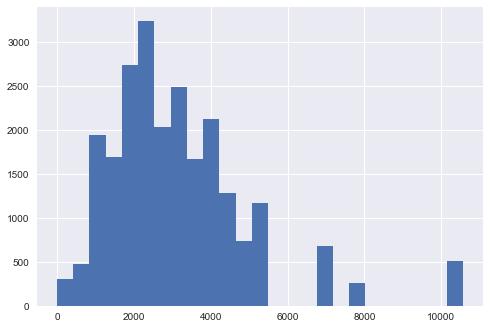

 | NaN 0.22 | is numeric | 122 unique values  | consider one-hot? (ordinal?) 

preschool_education_centers_raion -- Feature 
count    30471.00
mean         4.07
std          2.99
min          0.00
25%          2.00
50%          4.00
75%          6.00
max         13.00
Name: preschool_education_centers_raion, dtype: float64
0.0 13.0


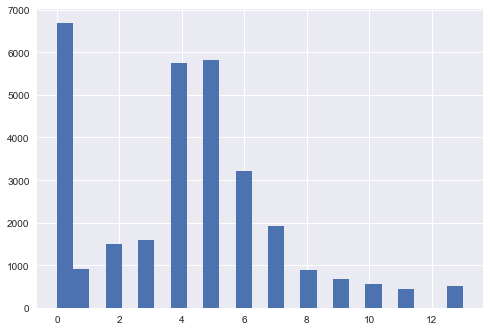

 | is numeric | 13 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                                   price_doc  price_doc  price_doc  \
preschool_education_centers_raion                                    
0                                       6688    5182005    4952614   
1                                        904    8716505    7300000   
2                                       1489    7244849    6517253   
3                                       1600    7196058    6300000   
4                                       5759    7642385    6600000   
5                                       5822    7620086    6518400   
6                                       3204    7211411    6400000   
7                                       1918    8206151    7000000   
8                                        888    9646054    8000000   
9                                        679    8809622    8700000   
10                                       561    6396952  

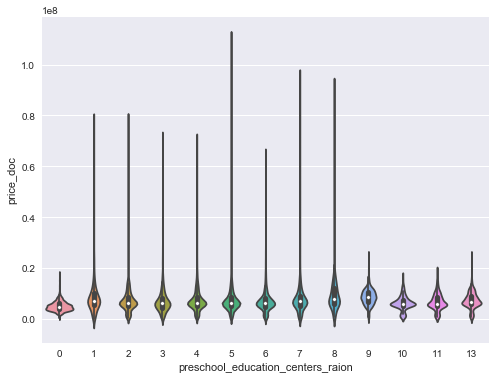


children_school -- Feature 
count    30471.0
mean      5354.0
std       3990.0
min        168.0
25%       1564.0
50%       5261.0
75%       7227.0
max      19083.0
Name: children_school, dtype: float64
168.0 19083.0


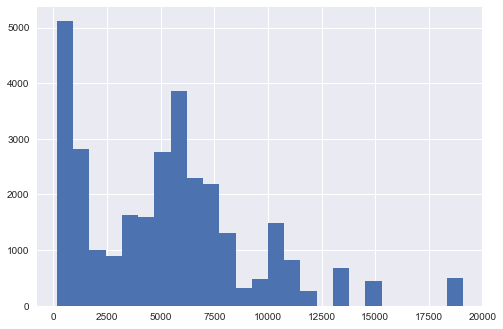

 | is numeric | 146 unique values  | consider one-hot? (ordinal?) 

school_quota -- Feature 
count    23786.0
mean      8325.0
std       4290.0
min       1012.0
25%       5782.0
50%       7377.0
75%       9891.0
max      24750.0
Name: school_quota, dtype: float64
1012.0 22760.2025228


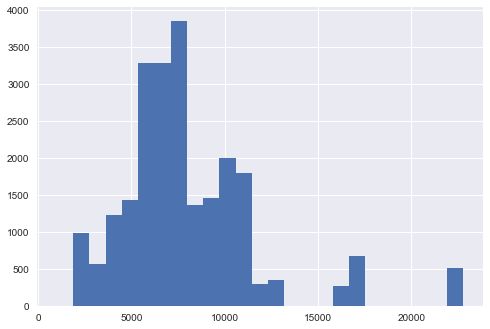

 | NaN 0.22 | is numeric | 126 unique values  | consider one-hot? (ordinal?) 

school_education_centers_raion -- Feature 
count    30471.00
mean         4.71
std          3.45
min          0.00
25%          2.00
50%          5.00
75%          7.00
max         14.00
Name: school_education_centers_raion, dtype: float64
0.0 14.0


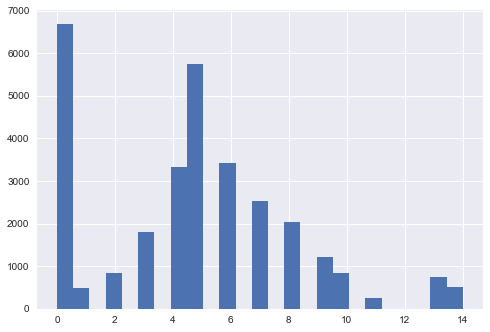

 | is numeric | 14 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                                price_doc  price_doc  price_doc     price_doc
school_education_centers_raion                                               
0                                    6685    5183089    4953375  1.821885e+06
1                                     492    8307240    7200000  6.446225e+06
2                                     847    8614043    7300000  6.322326e+06
3                                    1795    6518014    6000000  3.995386e+06
4                                    3324    7455912    6490541  5.225738e+06
5                                    5747    6973998    6304515  4.113924e+06
6                                    3430    7537758    6650000  4.956418e+06
7                                    2526    7444014    6650000  4.496223e+06
8                                    2034    9661135    7824725  7.366366e+06
9                                    12

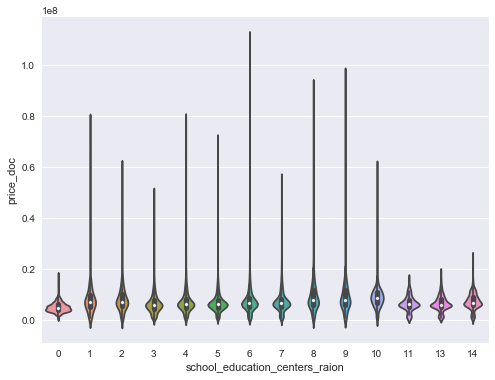


school_education_centers_top_20_raion -- Feature 
count    30471.00
mean         0.11
std          0.33
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          2.00
Name: school_education_centers_top_20_raion, dtype: float64
0.0 0.999985288297


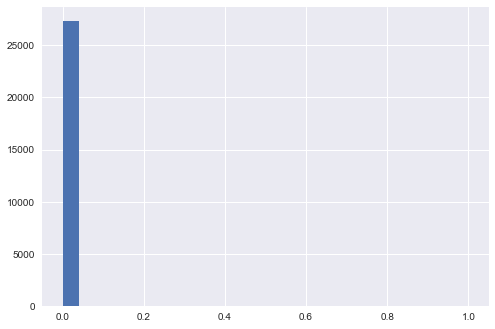

 | is numeric | 3 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                                       price_doc  price_doc  price_doc  \
school_education_centers_top_20_raion                                    
0                                          27334    6977862    6200000   
1                                           2932    8136190    6600000   
2                                            205   11989346   11600000   

                                          price_doc  
school_education_centers_top_20_raion                
0                                      4.544884e+06  
1                                      6.261385e+06  
2                                      6.372224e+06  


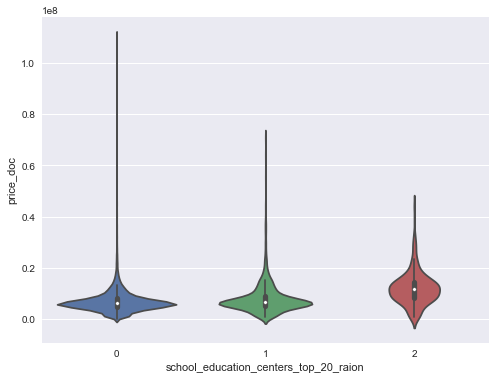


hospital_beds_raion -- Feature 
count    16030.0
mean      1191.0
std       1057.0
min          0.0
25%        520.0
50%        990.0
75%       1786.0
max       4849.0
Name: hospital_beds_raion, dtype: float64
0.0 4849.0


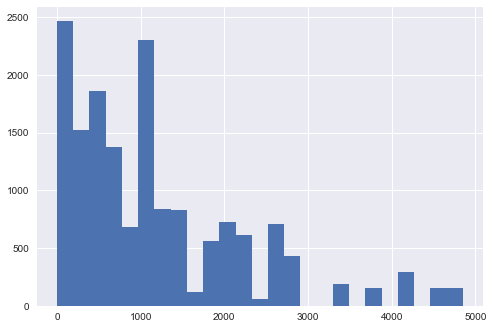

 | NaN 0.47 | is numeric | 80 unique values  | consider one-hot? (ordinal?) 

healthcare_centers_raion -- Feature 
count    30471.00
mean         1.32
std          1.49
min          0.00
25%          0.00
50%          1.00
75%          2.00
max          6.00
Name: healthcare_centers_raion, dtype: float64
0.0 6.0


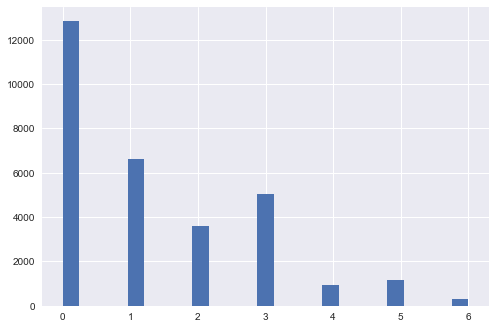

 | is numeric | 7 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                          price_doc  price_doc  price_doc     price_doc
healthcare_centers_raion                                               
0                             12842    6000804    5500000  3.419444e+06
1                              6604    7753652    7000000  4.573262e+06
2                              3582    7831834    6581350  6.021660e+06
3                              5037    7689560    6700000  5.115792e+06
4                               960    8638220    7351400  5.953629e+06
5                              1146    9484598    7771200  7.727048e+06
6                               300    9435211    7200000  6.217726e+06


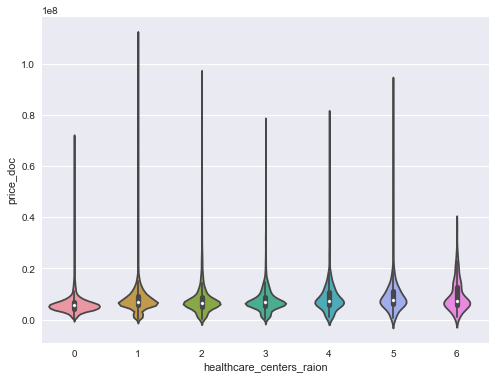


university_top_20_raion -- Feature 
count    30471.00
mean         0.14
std          0.44
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          3.00
Name: university_top_20_raion, dtype: float64
0.0 1.3313888406


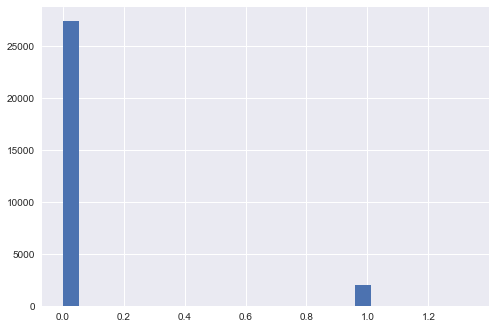

 | is numeric | 4 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                         price_doc  price_doc  price_doc     price_doc
university_top_20_raion                                               
0                            27392    6791171    6200000  3.999549e+06
1                             1994   11093303    8800000  9.293781e+06
2                             1035    7817636    6205500  6.407885e+06
3                               50   16218682   12750000  9.455136e+06


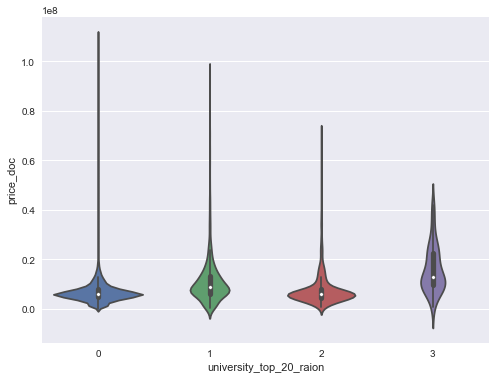


sport_objects_raion -- Feature 
count    30471.00
mean         6.64
std          6.57
min          0.00
25%          1.00
50%          5.00
75%         10.00
max         29.00
Name: sport_objects_raion, dtype: float64
0.0 29.0


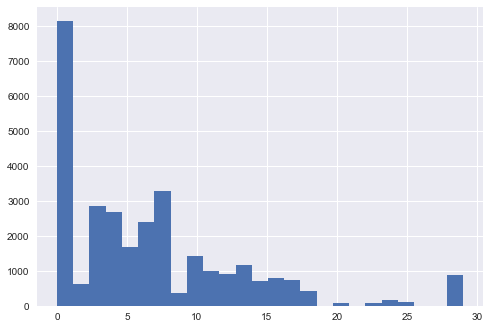

 | is numeric | 24 unique values  | consider one-hot? (ordinal?) 

additional_education_raion -- Feature 
count    30471.00
mean         2.90
std          3.29
min          0.00
25%          1.00
50%          2.00
75%          4.00
max         16.00
Name: additional_education_raion, dtype: float64
0.0 13.8701733708


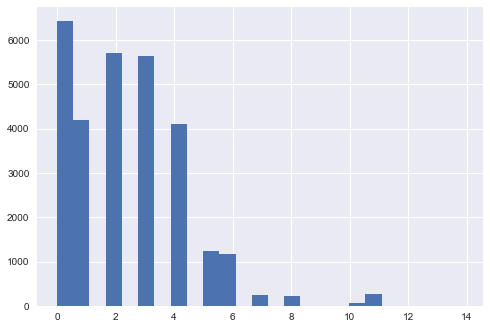

 | is numeric | 12 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                            price_doc  price_doc  price_doc     price_doc
additional_education_raion                                               
0                                6428    5935987    5522183  3.224982e+06
1                                4193    7642414    6528000  5.069998e+06
2                                5699    7769953    6600000  5.754766e+06
3                                5639    6690293    6096003  4.084834e+06
4                                4112    6820273    6124198  4.094628e+06
5                                1245   10021642    8000000  8.046672e+06
6                                1176    8487305    8200000  3.904186e+06
7                                 237    8282320    8000000  4.186052e+06
8                                 220    6150727    5650000  3.353972e+06
10                                 72    9676444    8790000  5.590756e+06
11       

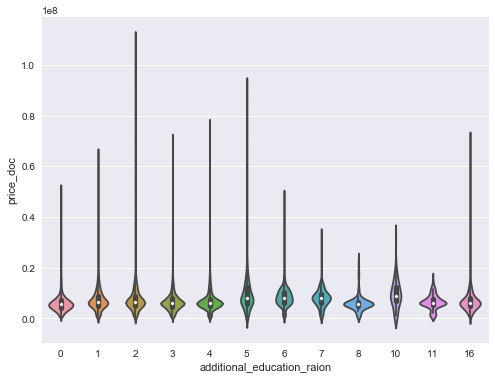


culture_objects_top_25 -- Feature 
 | is not numeric | 2 unique values  | consider one-hot?
Levels | Count | Mean | Median | std
                        price_doc  price_doc  price_doc     price_doc
culture_objects_top_25                                               
no                          28543    6924696    6200000  4.248630e+06
yes                          1928   10059329    7400000  9.204756e+06


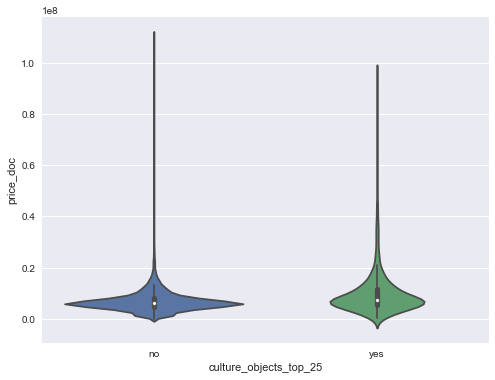


culture_objects_top_25_raion -- Feature 
count    30471.00
mean         0.29
std          1.51
min          0.00
25%          0.00
50%          0.00
75%          0.00
max         10.00
Name: culture_objects_top_25_raion, dtype: float64
0.0 4.5314726654


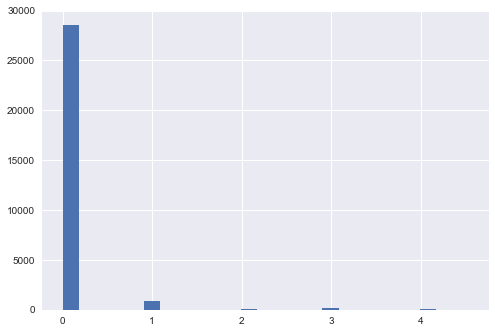

 | is numeric | 6 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                              price_doc  price_doc  price_doc     price_doc
culture_objects_top_25_raion                                               
0                                 28543    6924696    6200000  4.248630e+06
1                                   891   10562443    8900000  8.498836e+06
2                                    90   20116565   15625000  1.393017e+07
3                                   190   14032071    9415000  1.342608e+07
4                                    79    8687360    7900000  4.570106e+06
10                                  678    7109681    5595230  6.389769e+06


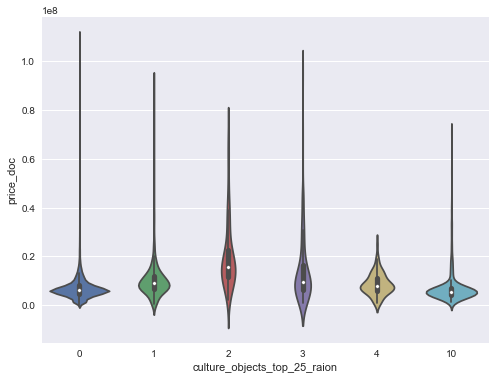


shopping_centers_raion -- Feature 
count    30471.00
mean         4.20
std          4.74
min          0.00
25%          1.00
50%          3.00
75%          6.00
max         23.00
Name: shopping_centers_raion, dtype: float64
0.0 20.2254352989


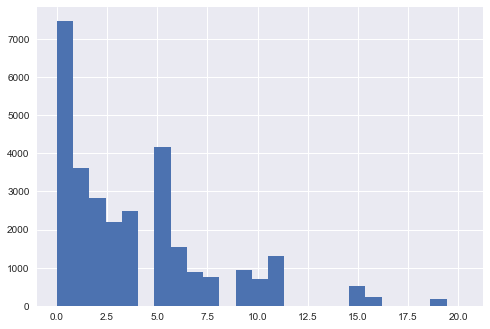

 | is numeric | 16 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                        price_doc  price_doc  price_doc     price_doc
shopping_centers_raion                                               
0                            7471    5461104    5200000  2.453897e+06
1                            3615    6739861    6050000  3.899060e+06
2                            2827    6734342    6000000  4.143958e+06
3                            2198    7884392    7000000  5.393779e+06
4                            2487    7452353    6400000  4.810691e+06
5                            4171    7949688    6600000  6.706814e+06
6                            1542    8558539    7300000  5.214926e+06
7                             888    8569570    7850000  5.281415e+06
8                             743    7864281    6800000  5.080204e+06
9                             949    7698180    7100000  4.324793e+06
10                            693    9425606    8000000  

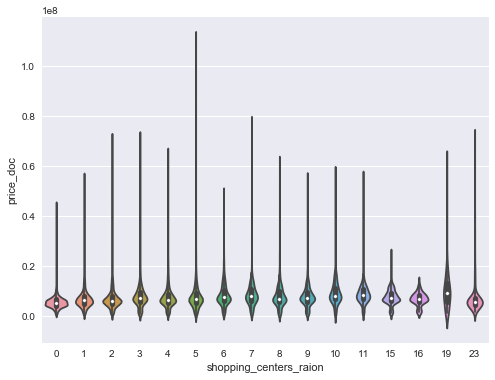


office_raion -- Feature 
count    30471.00
mean         8.25
std         23.54
min          0.00
25%          0.00
50%          2.00
75%          5.00
max        141.00
Name: office_raion, dtype: float64
0.0 75.61085993


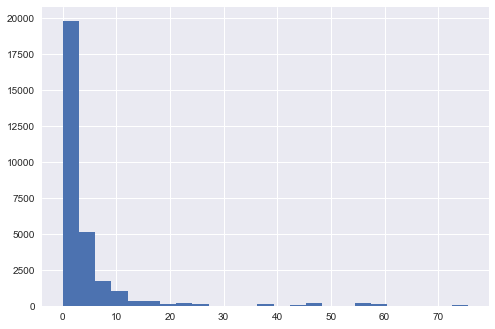

 | is numeric | 30 unique values  | consider one-hot? (ordinal?) 

thermal_power_plant_raion -- Feature 
 | is not numeric | 2 unique values  | consider one-hot?
Levels | Count | Mean | Median | std
                           price_doc  price_doc  price_doc     price_doc
thermal_power_plant_raion                                               
no                             28817    7083619    6250000  4.755808e+06
yes                             1654    7809766    6600000  5.138522e+06


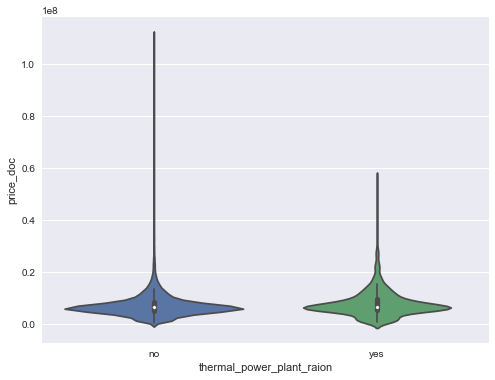


incineration_raion -- Feature 
 | is not numeric | 2 unique values  | consider one-hot?
Levels | Count | Mean | Median | std
                    price_doc  price_doc  price_doc     price_doc
incineration_raion                                               
no                      28155    7231713    6300000  4.921646e+06
yes                      2316    5801867    5711360  2.066383e+06


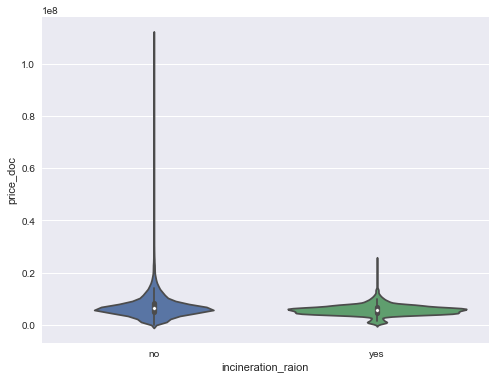


oil_chemistry_raion -- Feature 
 | is not numeric | 2 unique values  | consider one-hot?
Levels | Count | Mean | Median | std
                     price_doc  price_doc  price_doc     price_doc
oil_chemistry_raion                                               
no                       30175    7134629    6290256  4.794660e+06
yes                        296    5941056    5850000  2.694942e+06


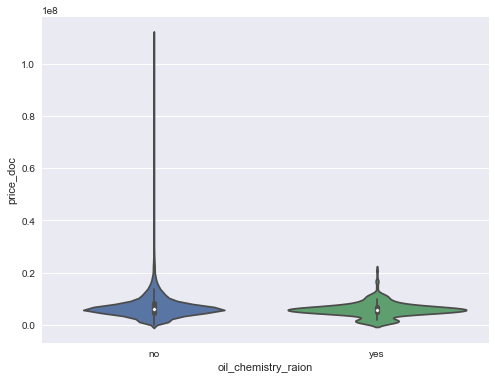


radiation_raion -- Feature 
 | is not numeric | 2 unique values  | consider one-hot?
Levels | Count | Mean | Median | std
                 price_doc  price_doc  price_doc     price_doc
radiation_raion                                               
no                   19600    6682753    6030000  3.886987e+06
yes                  10871    7916845    6644427  5.985715e+06


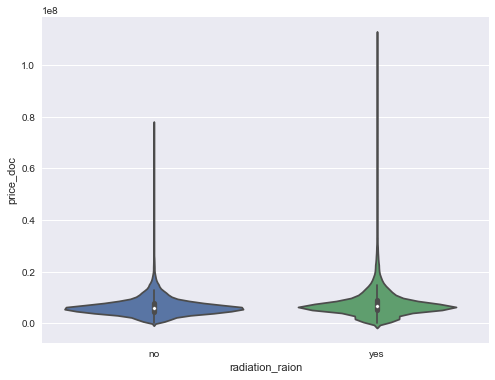


railroad_terminal_raion -- Feature 
 | is not numeric | 2 unique values  | consider one-hot?
Levels | Count | Mean | Median | std
                         price_doc  price_doc  price_doc     price_doc
railroad_terminal_raion                                               
no                           29335    7069163    6258639  4.664555e+06
yes                           1136    8514181    6565209  7.004608e+06


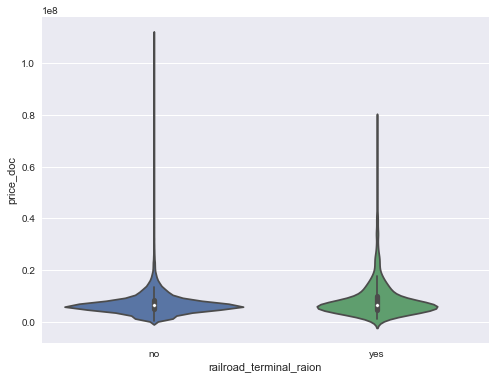


big_market_raion -- Feature 
 | is not numeric | 2 unique values  | consider one-hot?
Levels | Count | Mean | Median | std
                  price_doc  price_doc  price_doc     price_doc
big_market_raion                                               
no                    27649    7242389    6341258  4.897874e+06
yes                    2822    5953647    5600000  3.190609e+06


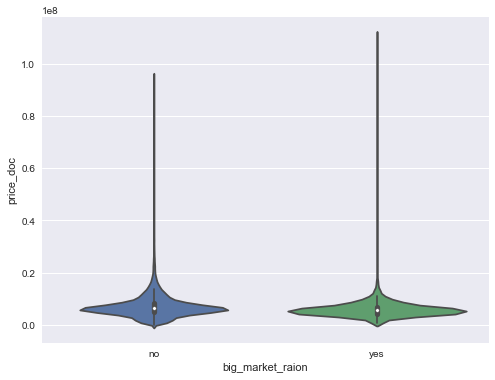


nuclear_reactor_raion -- Feature 
 | is not numeric | 2 unique values  | consider one-hot?
Levels | Count | Mean | Median | std
                       price_doc  price_doc  price_doc     price_doc
nuclear_reactor_raion                                               
no                         29608    7100172    6250000  4.763467e+06
yes                          863    7907419    6900000  5.262891e+06


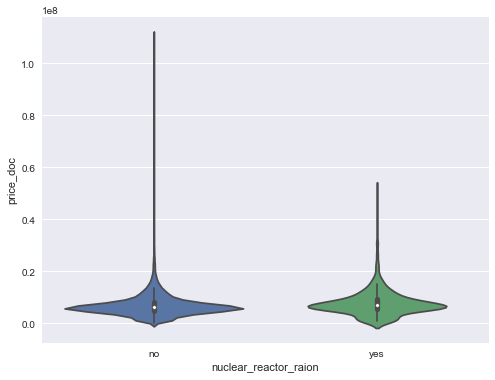


detention_facility_raion -- Feature 
 | is not numeric | 2 unique values  | consider one-hot?
Levels | Count | Mean | Median | std
                          price_doc  price_doc  price_doc     price_doc
detention_facility_raion                                               
no                            27427    7063324    6205910  4.740755e+06
yes                            3044    7661038    6650000  5.090432e+06


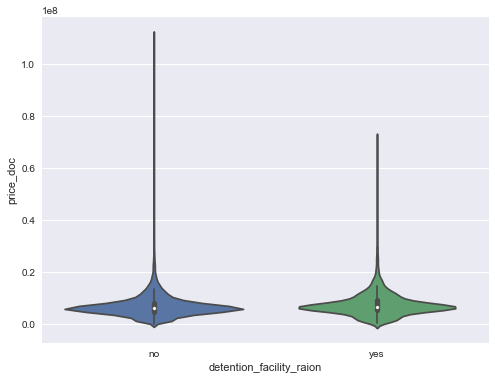


full_all -- Feature 
count      30471.0
mean      146306.0
std       283025.0
min         2546.0
25%        28179.0
50%        85219.0
75%       125111.0
max      1716730.0
Name: full_all, dtype: float64
2546.0 974186.361902


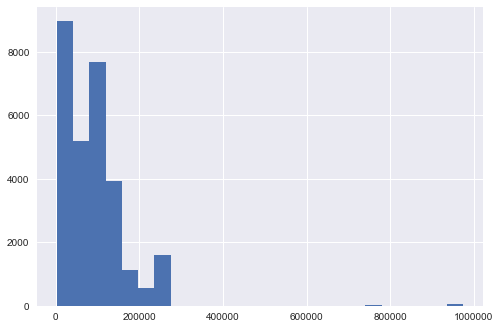

 | is numeric | 146 unique values  | consider one-hot? (ordinal?) 

male_f -- Feature 
count     30471.0
mean      67208.0
std      129445.0
min        1208.0
25%       13522.0
50%       39261.0
75%       58226.0
max      774585.0
Name: male_f, dtype: float64
1208.0 446559.671967


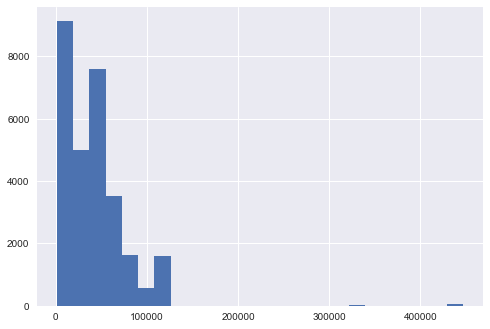

 | is numeric | 146 unique values  | consider one-hot? (ordinal?) 

female_f -- Feature 
count     30471.0
mean      79099.0
std      153631.0
min        1341.0
25%       15031.0
50%       45729.0
75%       67872.0
max      942145.0
Name: female_f, dtype: float64
1341.0 528764.683705


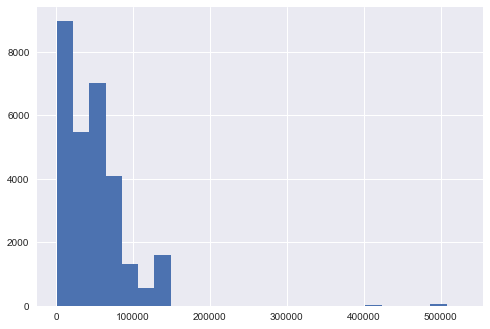

 | is numeric | 146 unique values  | consider one-hot? (ordinal?) 

young_all -- Feature 
count    30471.0
mean     11179.0
std       8288.0
min        365.0
25%       3459.0
50%      10988.0
75%      14906.0
max      40692.0
Name: young_all, dtype: float64
365.0 39769.872869


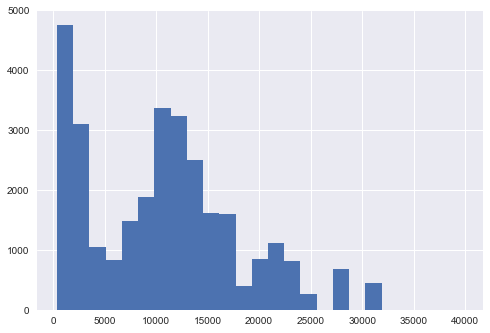

 | is numeric | 146 unique values  | consider one-hot? (ordinal?) 

young_male -- Feature 
count    30471.0
mean      5724.0
std       4275.0
min        189.0
25%       1782.0
50%       5470.0
75%       7597.0
max      20977.0
Name: young_male, dtype: float64
189.0 20423.315092


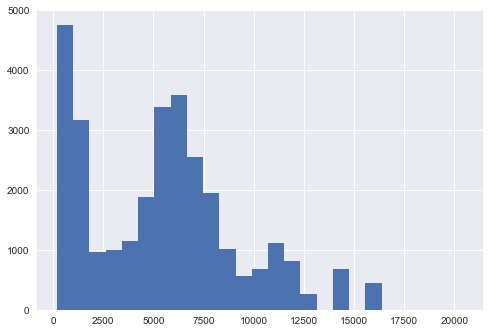

 | is numeric | 145 unique values  | consider one-hot? (ordinal?) 

young_female -- Feature 
count    30471.0
mean      5455.0
std       4021.0
min        177.0
25%       1677.0
50%       5333.0
75%       7617.0
max      19715.0
Name: young_female, dtype: float64
177.0 19678.63885


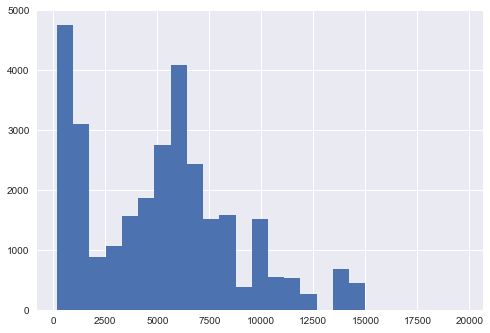

 | is numeric | 145 unique values  | consider one-hot? (ordinal?) 

work_all -- Feature 
count     30471.0
mean      53668.0
std       37484.0
min        1633.0
25%       13996.0
50%       52030.0
75%       77612.0
max      161290.0
Name: work_all, dtype: float64
1633.0 161290.0


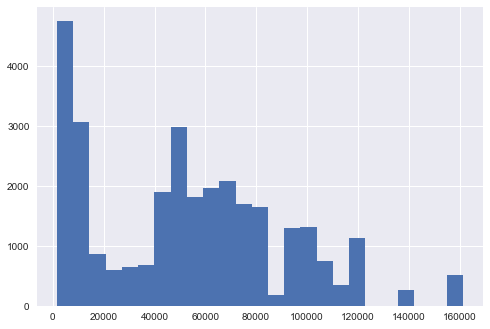

 | is numeric | 145 unique values  | consider one-hot? (ordinal?) 

work_male -- Feature 
count    30471.0
mean     27254.0
std      18939.0
min        863.0
25%       7394.0
50%      26382.0
75%      38841.0
max      79622.0
Name: work_male, dtype: float64
863.0 79622.0


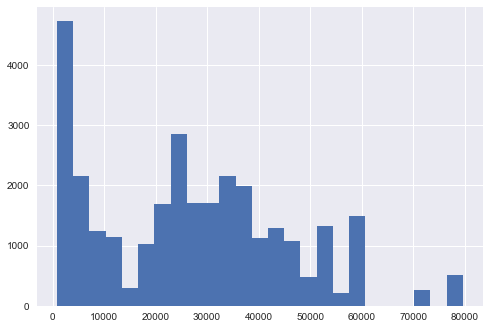

 | is numeric | 145 unique values  | consider one-hot? (ordinal?) 

work_female -- Feature 
count    30471.0
mean     26414.0
std      18643.0
min        771.0
25%       6661.0
50%      26092.0
75%      37942.0
max      81668.0
Name: work_female, dtype: float64
771.0 81668.0


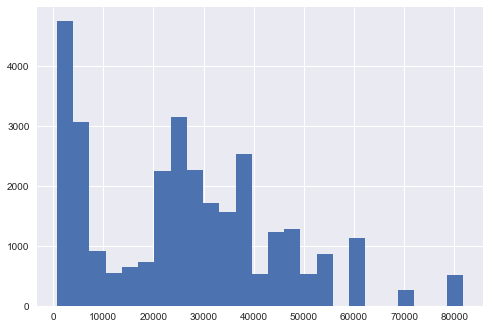

 | is numeric | 146 unique values  | consider one-hot? (ordinal?) 

ekder_all -- Feature 
count    30471.0
mean     19210.0
std      13175.0
min        548.0
25%       4695.0
50%      20036.0
75%      29172.0
max      57086.0
Name: ekder_all, dtype: float64
548.0 57086.0


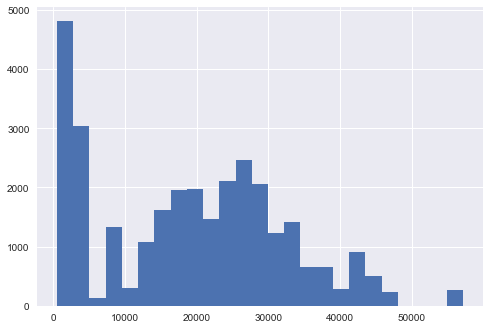

 | is numeric | 146 unique values  | consider one-hot? (ordinal?) 

ekder_male -- Feature 
count    30471.0
mean      5812.0
std       4074.0
min        156.0
25%       1331.0
50%       6180.0
75%       8563.0
max      19275.0
Name: ekder_male, dtype: float64
156.0 19275.0


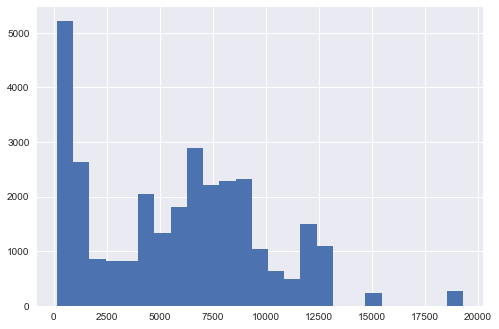

 | is numeric | 146 unique values  | consider one-hot? (ordinal?) 

ekder_female -- Feature 
count    30471.0
mean     13398.0
std       9144.0
min        393.0
25%       3365.0
50%      13540.0
75%      20165.0
max      37811.0
Name: ekder_female, dtype: float64
393.0 37811.0


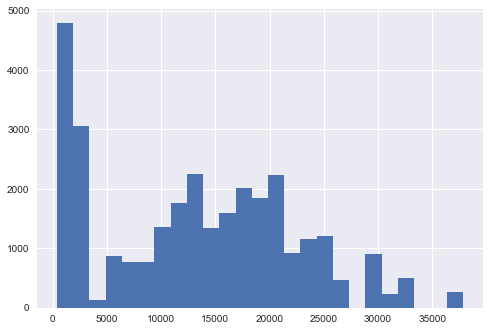

 | is numeric | 146 unique values  | consider one-hot? (ordinal?) 

0_6_all -- Feature 
count    30471.0
mean      5140.0
std       3817.0
min        175.0
25%       1706.0
50%       4857.0
75%       7103.0
max      19223.0
Name: 0_6_all, dtype: float64
175.0 18552.8754201


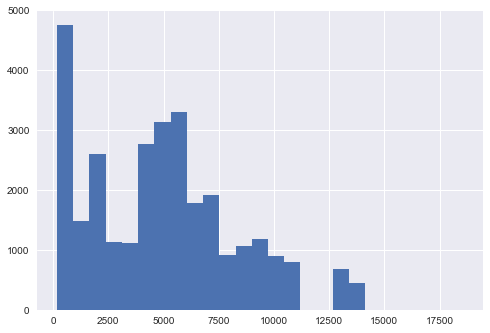

 | is numeric | 146 unique values  | consider one-hot? (ordinal?) 

0_6_male -- Feature 
count    30471.0
mean      2631.0
std       1973.0
min         91.0
25%        862.0
50%       2435.0
75%       3523.0
max       9987.0
Name: 0_6_male, dtype: float64
91.0 9442.66204355


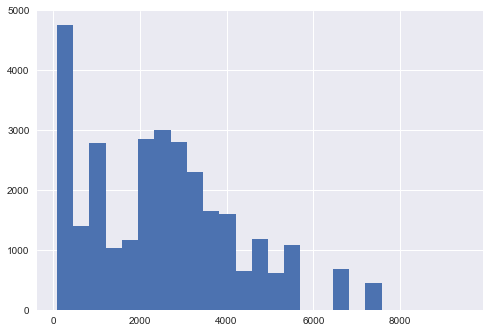

 | is numeric | 144 unique values  | consider one-hot? (ordinal?) 

0_6_female -- Feature 
count    30471.0
mean      2509.0
std       1847.0
min         85.0
25%        844.0
50%       2390.0
75%       3455.0
max       9236.0
Name: 0_6_female, dtype: float64
85.0 8994.79421664


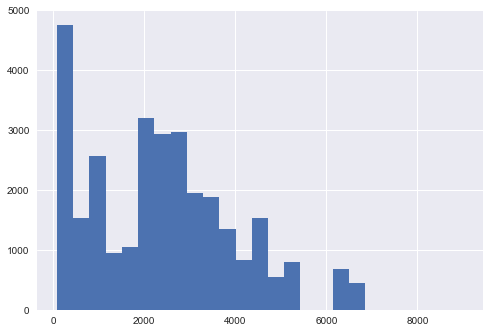

 | is numeric | 145 unique values  | consider one-hot? (ordinal?) 

7_14_all -- Feature 
count    30471.0
mean      5354.0
std       3990.0
min        168.0
25%       1564.0
50%       5261.0
75%       7227.0
max      19083.0
Name: 7_14_all, dtype: float64
168.0 19083.0


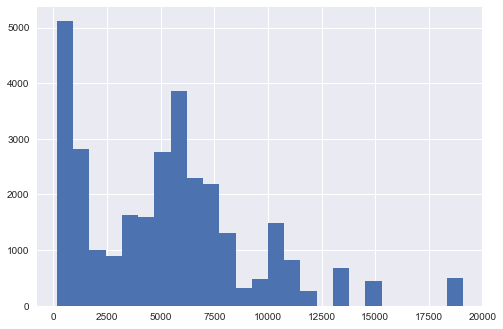

 | is numeric | 146 unique values  | consider one-hot? (ordinal?) 

7_14_male -- Feature 
count    30471.0
mean      2743.0
std       2055.0
min         87.0
25%        821.0
50%       2693.0
75%       3585.0
max       9761.0
Name: 7_14_male, dtype: float64
87.0 9748.56456093


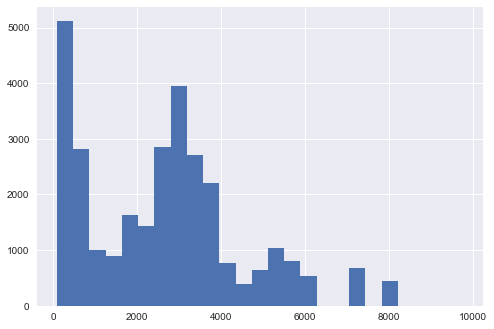

 | is numeric | 142 unique values  | consider one-hot? (ordinal?) 

7_14_female -- Feature 
count    30471.0
mean      2611.0
std       1941.0
min         82.0
25%        743.0
50%       2535.0
75%       3534.0
max       9322.0
Name: 7_14_female, dtype: float64
82.0 9322.0


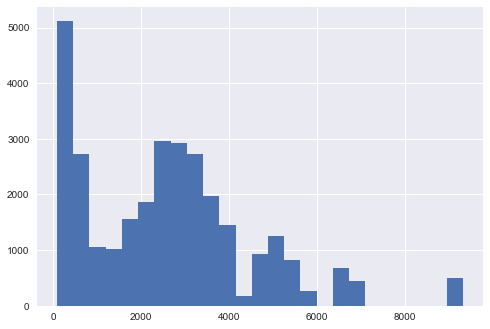

 | is numeric | 145 unique values  | consider one-hot? (ordinal?) 

0_17_all -- Feature 
count    30471.0
mean     12541.0
std       9253.0
min        411.0
25%       3831.0
50%      12508.0
75%      16727.0
max      45170.0
Name: 0_17_all, dtype: float64
411.0 44486.1400777


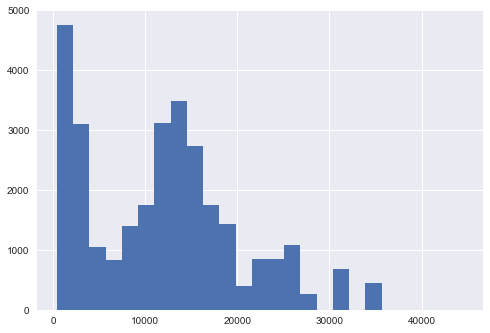

 | is numeric | 145 unique values  | consider one-hot? (ordinal?) 

0_17_male -- Feature 
count    30471.0
mean      6423.0
std       4770.0
min        214.0
25%       1973.0
50%       6085.0
75%       8599.0
max      23233.0
Name: 0_17_male, dtype: float64
214.0 22907.7799843


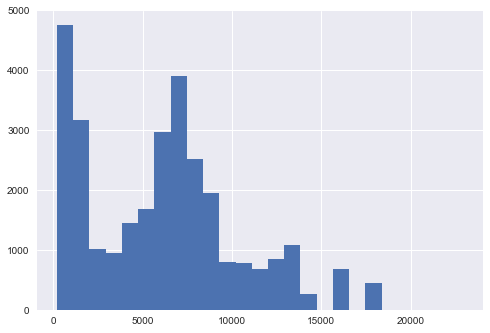

 | is numeric | 146 unique values  | consider one-hot? (ordinal?) 

0_17_female -- Feature 
count    30471.0
mean      6118.0
std       4492.0
min        198.0
25%       1858.0
50%       6185.0
75%       8549.0
max      21937.0
Name: 0_17_female, dtype: float64
198.0 21937.0


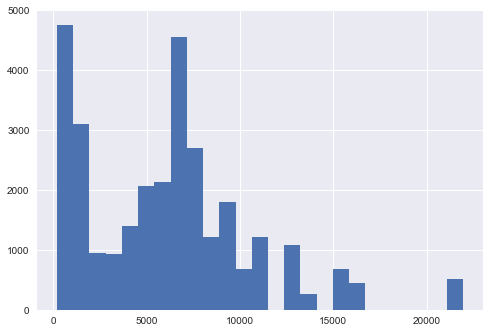

 | is numeric | 146 unique values  | consider one-hot? (ordinal?) 

16_29_all -- Feature 
count     30471.0
mean      31316.0
std       60382.0
min         575.0
25%        5829.0
50%       17864.0
75%       27194.0
max      367659.0
Name: 16_29_all, dtype: float64
575.0 208338.556038


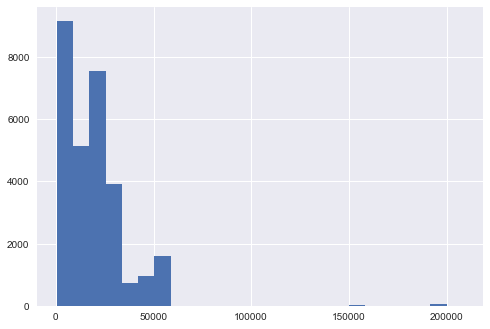

 | is numeric | 145 unique values  | consider one-hot? (ordinal?) 

16_29_male -- Feature 
count     30471.0
mean      15369.0
std       29299.0
min         308.0
25%        2955.0
50%        8896.0
75%       13683.0
max      172958.0
Name: 16_29_male, dtype: float64
308.0 101578.945258


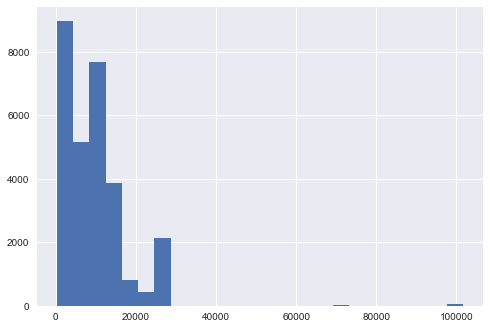

 | is numeric | 145 unique values  | consider one-hot? (ordinal?) 

16_29_female -- Feature 
count     30471.0
mean      15947.0
std       31109.0
min         253.0
25%        2874.0
50%        9353.0
75%       14184.0
max      194701.0
Name: 16_29_female, dtype: float64
253.0 107510.930476


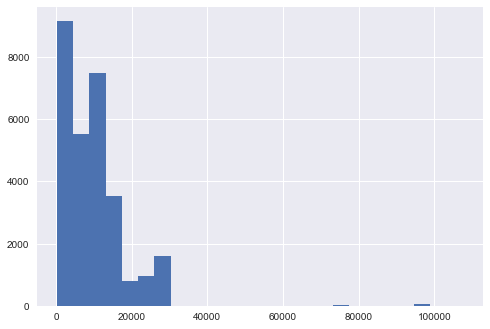

 | is numeric | 146 unique values  | consider one-hot? (ordinal?) 

0_13_all -- Feature 
count    30471.0
mean      9841.0
std       7290.0
min        322.0
25%       3112.0
50%       9633.0
75%      13121.0
max      36035.0
Name: 0_13_all, dtype: float64
322.0 34991.021355


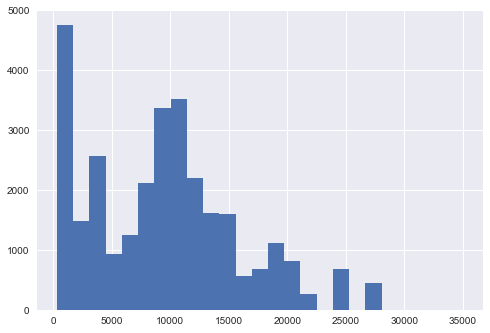

 | is numeric | 146 unique values  | consider one-hot? (ordinal?) 

0_13_male -- Feature 
count    30471.0
mean      5037.0
std       3761.0
min        166.0
25%       1600.0
50%       4835.0
75%       6684.0
max      18574.0
Name: 0_13_male, dtype: float64
166.0 17966.2519455


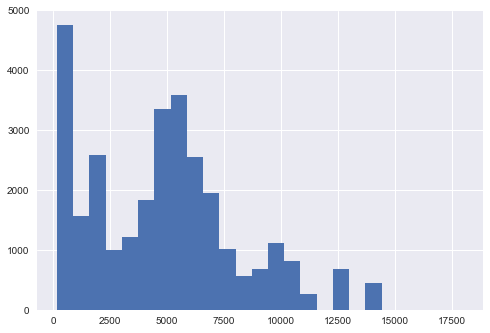

 | is numeric | 144 unique values  | consider one-hot? (ordinal?) 

0_13_female -- Feature 
count    30471.0
mean      4804.0
std       3537.0
min        156.0
25%       1512.0
50%       4667.0
75%       6699.0
max      17461.0
Name: 0_13_female, dtype: float64
156.0 17309.7224587


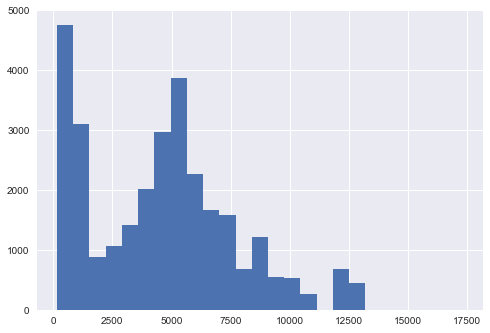

 | is numeric | 146 unique values  | consider one-hot? (ordinal?) 

raion_build_count_with_material_info -- Feature 
count    25480.0
mean       329.0
std        278.0
min          1.0
25%        180.0
50%        273.0
75%        400.0
max       1681.0
Name: raion_build_count_with_material_info, dtype: float64
1.0 1233.71203364


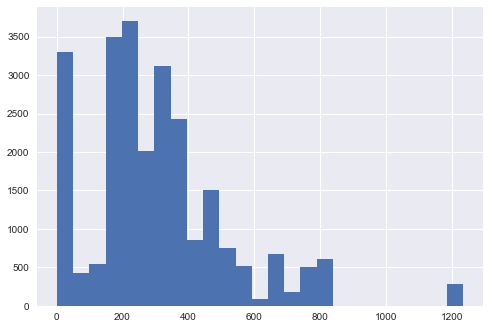

 | NaN 0.16 | is numeric | 113 unique values  | consider one-hot? (ordinal?) 

build_count_block -- Feature 
count    25480.00
mean        50.30
std         46.94
min          0.00
25%         13.00
50%         42.00
75%         72.00
max        223.00
Name: build_count_block, dtype: float64
0.0 212.812882841


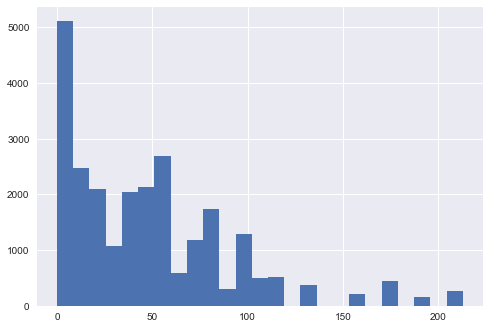

 | NaN 0.16 | is numeric | 77 unique values  | consider one-hot? (ordinal?) 

build_count_wood -- Feature 
count    25480.00
mean        40.85
std        126.74
min          0.00
25%          0.00
50%          0.00
75%          7.00
max        793.00
Name: build_count_wood, dtype: float64
0.0 387.22113081


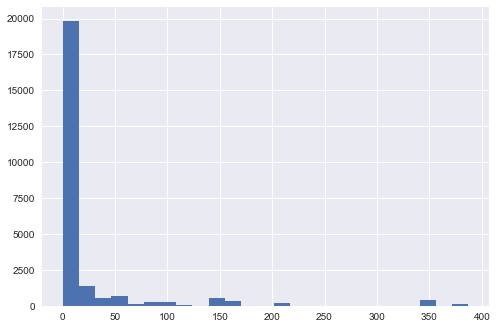

 | NaN 0.16 | is numeric | 35 unique values  | consider one-hot? (ordinal?) 

build_count_frame -- Feature 
count    25480.00
mean         4.95
std         14.93
min          0.00
25%          0.00
50%          0.00
75%          1.00
max         97.00
Name: build_count_frame, dtype: float64
0.0 45.7808012199


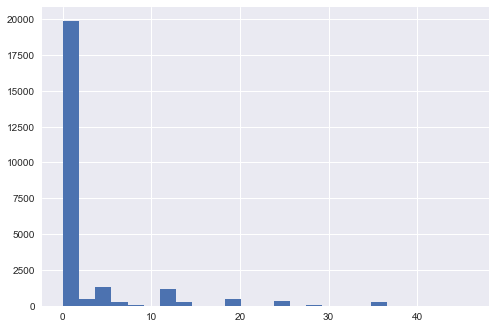

 | NaN 0.16 | is numeric | 22 unique values  | consider one-hot? (ordinal?) 

build_count_brick -- Feature 
count    25480.0
mean       108.0
std        129.0
min          0.0
25%         10.0
50%         67.0
75%        156.0
max        664.0
Name: build_count_brick, dtype: float64
0.0 543.361261524


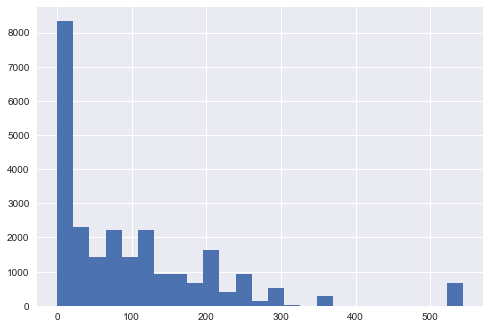

 | NaN 0.16 | is numeric | 102 unique values  | consider one-hot? (ordinal?) 

build_count_monolith -- Feature 
count    25480.00
mean        12.04
std         19.28
min          0.00
25%          2.00
50%          6.00
75%         13.00
max        127.00
Name: build_count_monolith, dtype: float64
0.0 70.8369902318


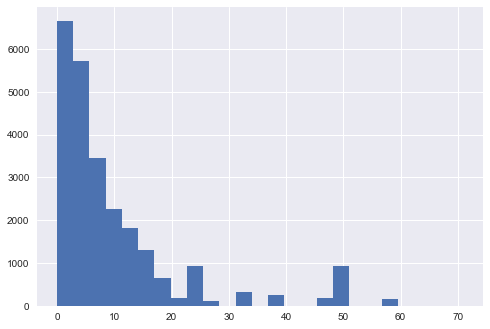

 | NaN 0.16 | is numeric | 34 unique values  | consider one-hot? (ordinal?) 

build_count_panel -- Feature 
count    25480.0
mean       107.0
std         88.0
min          0.0
25%         35.0
50%         92.0
75%        157.0
max        431.0
Name: build_count_panel, dtype: float64
0.0 421.779126658


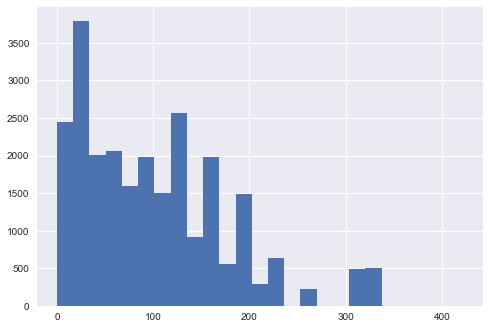

 | NaN 0.16 | is numeric | 92 unique values  | consider one-hot? (ordinal?) 

build_count_foam -- Feature 
count    25480.00
mean         0.17
std          1.13
min          0.00
25%          0.00
50%          0.00
75%          0.00
max         11.00
Name: build_count_foam, dtype: float64
0.0 3.39906767213


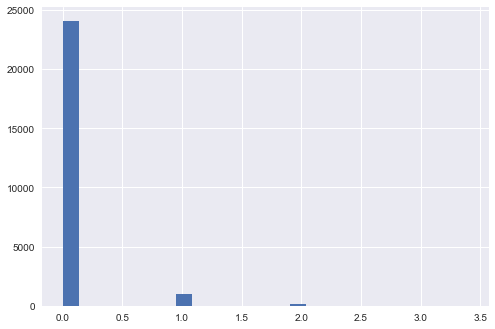

 | NaN 0.16 | is numeric | 5 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                  price_doc  price_doc  price_doc     price_doc
build_count_foam                                               
0.0                   24065    7521434    6500000  5.124967e+06
1.0                     969    6355566    6100000  2.719123e+06
2.0                     184    9105386    7510000  7.017823e+06
11.0                    262    8220024    7200000  5.466116e+06
NaN                    4991    5220416    4988599  1.830023e+06


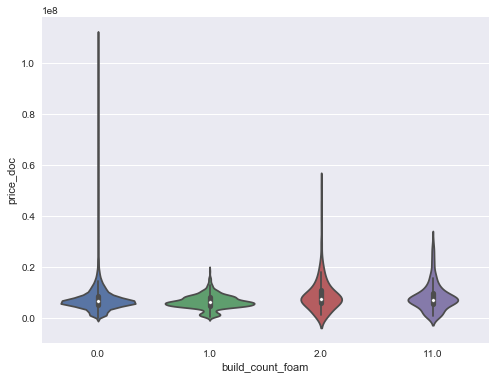


build_count_slag -- Feature 
count    25480.00
mean         4.49
std         13.23
min          0.00
25%          0.00
50%          0.00
75%          2.00
max         84.00
Name: build_count_slag, dtype: float64
0.0 41.6823055168


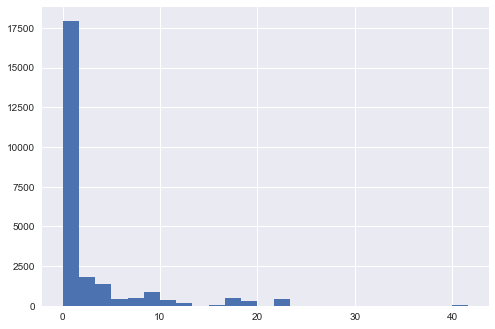

 | NaN 0.16 | is numeric | 22 unique values  | consider one-hot? (ordinal?) 

build_count_mix -- Feature 
count    25480.00
mean         0.57
std          1.53
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          9.00
Name: build_count_mix, dtype: float64
0.0 4.59037888943


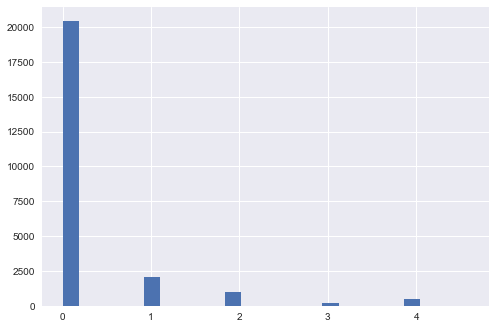

 | NaN 0.16 | is numeric | 10 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                 price_doc  price_doc  price_doc     price_doc
build_count_mix                                               
0.0                  20422    7389886    6500000  4.827900e+06
1.0                   2066    9046282    6709500  8.067799e+06
2.0                    999    8427966    8300000  3.470358e+06
3.0                    173   10153920    8900000  8.281487e+06
4.0                    518    5956599    6095150  2.151478e+06
5.0                    872    6220962    5850000  2.960297e+06
6.0                     44    5024090    4900000  1.738871e+06
8.0                    149    6442241    6600000  2.590132e+06
9.0                    237    6403857    6050000  2.836498e+06
NaN                   4991    5220416    4988599  1.830023e+06


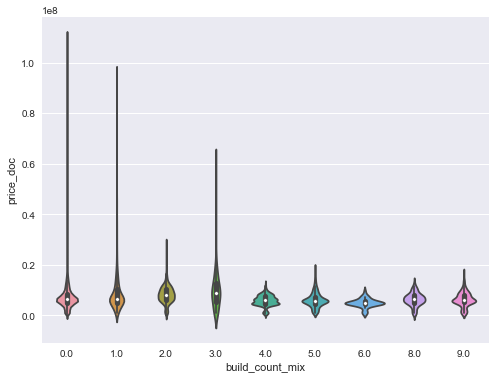


raion_build_count_with_builddate_info -- Feature 
count    25480.0
mean       328.0
std        278.0
min          1.0
25%        178.0
50%        271.0
75%        400.0
max       1680.0
Name: raion_build_count_with_builddate_info, dtype: float64
1.0 1233.75109276


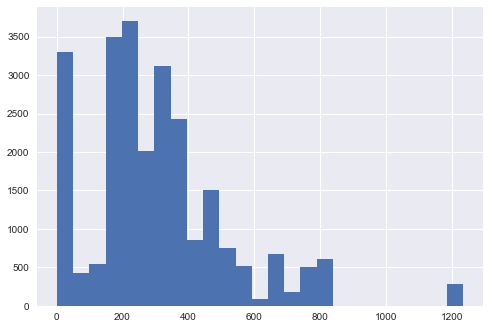

 | NaN 0.16 | is numeric | 115 unique values  | consider one-hot? (ordinal?) 

build_count_before_1920 -- Feature 
count    25480.00
mean        18.90
std         60.98
min          0.00
25%          0.00
50%          0.00
75%          3.00
max        371.00
Name: build_count_before_1920, dtype: float64
0.0 185.949811567


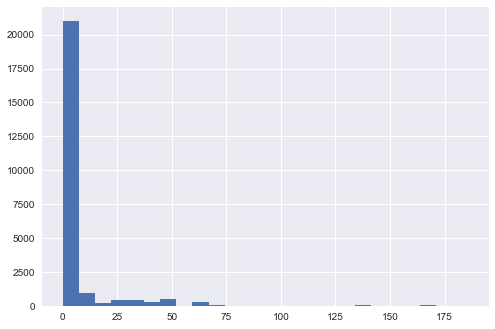

 | NaN 0.16 | is numeric | 30 unique values  | consider one-hot? (ordinal?) 

build_count_1921-1945 -- Feature 
count    25480.00
mean        26.72
std         62.51
min          0.00
25%          0.00
50%          2.00
75%         20.00
max        382.00
Name: build_count_1921-1945, dtype: float64
0.0 207.536788269


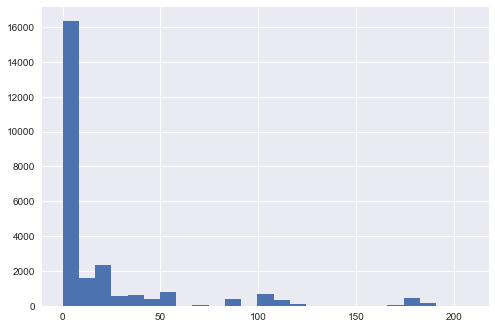

 | NaN 0.16 | is numeric | 48 unique values  | consider one-hot? (ordinal?) 

build_count_1946-1970 -- Feature 
count    25480.0
mean       141.0
std        125.0
min          0.0
25%         14.0
50%        135.0
75%        216.0
max        845.0
Name: build_count_1946-1970, dtype: float64
0.0 592.283465238


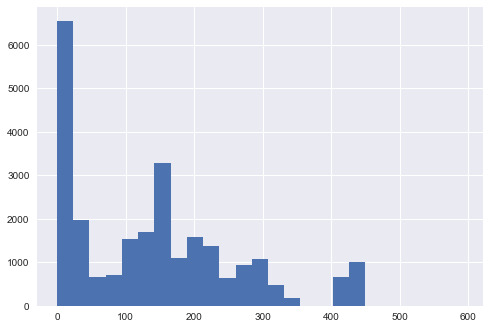

 | NaN 0.16 | is numeric | 101 unique values  | consider one-hot? (ordinal?) 

build_count_1971-1995 -- Feature 
count    25480.00
mean        80.13
std         57.87
min          0.00
25%         37.00
50%         71.00
75%        111.00
max        246.00
Name: build_count_1971-1995, dtype: float64
0.0 246.0


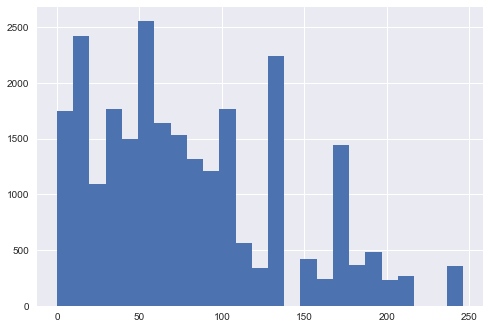

 | NaN 0.16 | is numeric | 93 unique values  | consider one-hot? (ordinal?) 

build_count_after_1995 -- Feature 
count    25480.00
mean        61.15
std        114.22
min          0.00
25%         14.00
50%         24.00
75%         57.00
max        799.00
Name: build_count_after_1995, dtype: float64
0.0 399.66668582


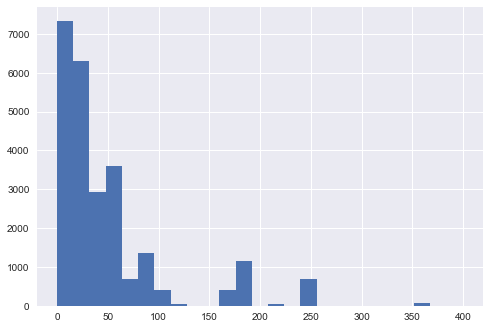

 | NaN 0.16 | is numeric | 70 unique values  | consider one-hot? (ordinal?) 

ID_metro -- Feature 
count    30471.00
mean        72.48
std         54.90
min          1.00
25%         27.00
50%         53.00
75%        108.00
max        223.00
Name: ID_metro, dtype: float64
1.0 223.0


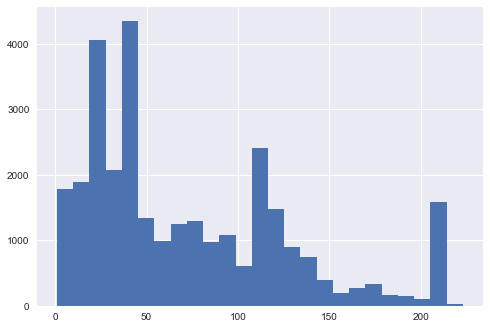

 | is numeric | 223 unique values  | consider one-hot? (ordinal?) 

metro_min_avto -- Feature 
count    30471.00
mean         4.96
std          6.55
min          0.00
25%          1.72
50%          2.80
75%          4.83
max         61.44
Name: metro_min_avto, dtype: float64
0.0 24.4922772315


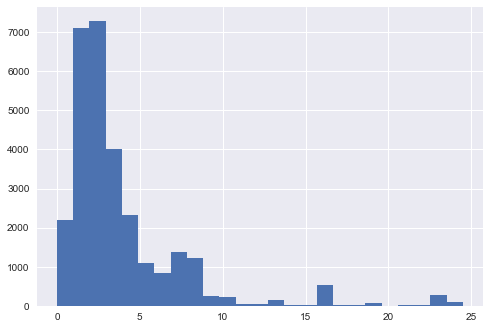

 | is numeric | 11843 unique values 

metro_km_avto -- Feature 
count    30471.00
mean         3.70
std          5.81
min          0.00
25%          1.04
50%          1.78
75%          3.78
max         74.91
Name: metro_km_avto, dtype: float64
0.0 21.2021319145


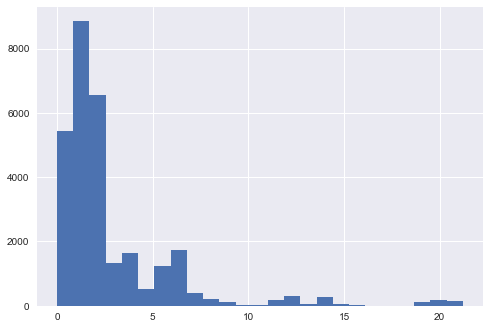

 | is numeric | 11843 unique values 

metro_min_walk -- Feature 
count    30446.00
mean        42.74
std         69.30
min          0.00
25%         11.48
50%         20.45
75%         45.32
max        711.22
Name: metro_min_walk, dtype: float64
0.0 253.231424446


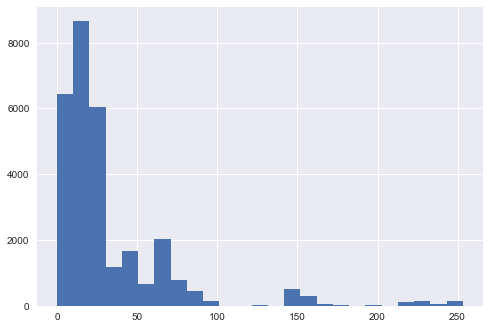

 | NaN 0.0 | is numeric | 11835 unique values 

metro_km_walk -- Feature 
count    30446.00
mean         3.56
std          5.78
min          0.00
25%          0.96
50%          1.70
75%          3.78
max         59.27
Name: metro_km_walk, dtype: float64
0.0 21.1026187052


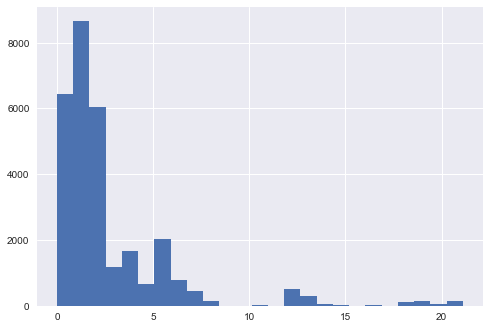

 | NaN 0.0 | is numeric | 11835 unique values 

kindergarten_km -- Feature 
count    30471.00
mean         0.98
std          2.12
min          0.00
25%          0.20
50%          0.35
75%          0.97
max         29.09
Name: kindergarten_km, dtype: float64
0.000469748 7.33728444374


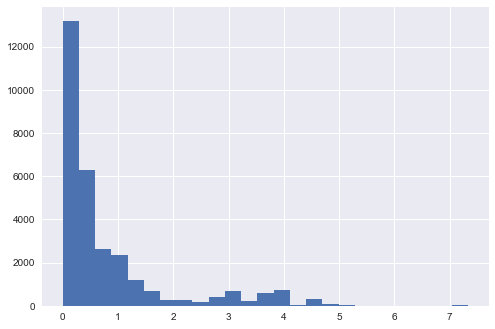

 | is numeric | 11852 unique values 

school_km -- Feature 
count    30471.00
mean         1.32
std          3.06
min          0.00
25%          0.27
50%          0.47
75%          0.89
max         47.39
Name: school_km, dtype: float64
0.0 10.0609652537


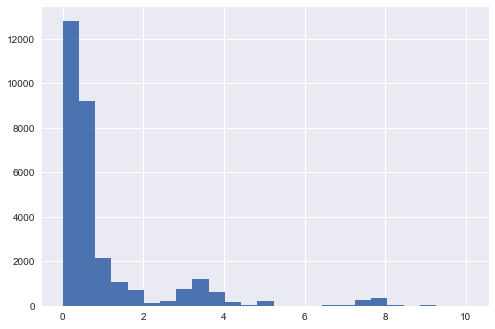

 | is numeric | 11825 unique values 

park_km -- Feature 
count    30471.00
mean         3.10
std          3.97
min          0.00
25%          0.97
50%          1.80
75%          3.40
max         47.35
Name: park_km, dtype: float64
0.003737175 15.3008757528


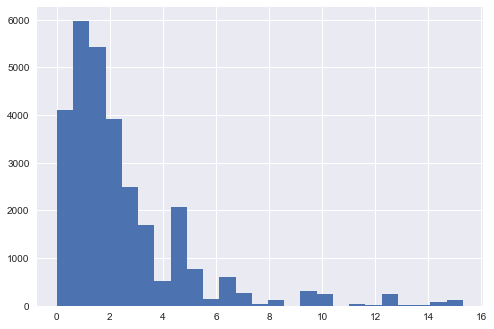

 | is numeric | 11852 unique values 

green_zone_km -- Feature 
count    30471.00
mean         0.30
std          0.30
min          0.00
25%          0.10
50%          0.21
75%          0.42
max          1.98
Name: green_zone_km, dtype: float64
0.0 1.31070480774


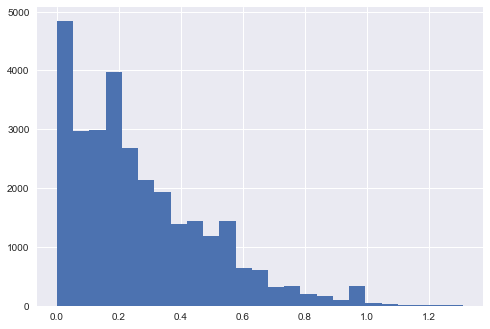

 | is numeric | 11735 unique values 

industrial_km -- Feature 
count    30471.00
mean         0.77
std          0.72
min          0.00
25%          0.29
50%          0.58
75%          1.04
max         14.05
Name: industrial_km, dtype: float64
0.0 3.1949448229


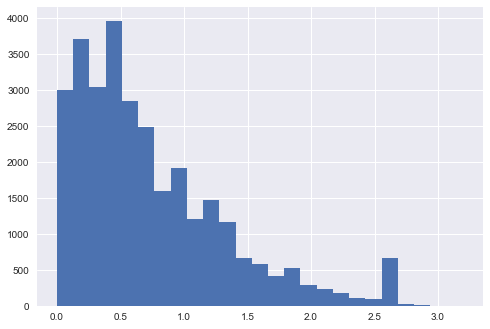

 | is numeric | 11723 unique values 

water_treatment_km -- Feature 
count    30471.00
mean        11.17
std          7.04
min          0.27
25%          5.30
50%         10.38
75%         16.79
max         47.59
Name: water_treatment_km, dtype: float64
0.274139 37.9004230072


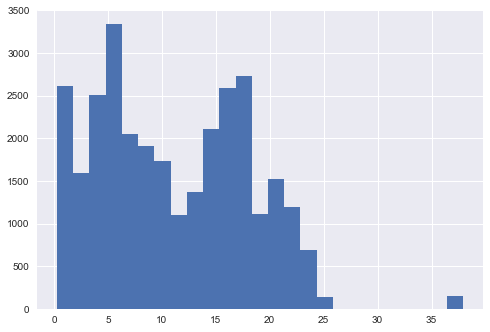

 | is numeric | 11828 unique values 

cemetery_km -- Feature 
count    30471.00
mean         2.31
std          1.45
min          0.00
25%          1.33
50%          1.97
75%          3.09
max         15.78
Name: cemetery_km, dtype: float64
0.0 7.44269226878


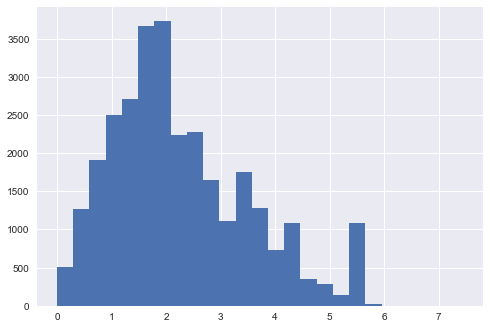

 | is numeric | 11828 unique values 

incineration_km -- Feature 
count    30471.00
mean        10.88
std          6.79
min          0.20
25%          6.22
50%         10.32
75%         13.39
max         58.63
Name: incineration_km, dtype: float64
0.198071 33.7629427908


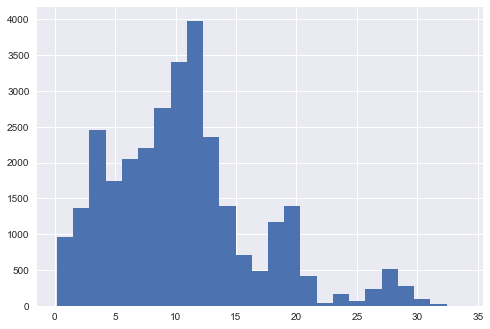

 | is numeric | 11829 unique values 

railroad_station_walk_km -- Feature 
count    30446.00
mean         4.39
std          3.84
min          0.03
25%          1.93
50%          3.24
75%          5.15
max         24.65
Name: railroad_station_walk_km, dtype: float64
0.028152755 16.6567176989


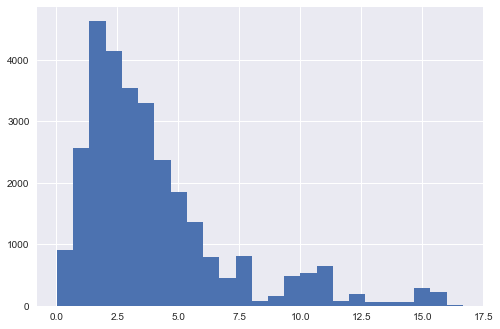

 | NaN 0.0 | is numeric | 11835 unique values 

railroad_station_walk_min -- Feature 
count    30446.00
mean        52.64
std         46.04
min          0.34
25%         23.18
50%         38.83
75%         61.77
max        295.84
Name: railroad_station_walk_min, dtype: float64
0.337833057 199.880612391


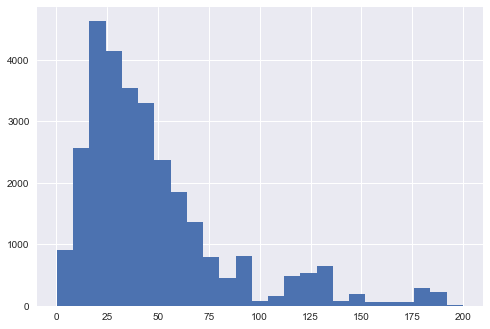

 | NaN 0.0 | is numeric | 11835 unique values 

ID_railroad_station_walk -- Feature 
count    30446.00
mean        38.86
std         27.77
min          1.00
25%         18.00
50%         33.00
75%         53.00
max        133.00
Name: ID_railroad_station_walk, dtype: float64
1.0 133.0


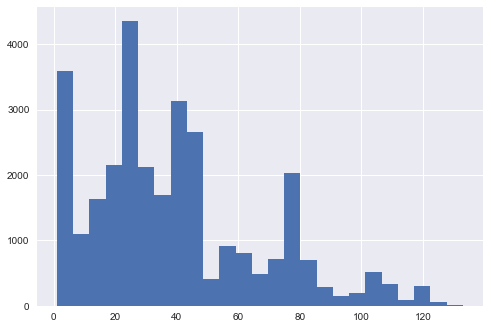

 | NaN 0.0 | is numeric | 134 unique values  | consider one-hot? (ordinal?) 

railroad_station_avto_km -- Feature 
count    30471.00
mean         4.59
std          3.91
min          0.03
25%          2.12
50%          3.43
75%          5.39
max         24.65
Name: railroad_station_avto_km, dtype: float64
0.028152755 17.132631313


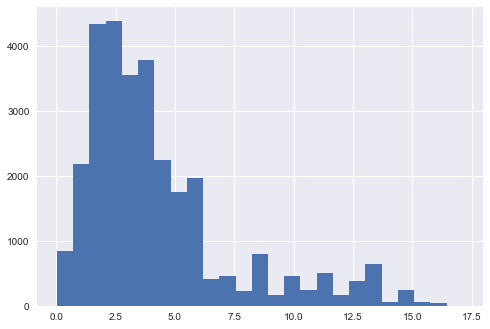

 | is numeric | 11843 unique values 

railroad_station_avto_min -- Feature 
count    30471.00
mean         6.09
std          4.79
min          0.04
25%          3.24
50%          4.94
75%          7.30
max         38.69
Name: railroad_station_avto_min, dtype: float64
0.035190944 21.6874563394


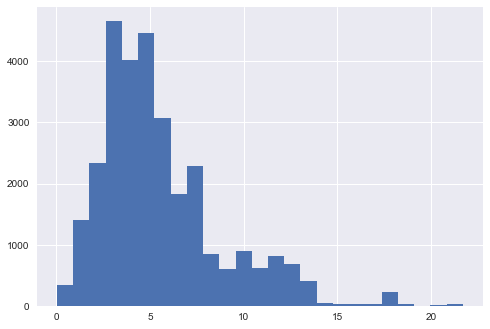

 | is numeric | 11843 unique values 

ID_railroad_station_avto -- Feature 
count    30471.00
mean        45.71
std         34.39
min          1.00
25%         19.00
50%         34.00
75%         73.00
max        138.00
Name: ID_railroad_station_avto, dtype: float64
1.0 138.0


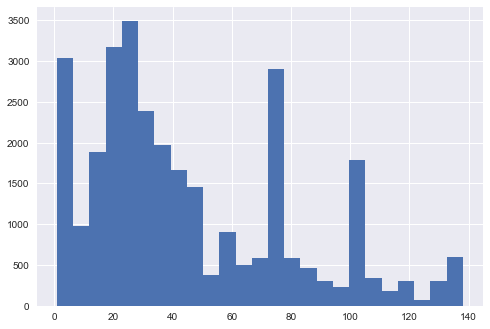

 | is numeric | 133 unique values  | consider one-hot? (ordinal?) 

public_transport_station_km -- Feature 
count    30471.00
mean         0.41
std          1.27
min          0.00
25%          0.10
50%          0.16
75%          0.28
max         17.41
Name: public_transport_station_km, dtype: float64
0.002803868 4.09586817699


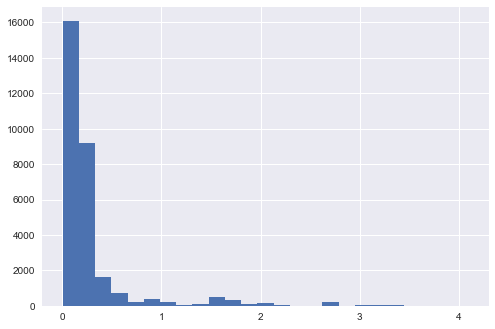

 | is numeric | 11851 unique values 

public_transport_station_min_walk -- Feature 
count    30471.00
mean         4.97
std         15.27
min          0.03
25%          1.22
50%          1.92
75%          3.34
max        208.96
Name: public_transport_station_min_walk, dtype: float64
0.033646415 49.1504181339


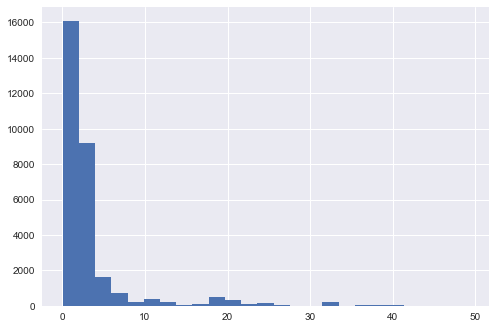

 | is numeric | 11852 unique values 

water_km -- Feature 
count    30471.00
mean         0.69
std          0.43
min          0.01
25%          0.34
50%          0.62
75%          0.96
max          2.83
Name: water_km, dtype: float64
0.006707311 2.26862184547


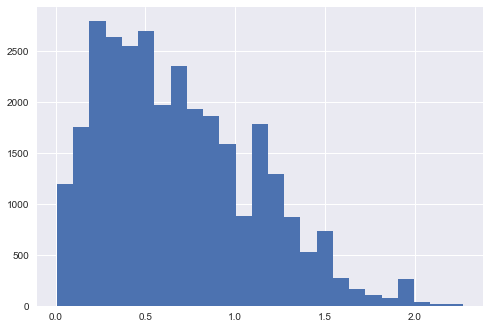

 | is numeric | 11851 unique values 

water_1line -- Feature 
 | is not numeric | 2 unique values  | consider one-hot?
Levels | Count | Mean | Median | std
             price_doc  price_doc  price_doc     price_doc
water_1line                                               
no               28134    7176112    6300000  4.802270e+06
yes               2337    6484065    5678100  4.456421e+06


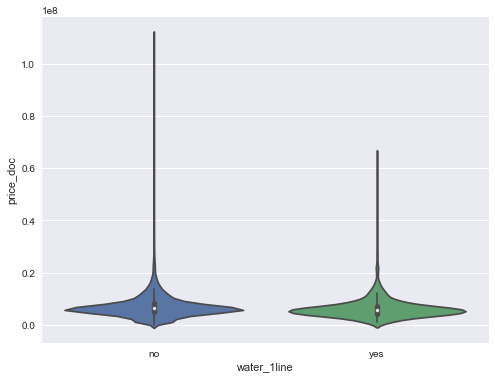


mkad_km -- Feature 
count    30471.00
mean         6.27
std          5.14
min          0.01
25%          2.63
50%          5.47
75%          8.18
max         53.28
Name: mkad_km, dtype: float64
0.013626182 23.6122281718


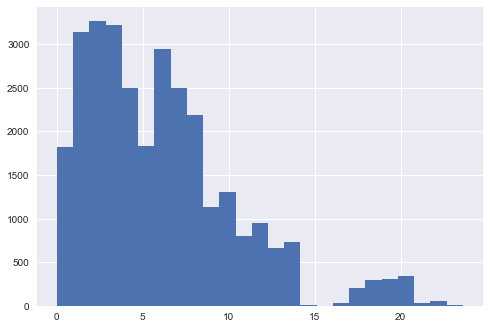

 | is numeric | 11852 unique values 

ttk_km -- Feature 
count    30471.00
mean        11.32
std          8.07
min          0.00
25%          5.34
50%          9.84
75%         15.68
max         66.03
Name: ttk_km, dtype: float64
0.001934755 39.8757951575


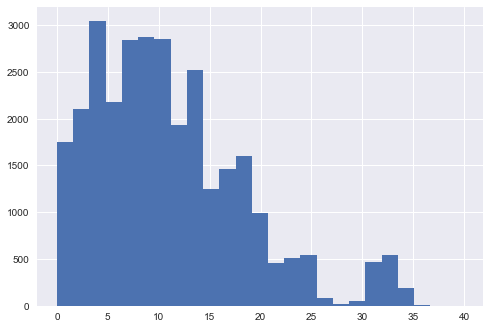

 | is numeric | 11852 unique values 

sadovoe_km -- Feature 
count    30471.00
mean        14.06
std          8.34
min          0.00
25%          8.35
50%         12.75
75%         18.72
max         68.85
Name: sadovoe_km, dtype: float64
0.000355499 43.7461057522


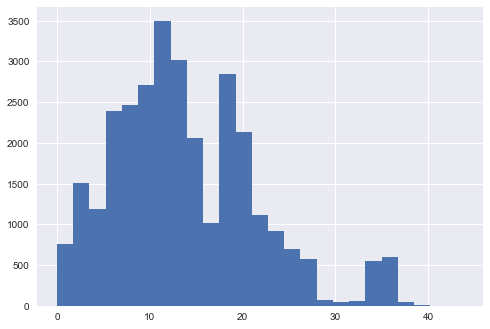

 | is numeric | 11852 unique values 

bulvar_ring_km -- Feature 
count    30471.00
mean        15.02
std          8.48
min          0.00
25%          9.26
50%         13.61
75%         19.95
max         69.98
Name: bulvar_ring_km, dtype: float64
0.001946827 45.3712185837


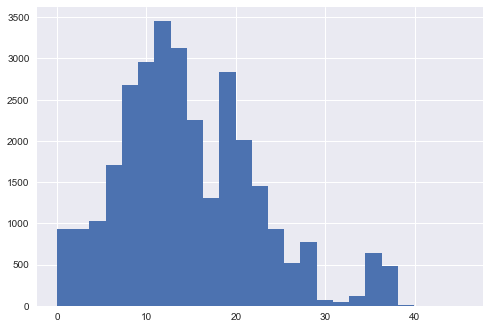

 | is numeric | 11852 unique values 

kremlin_km -- Feature 
count    30471.00
mean        16.04
std          8.44
min          0.07
25%         10.46
50%         14.88
75%         20.67
max         70.74
Name: kremlin_km, dtype: float64
0.072896553 45.9927072781


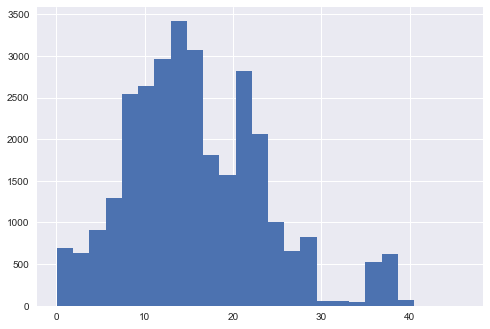

 | is numeric | 11852 unique values 

big_road1_km -- Feature 
count    30471.00
mean         1.88
std          1.30
min          0.00
25%          0.78
50%          1.72
75%          2.81
max          7.00
Name: big_road1_km, dtype: float64
0.000363832 6.6977616703


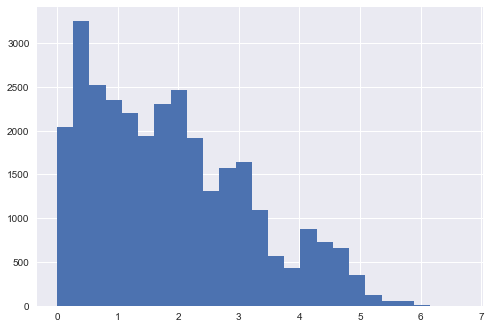

 | is numeric | 11852 unique values 

ID_big_road1 -- Feature 
count    30471.00
mean        11.52
std         11.35
min          1.00
25%          2.00
50%         10.00
75%         14.00
max         48.00
Name: ID_big_road1, dtype: float64
1.0 48.0


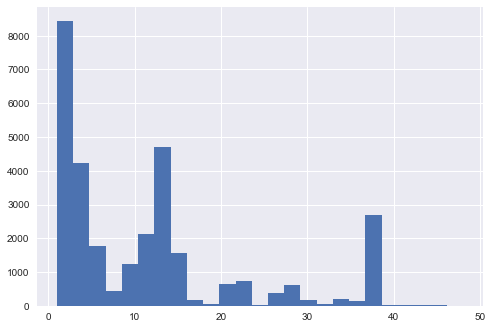

 | is numeric | 48 unique values  | consider one-hot? (ordinal?) 

big_road1_1line -- Feature 
 | is not numeric | 2 unique values  | consider one-hot?
Levels | Count | Mean | Median | std
                 price_doc  price_doc  price_doc     price_doc
big_road1_1line                                               
no                   29690    7075624    6250000  4.708860e+06
yes                    781    8925379    7150000  6.728661e+06


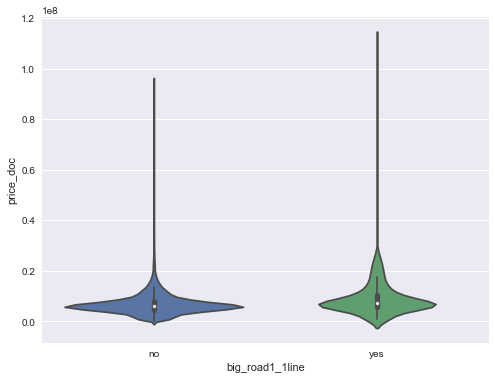


big_road2_km -- Feature 
count    30471.00
mean         3.40
std          1.87
min          0.00
25%          2.10
50%          3.21
75%          4.32
max         13.80
Name: big_road2_km, dtype: float64
0.00193473 9.93029359507


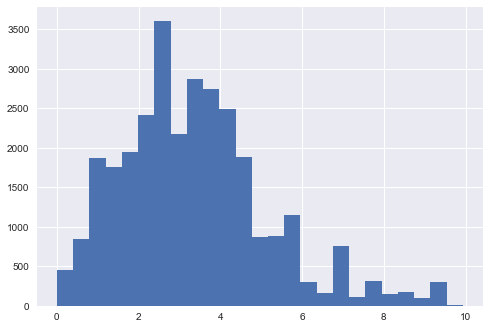

 | is numeric | 11852 unique values 

ID_big_road2 -- Feature 
count    30471.00
mean        22.41
std         17.39
min          1.00
25%          4.00
50%         21.00
75%         38.00
max         58.00
Name: ID_big_road2, dtype: float64
1.0 58.0


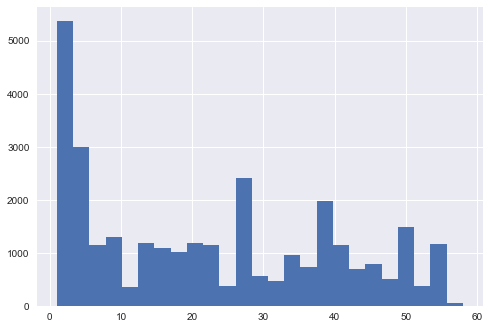

 | is numeric | 58 unique values  | consider one-hot? (ordinal?) 

railroad_km -- Feature 
count    30471.00
mean         1.89
std          1.97
min          0.00
25%          0.66
50%          1.24
75%          2.52
max         17.39
Name: railroad_km, dtype: float64
0.002299482 8.43888582838


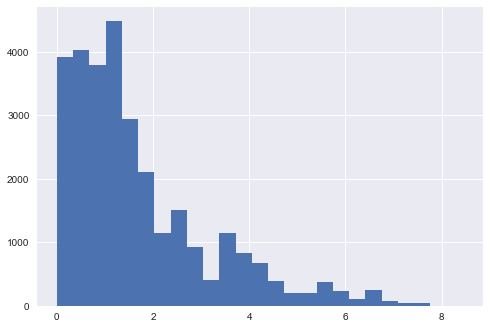

 | is numeric | 11852 unique values 

railroad_1line -- Feature 
 | is not numeric | 2 unique values  | consider one-hot?
Levels | Count | Mean | Median | std
                price_doc  price_doc  price_doc     price_doc
railroad_1line                                               
no                  29578    7144896    6300000  4.801364e+06
yes                   893    6398952    5500000  3.947451e+06


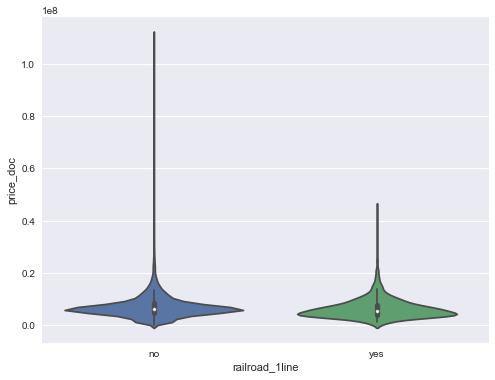


zd_vokzaly_avto_km -- Feature 
count    30471.00
mean        17.21
std         10.30
min          0.14
25%          9.99
50%         14.76
75%         24.06
max         91.22
Name: zd_vokzaly_avto_km, dtype: float64
0.136715439 54.9630280134


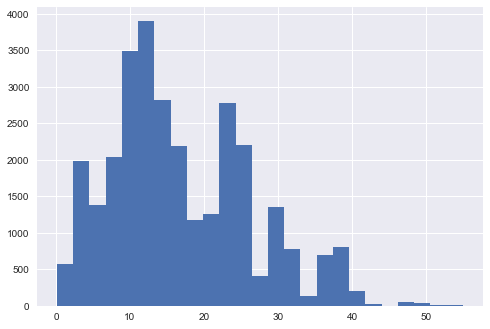

 | is numeric | 11843 unique values 

ID_railroad_terminal -- Feature 
count    30471.00
mean        51.67
std         35.34
min          5.00
25%         32.00
50%         50.00
75%         83.00
max        121.00
Name: ID_railroad_terminal, dtype: float64
5.0 121.0


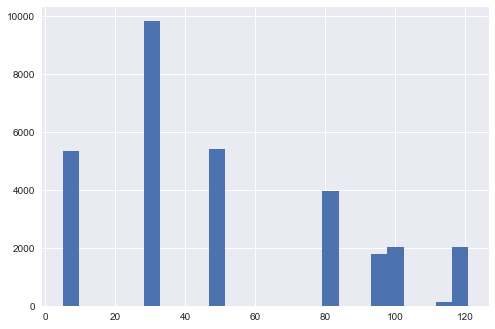

 | is numeric | 8 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                      price_doc  price_doc  price_doc     price_doc
ID_railroad_terminal                                               
5                          5345    6299979    6000000  3.060263e+06
32                         9813    7049784    6074821  4.737659e+06
50                         5414    6927093    5850576  5.402831e+06
83                         3959    8495780    7361890  5.992145e+06
97                         1794    7127645    6300000  4.422896e+06
101                        2016    7258722    6900000  3.889278e+06
113                         117   11851722   10000000  8.330579e+06
121                        2013    7077882    6460000  4.358062e+06


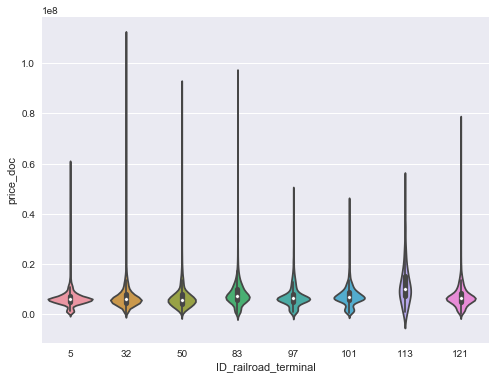


bus_terminal_avto_km -- Feature 
count    30471.00
mean         9.99
std          7.33
min          0.06
25%          5.21
50%          7.45
75%         13.28
max         74.80
Name: bus_terminal_avto_km, dtype: float64
0.062026031 35.279907375


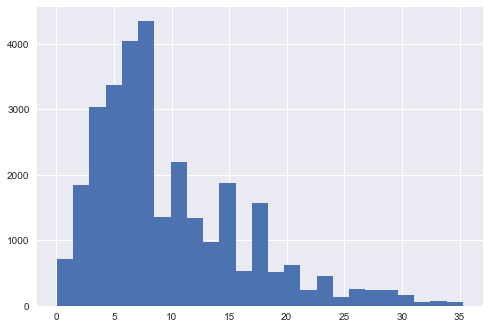

 | is numeric | 11843 unique values 

ID_bus_terminal -- Feature 
count    30471.00
mean         6.70
std          3.79
min          1.00
25%          3.00
50%          8.00
75%          9.00
max         14.00
Name: ID_bus_terminal, dtype: float64
1.0 14.0


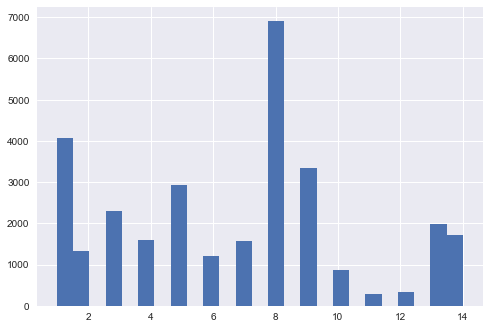

 | is numeric | 14 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                 price_doc  price_doc  price_doc     price_doc
ID_bus_terminal                                               
1                     4082    7480022    6800000  4.407065e+06
2                     1332    8489345    7600000  4.377625e+06
3                     2307    6226511    6000000  2.788995e+06
4                     1586    8806956    7500000  6.632301e+06
5                     2928    8602591    7384740  6.266039e+06
6                     1216    7015346    6700000  2.893830e+06
7                     1569    6828804    6300000  3.950520e+06
8                     6907    6342771    5522564  4.231546e+06
9                     3352    5820041    5500000  2.507083e+06
10                     872    6664746    6250000  3.412227e+06
11                     294    6710468    6500000  3.110789e+06
12                     338    5618358    5700000  2.086820e+06
13             

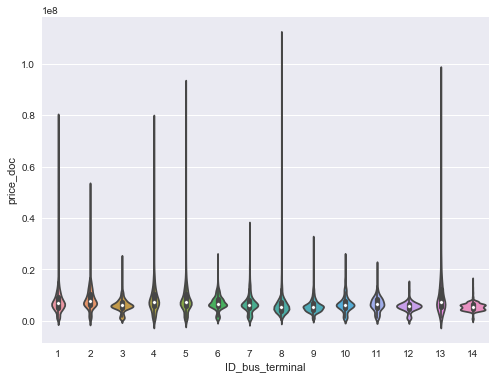


oil_chemistry_km -- Feature 
count    30471.00
mean        17.40
std         10.40
min          0.51
25%          8.72
50%         16.70
75%         23.42
max         70.41
Name: oil_chemistry_km, dtype: float64
0.510709937 54.6230472652


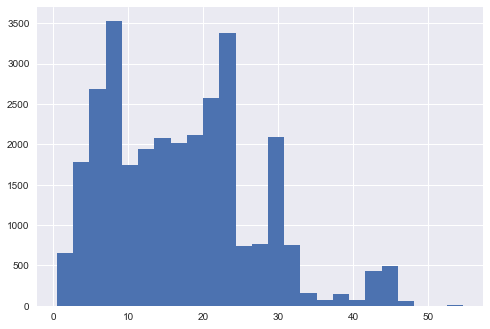

 | is numeric | 11852 unique values 

nuclear_reactor_km -- Feature 
count    30471.00
mean        10.95
std          7.25
min          0.31
25%          5.24
50%          8.97
75%         16.37
max         64.26
Name: nuclear_reactor_km, dtype: float64
0.309810795 38.1217780332


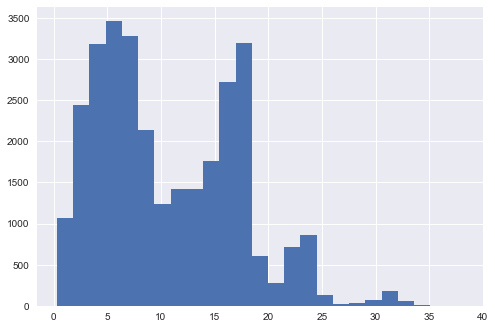

 | is numeric | 11852 unique values 

radiation_km -- Feature 
count    30471.00
mean         4.41
std          5.60
min          0.00
25%          1.23
50%          2.44
75%          4.69
max         53.89
Name: radiation_km, dtype: float64
0.004663282 21.473155516


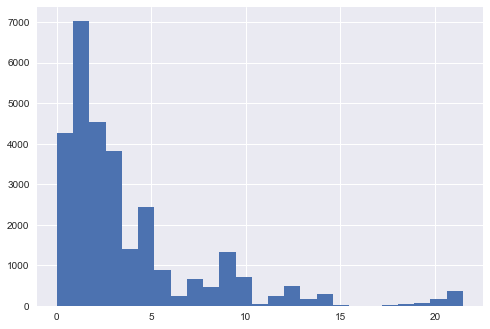

 | is numeric | 11852 unique values 

power_transmission_line_km -- Feature 
count    30471.00
mean         3.49
std          4.55
min          0.03
25%          0.98
50%          1.90
75%          4.93
max         43.32
Name: power_transmission_line_km, dtype: float64
0.030265937 18.5839605491


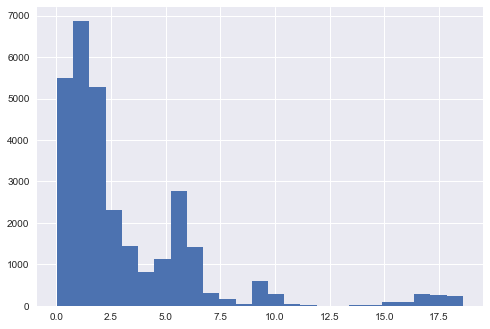

 | is numeric | 11852 unique values 

thermal_power_plant_km -- Feature 
count    30471.00
mean         7.34
std          5.62
min          0.40
25%          3.77
50%          5.89
75%          9.82
max         56.86
Name: thermal_power_plant_km, dtype: float64
0.400562974 26.6767105477


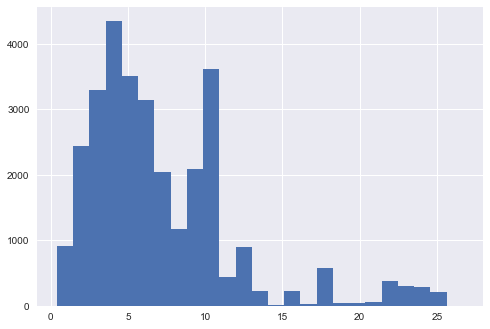

 | is numeric | 11852 unique values 

ts_km -- Feature 
count    30471.00
mean         4.93
std          4.80
min          0.00
25%          2.06
50%          3.97
75%          5.55
max         54.08
Name: ts_km, dtype: float64
0.0 19.9645703155


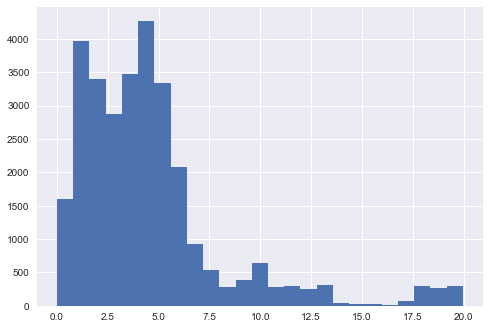

 | is numeric | 11849 unique values 

big_market_km -- Feature 
count    30471.00
mean        13.28
std          8.50
min          0.66
25%          7.53
50%         11.91
75%         16.56
max         59.50
Name: big_market_km, dtype: float64
0.66136622 42.0516761813


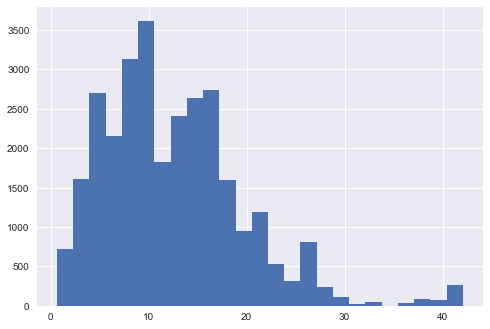

 | is numeric | 11843 unique values 

market_shop_km -- Feature 
count    30471.00
mean         3.96
std          3.45
min          0.00
25%          1.54
50%          2.93
75%          5.49
max         41.10
Name: market_shop_km, dtype: float64
0.003847146 15.8280319363


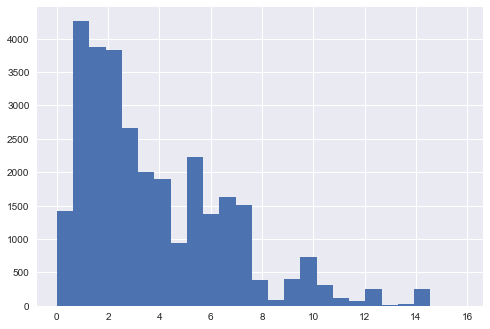

 | is numeric | 11843 unique values 

fitness_km -- Feature 
count    30471.00
mean         1.15
std          1.54
min          0.00
25%          0.36
50%          0.66
75%          1.33
max         26.65
Name: fitness_km, dtype: float64
0.0 5.95827057235


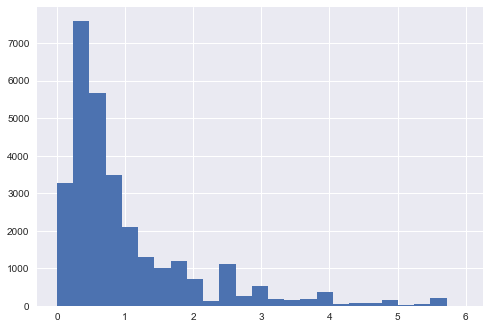

 | is numeric | 11775 unique values 

swim_pool_km -- Feature 
count    30471.00
mean         4.23
std          4.63
min          0.00
25%          1.71
50%          2.88
75%          5.37
max         53.36
Name: swim_pool_km, dtype: float64
0.0 19.2479187019


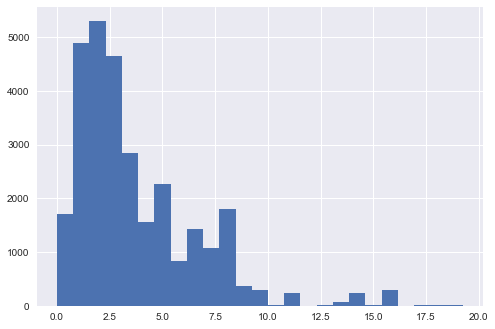

 | is numeric | 11843 unique values 

ice_rink_km -- Feature 
count    30471.00
mean         6.12
std          4.67
min          0.00
25%          3.04
50%          5.55
75%          7.96
max         46.04
Name: ice_rink_km, dtype: float64
0.0 21.9602959646


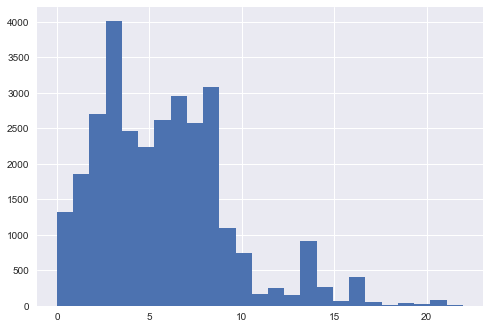

 | is numeric | 11843 unique values 

stadium_km -- Feature 
count    30471.00
mean         9.44
std          7.64
min          0.11
25%          4.02
50%          6.97
75%         13.59
max         83.40
Name: stadium_km, dtype: float64
0.114745597 36.5178846401


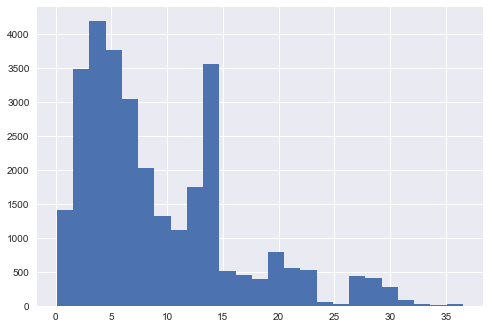

 | is numeric | 11843 unique values 

basketball_km -- Feature 
count    30471.00
mean         4.79
std          5.40
min          0.01
25%          1.31
50%          2.88
75%          6.36
max         56.70
Name: basketball_km, dtype: float64
0.005458234 22.5509292701


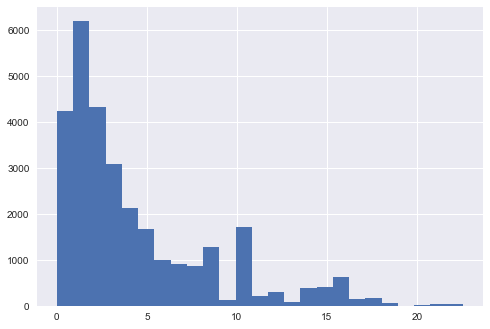

 | is numeric | 11852 unique values 

hospice_morgue_km -- Feature 
count    30471.00
mean         2.65
std          2.95
min          0.00
25%          1.12
50%          1.90
75%          3.30
max         43.69
Name: hospice_morgue_km, dtype: float64
0.002516713 12.1545487548


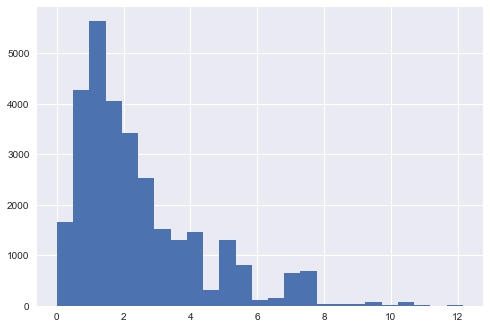

 | is numeric | 11852 unique values 

detention_facility_km -- Feature 
count    30471.00
mean        14.55
std         11.08
min          0.04
25%          5.67
50%         11.31
75%         24.88
max         89.37
Name: detention_facility_km, dtype: float64
0.041227084 58.1227751395


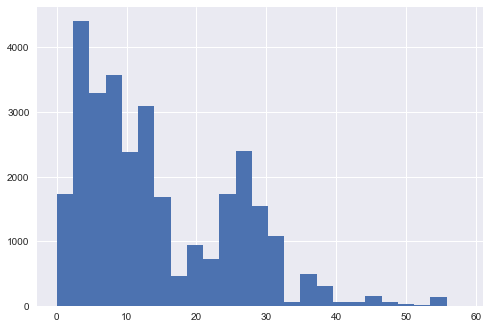

 | is numeric | 11843 unique values 

public_healthcare_km -- Feature 
count    30471.00
mean         3.36
std          4.34
min          0.00
25%          1.28
50%          2.34
75%          3.98
max         76.06
Name: public_healthcare_km, dtype: float64
0.0 17.0093157408


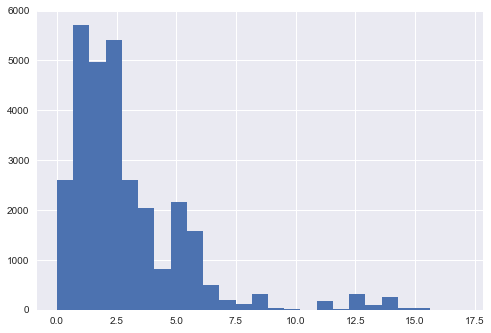

 | is numeric | 11843 unique values 

university_km -- Feature 
count    30471.00
mean         6.86
std          6.73
min          0.00
25%          2.20
50%          4.34
75%          9.38
max         84.86
Name: university_km, dtype: float64
0.000313421 29.5747208385


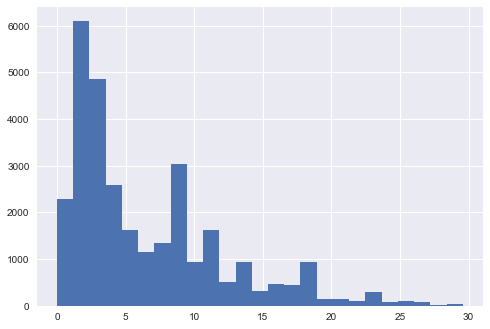

 | is numeric | 11843 unique values 

workplaces_km -- Feature 
count    30471.00
mean         3.93
std          4.91
min          0.00
25%          1.02
50%          2.03
75%          5.42
max         55.28
Name: workplaces_km, dtype: float64
0.0 20.1383479568


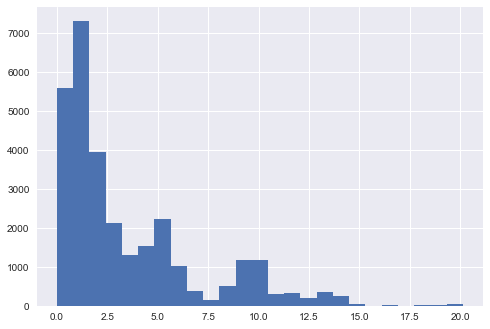

 | is numeric | 11844 unique values 

shopping_centers_km -- Feature 
count    30471.00
mean         1.51
std          2.25
min          0.00
25%          0.48
50%          0.84
75%          1.55
max         26.26
Name: shopping_centers_km, dtype: float64
0.0 8.31079465366


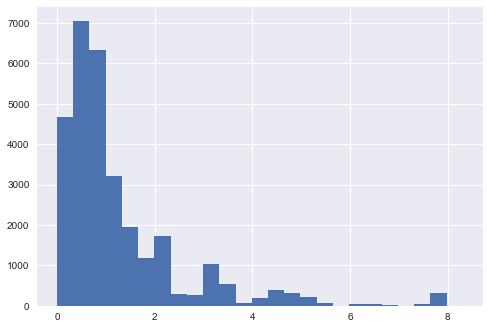

 | is numeric | 11813 unique values 

office_km -- Feature 
count    30471.00
mean         2.01
std          2.31
min          0.00
25%          0.56
50%          1.05
75%          3.05
max         18.96
Name: office_km, dtype: float64
0.0 9.96602491048


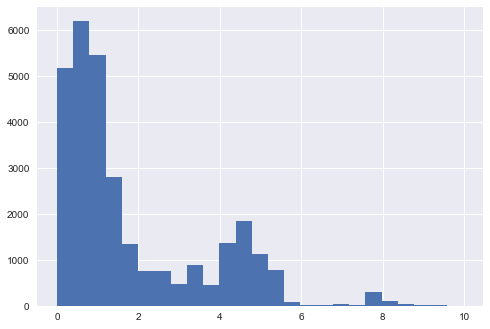

 | is numeric | 11806 unique values 

additional_education_km -- Feature 
count    30471.00
mean         1.33
std          1.53
min          0.00
25%          0.47
50%          0.90
75%          1.57
max         24.27
Name: additional_education_km, dtype: float64
0.0 6.14971911427


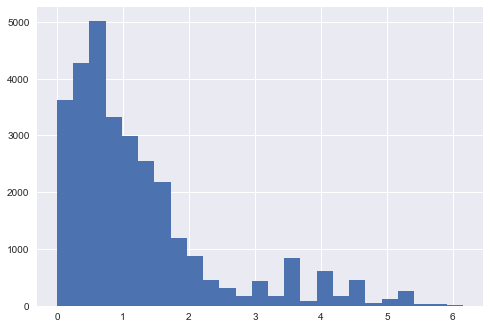

 | is numeric | 11843 unique values 

preschool_km -- Feature 
count    30471.00
mean         1.35
std          3.05
min          0.00
25%          0.29
50%          0.49
75%          0.94
max         47.39
Name: preschool_km, dtype: float64
0.0 10.0971249317


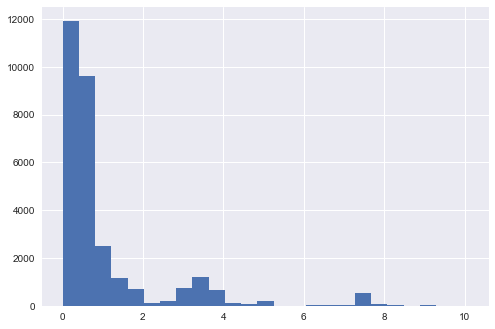

 | is numeric | 11828 unique values 

big_church_km -- Feature 
count    30471.00
mean         2.33
std          2.99
min          0.00
25%          0.86
50%          1.49
75%          2.92
max         45.67
Name: big_church_km, dtype: float64
0.004071872 11.8830741548


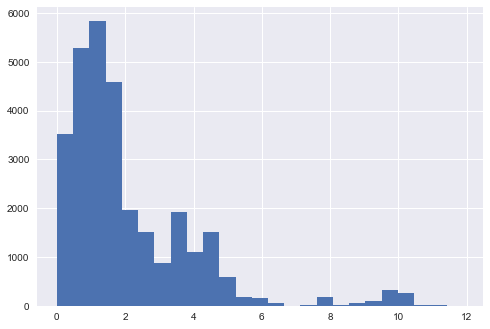

 | is numeric | 11852 unique values 

church_synagogue_km -- Feature 
count    30471.00
mean         0.97
std          0.75
min          0.00
25%          0.53
50%          0.86
75%          1.25
max         15.62
Name: church_synagogue_km, dtype: float64
0.0 3.49510733115


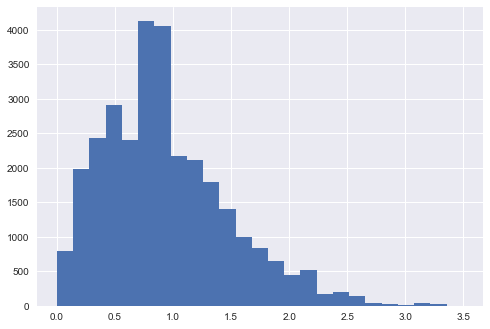

 | is numeric | 11852 unique values 

mosque_km -- Feature 
count    30471.00
mean         7.74
std          5.78
min          0.01
25%          3.77
50%          6.54
75%         10.05
max         44.85
Name: mosque_km, dtype: float64
0.005544522 27.3883182828


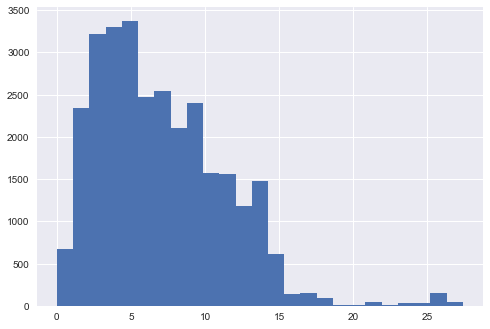

 | is numeric | 11852 unique values 

theater_km -- Feature 
count    30471.00
mean         9.64
std          7.11
min          0.03
25%          4.23
50%          8.61
75%         13.46
max         87.60
Name: theater_km, dtype: float64
0.026788074 34.7964449715


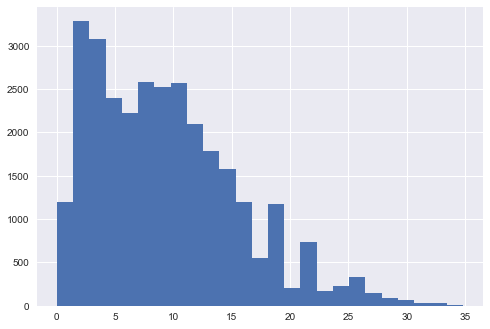

 | is numeric | 11843 unique values 

museum_km -- Feature 
count    30471.00
mean         7.06
std          5.70
min          0.01
25%          2.88
50%          5.64
75%         10.33
max         59.20
Name: museum_km, dtype: float64
0.007902693 27.4370073076


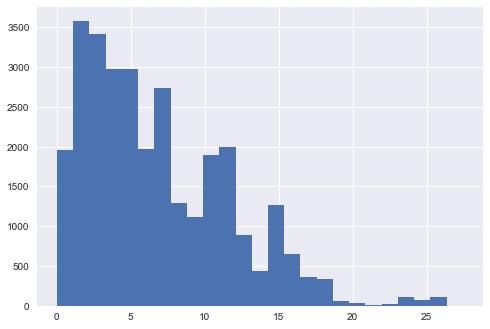

 | is numeric | 11852 unique values 

exhibition_km -- Feature 
count    30471.00
mean         5.55
std          5.30
min          0.01
25%          2.24
50%          4.11
75%          6.97
max         54.43
Name: exhibition_km, dtype: float64
0.008949292 22.8813207063


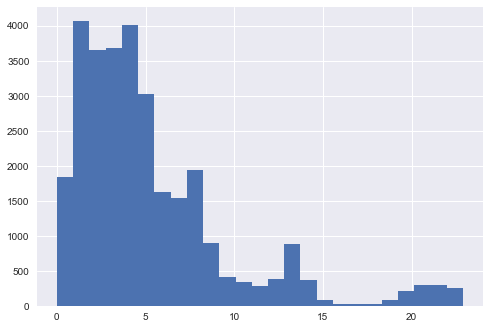

 | is numeric | 11852 unique values 

catering_km -- Feature 
count    30471.00
mean         0.69
std          0.83
min          0.00
25%          0.21
50%          0.41
75%          0.84
max         12.16
Name: catering_km, dtype: float64
0.000356696 3.34018329585


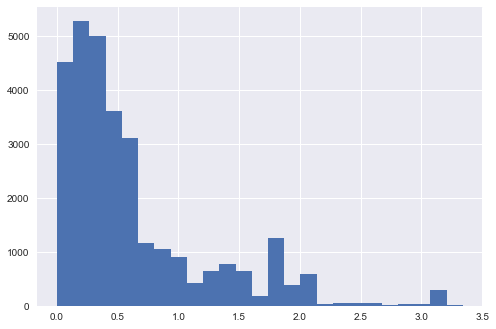

 | is numeric | 11852 unique values 

ecology -- Feature 
 | is not numeric | 5 unique values  | consider one-hot?
Levels | Count | Mean | Median | std
              price_doc  price_doc  price_doc     price_doc
ecology                                                    
excellent          3938    8201252    6750000  6.346794e+06
good               7174    7082094    6415200  3.937674e+06
no data            7656    5241629    5000675  1.925151e+06
poor               8018    7747995    6774500  5.127922e+06
satisfactory       3685    8599506    7200000  6.260212e+06


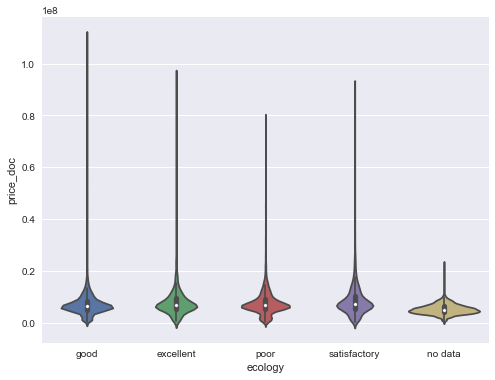


green_part_500 -- Feature 
count    30471.00
mean        13.38
std         16.05
min          0.00
25%          1.48
50%          8.38
75%         19.92
max        100.00
Name: green_part_500, dtype: float64
0.0 68.0733559957


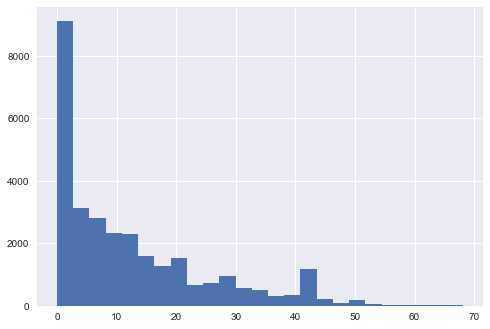

 | is numeric | 3313 unique values 

prom_part_500 -- Feature 
count    30471.00
mean         5.72
std         11.54
min          0.00
25%          0.00
50%          0.00
75%          5.76
max         98.77
Name: prom_part_500, dtype: float64
0.0 40.3911920128


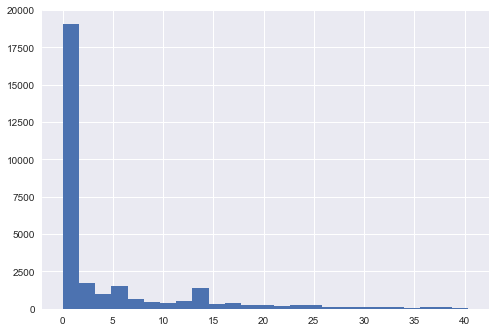

 | is numeric | 2571 unique values 

office_count_500 -- Feature 
count    30471.00
mean         0.74
std          2.28
min          0.00
25%          0.00
50%          0.00
75%          0.00
max         34.00
Name: office_count_500, dtype: float64
0.0 6.8501113797


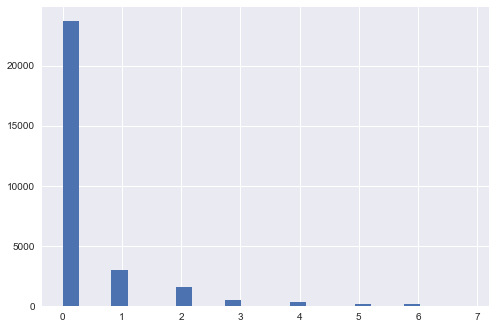

 | is numeric | 30 unique values  | consider one-hot? (ordinal?) 

office_sqm_500 -- Feature 
count     30471.0
mean      13983.0
std       42610.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max      611015.0
Name: office_sqm_500, dtype: float64
0.0 127830.055441


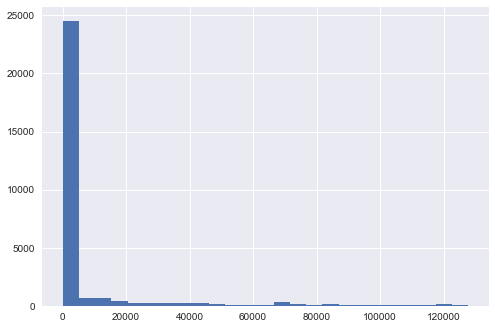

 | is numeric | 1070 unique values  | consider one-hot? (ordinal?) 

trc_count_500 -- Feature 
count    30471.00
mean         0.56
std          1.25
min          0.00
25%          0.00
50%          0.00
75%          1.00
max          8.00
Name: trc_count_500, dtype: float64
0.0 4.73826793626


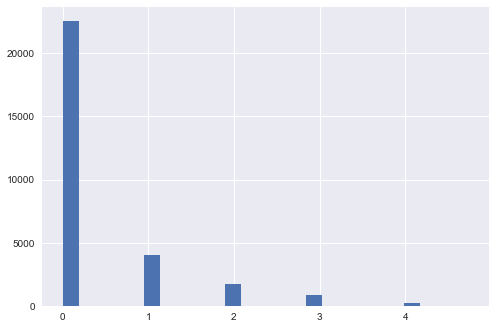

 | is numeric | 9 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
               price_doc  price_doc  price_doc     price_doc
trc_count_500                                               
0                  22546    6789296    6000000  4.443399e+06
1                   4029    8318628    7200000  5.976019e+06
2                   1758    7945386    7000000  5.169955e+06
3                    866    7956371    7025000  4.872752e+06
4                    219    9478258    7700000  6.451738e+06
5                    368    8974877    8416276  4.150277e+06
6                    644    5938698    5477420  3.332632e+06
7                     37    7844858    7980000  4.402597e+06
8                      4   26825000   17400000  2.236267e+07


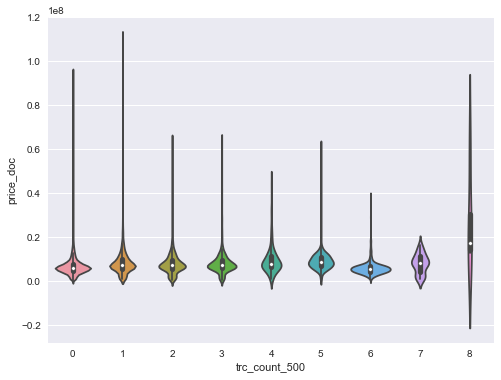


trc_sqm_500 -- Feature 
count      30471.0
mean       21797.0
std        81580.0
min            0.0
25%            0.0
50%            0.0
75%          120.0
max      1500000.0
Name: trc_sqm_500, dtype: float64
0.0 244860.465686


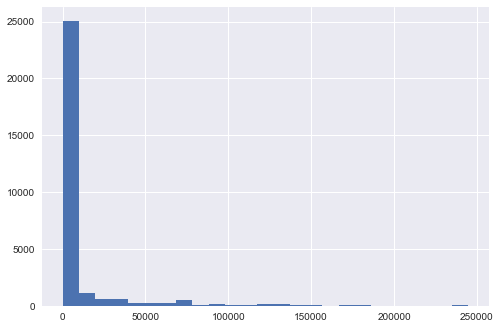

 | is numeric | 500 unique values  | consider one-hot? (ordinal?) 

cafe_count_500 -- Feature 
count    30471.00
mean         3.87
std         11.28
min          0.00
25%          0.00
50%          1.00
75%          3.00
max        120.00
Name: cafe_count_500, dtype: float64
0.0 36.8517574669


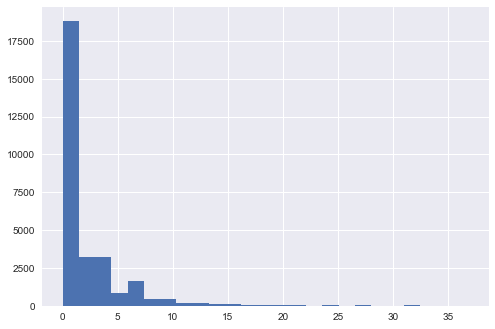

 | is numeric | 95 unique values  | consider one-hot? (ordinal?) 

cafe_sum_500_min_price_avg -- Feature 
count    17190.0
mean       741.0
std        341.0
min        300.0
25%        500.0
50%        667.0
75%        955.0
max       4000.0
Name: cafe_sum_500_min_price_avg, dtype: float64
300.0 1978.12800838


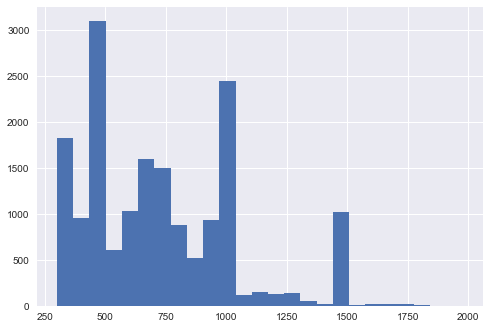

 | NaN 0.44 | is numeric | 656 unique values  | consider one-hot? (ordinal?) 

cafe_sum_500_max_price_avg -- Feature 
count    17190.0
mean      1247.0
std        527.0
min        500.0
25%       1000.0
50%       1167.0
75%       1500.0
max       6000.0
Name: cafe_sum_500_max_price_avg, dtype: float64
500.0 3079.61747595


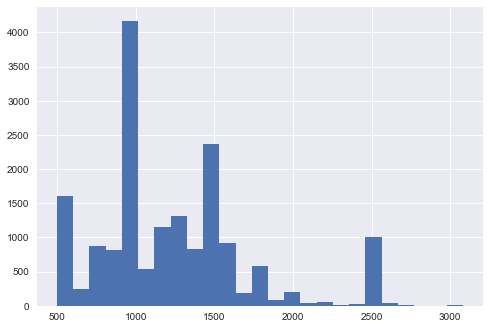

 | NaN 0.44 | is numeric | 447 unique values  | consider one-hot? (ordinal?) 

cafe_avg_price_500 -- Feature 
count    17190.0
mean       994.0
std        433.0
min        400.0
25%        750.0
50%        917.0
75%       1250.0
max       5000.0
Name: cafe_avg_price_500, dtype: float64
400.0 2547.54614707


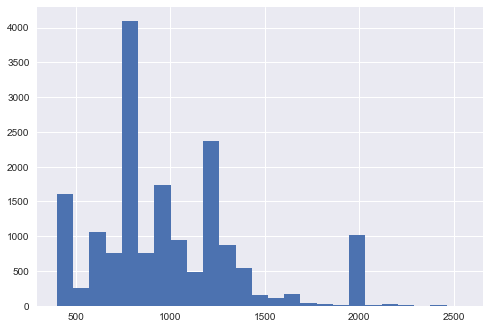

 | NaN 0.44 | is numeric | 861 unique values  | consider one-hot? (ordinal?) 

cafe_count_500_na_price -- Feature 
count    30471.00
mean         0.34
std          1.36
min          0.00
25%          0.00
50%          0.00
75%          0.00
max         13.00
Name: cafe_count_500_na_price, dtype: float64
0.0 4.07509716824


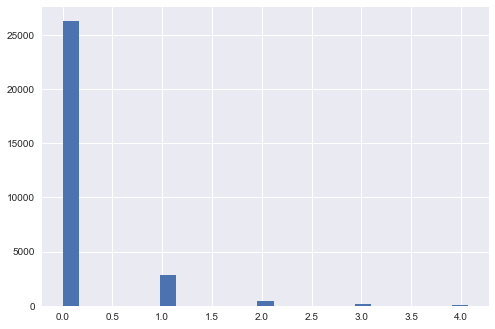

 | is numeric | 13 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                         price_doc  price_doc  price_doc     price_doc
cafe_count_500_na_price                                               
0                            26270    6853434    6150300  4.201853e+06
1                             2843    8509839    7250000  6.087671e+06
2                              447   11450858    8625000  1.010150e+07
3                              124   12684745    8100000  1.148146e+07
4                              105   13673625   10000000  1.342991e+07
5                               42   14404830   11775000  1.025985e+07
6                                8    9744625    7433500  1.081650e+07
7                               12   16234811   15850000  7.820554e+06
8                                3   34260000   45640000  1.971074e+07
9                              610    5873167    5368256  3.374589e+06
10                               4   13035000

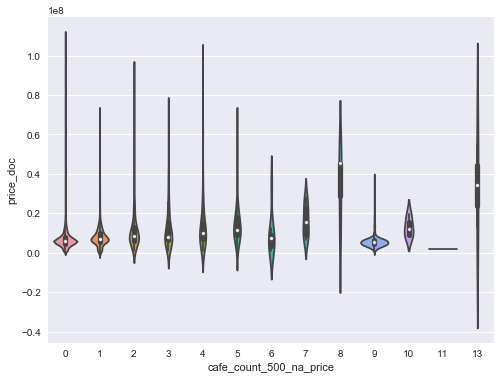


cafe_count_500_price_500 -- Feature 
count    30471.00
mean         0.99
std          3.06
min          0.00
25%          0.00
50%          0.00
75%          1.00
max         33.00
Name: cafe_count_500_price_500, dtype: float64
0.0 10.1813015861


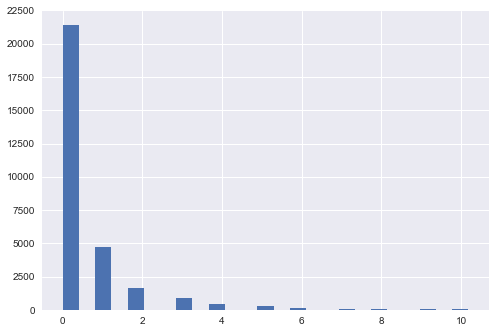

 | is numeric | 33 unique values  | consider one-hot? (ordinal?) 

cafe_count_500_price_1000 -- Feature 
count    30471.00
mean         0.98
std          2.27
min          0.00
25%          0.00
50%          0.00
75%          1.00
max         39.00
Name: cafe_count_500_price_1000, dtype: float64
0.0 7.80544525572


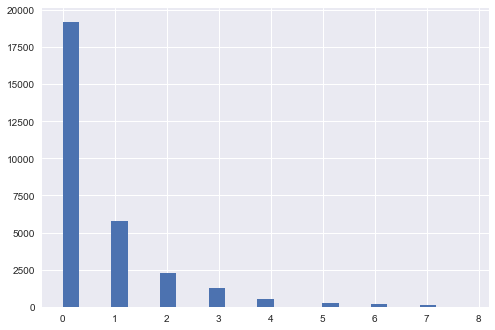

 | is numeric | 32 unique values  | consider one-hot? (ordinal?) 

cafe_count_500_price_1500 -- Feature 
count    30471.00
mean         0.84
std          2.32
min          0.00
25%          0.00
50%          0.00
75%          1.00
max         29.00
Name: cafe_count_500_price_1500, dtype: float64
0.0 7.95559969895


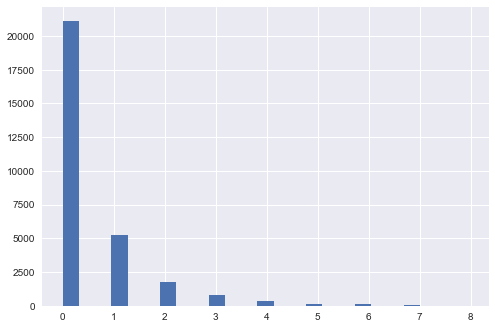

 | is numeric | 29 unique values  | consider one-hot? (ordinal?) 

cafe_count_500_price_2500 -- Feature 
count    30471.00
mean         0.54
std          2.14
min          0.00
25%          0.00
50%          0.00
75%          0.00
max         22.00
Name: cafe_count_500_price_2500, dtype: float64
0.0 6.41211209979


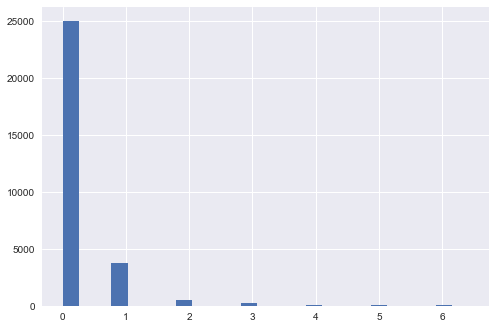

 | is numeric | 21 unique values  | consider one-hot? (ordinal?) 

cafe_count_500_price_4000 -- Feature 
count    30471.00
mean         0.14
std          0.69
min          0.00
25%          0.00
50%          0.00
75%          0.00
max         14.00
Name: cafe_count_500_price_4000, dtype: float64
0.0 2.0675504459


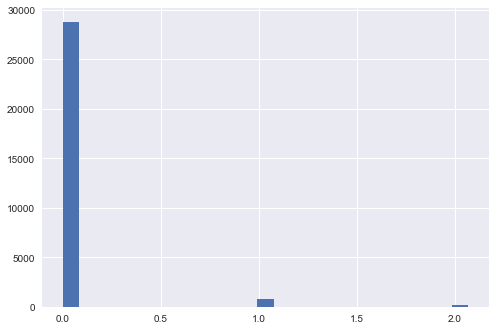

 | is numeric | 14 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                           price_doc  price_doc  price_doc     price_doc
cafe_count_500_price_4000                                               
0                              28760    6975060    6250000  4.386402e+06
1                                785   10521425    8100000  8.500202e+06
2                                163   13697073   10600000  1.081710e+07
3                                 91   13416729   10850000  1.191509e+07
4                                630    6446446    5457369  5.986432e+06
5                                 16   15435077   10307710  1.407682e+07
6                                  2   42125000   42125000  3.942120e+07
7                                  2   10995000   10995000  5.649783e+06
8                                  7   14950000   12000000  1.205014e+07
9                                  6   14266666   13350000  4.105444e+06
10                   

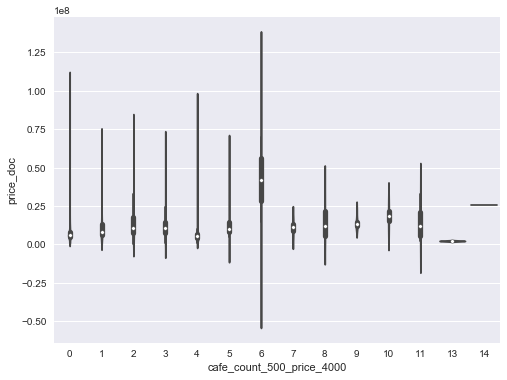


cafe_count_500_price_high -- Feature 
count    30471.00
mean         0.03
std          0.18
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          3.00
Name: cafe_count_500_price_high, dtype: float64
0.0 0.546639283778


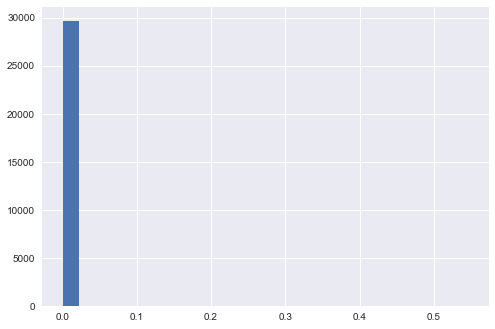

 | is numeric | 4 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                           price_doc  price_doc  price_doc     price_doc
cafe_count_500_price_high                                               
0                              29635    7095528    6289920  4.685750e+06
1                                787    7560382    5899500  5.963621e+06
2                                 38   15374157   13150000  1.225435e+07
3                                 11   21433863   12500000  2.654925e+07


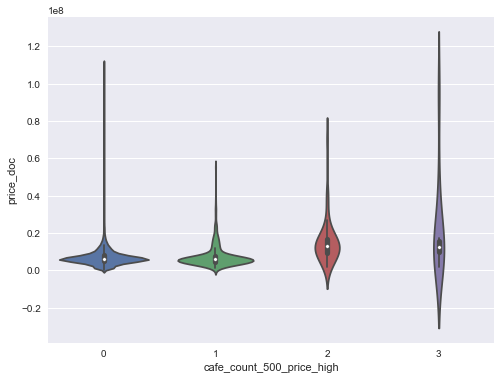


big_church_count_500 -- Feature 
count    30471.00
mean         0.29
std          1.19
min          0.00
25%          0.00
50%          0.00
75%          0.00
max         11.00
Name: big_church_count_500, dtype: float64
0.0 3.55586487532


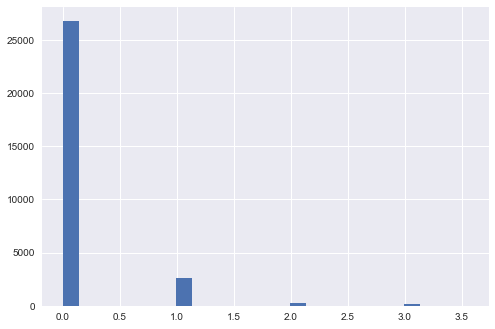

 | is numeric | 11 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                      price_doc  price_doc  price_doc     price_doc
big_church_count_500                                               
0                         26758    6910948    6189152  4.459251e+06
1                          2657    8809714    7600000  5.961653e+06
2                           253    9659788    8500000  7.438292e+06
3                           126   13414431    9225000  1.227159e+07
4                            38   14193535   11175000  1.300574e+07
5                            21   14538571   13500000  7.575771e+06
6                            10   13638363   10040000  1.616747e+07
7                             2   25633800   25633800  1.932099e+06
8                           603    5842008    5363268  3.333257e+06
10                            2    8875067    8875067  2.651556e+06
11                            1    8500000    8500000           NaN


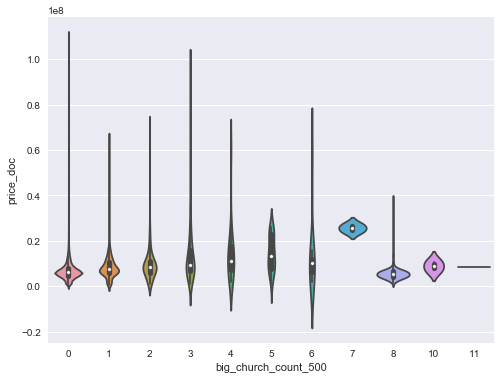


church_count_500 -- Feature 
count    30471.00
mean         0.58
std          2.16
min          0.00
25%          0.00
50%          0.00
75%          0.00
max         17.00
Name: church_count_500, dtype: float64
0.0 6.49147496854


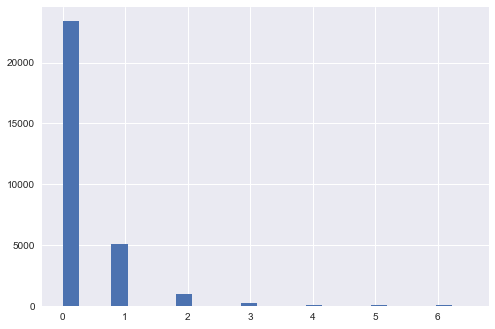

 | is numeric | 15 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                  price_doc  price_doc  price_doc     price_doc
church_count_500                                               
0                     23415    6919502    6200000  4.349309e+06
1                      5103    7367721    6300000  4.971466e+06
2                       934    9131775    7389480  7.614358e+06
3                       193   10958581    9100000  8.749430e+06
4                        94   14503698   10875000  1.302894e+07
5                        70   13657388   10619312  1.108972e+07
6                        28   13934867   13515000  9.028095e+06
7                        12   17084083   16700000  9.165562e+06
8                         7   19978571   22500000  6.794536e+06
9                         4   22925000   12500000  2.368028e+07
10                        3   12326666   11600000  3.153432e+06
11                        1   24267600   24267600           NaN
1

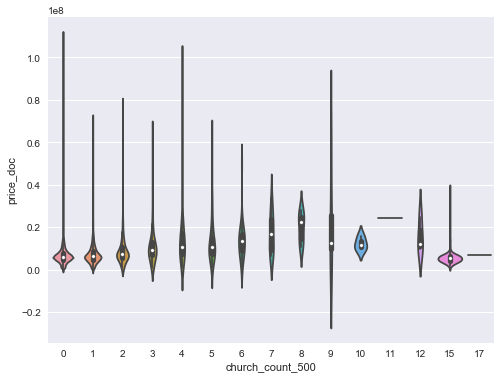


mosque_count_500 -- Feature 
count    30471.00
mean         0.00
std          0.07
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: mosque_count_500, dtype: float64
0.0 0.209273255303


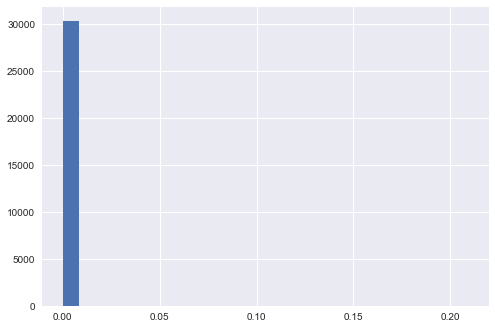

 | is numeric | 2 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                  price_doc  price_doc  price_doc     price_doc
mosque_count_500                                               
0                     30322    7116845    6271200  4.778399e+06
1                       149    8382746    7600000  4.975190e+06


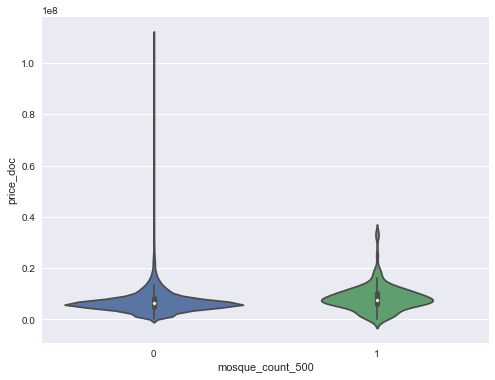


leisure_count_500 -- Feature 
count    30471.00
mean         0.07
std          0.39
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          9.00
Name: leisure_count_500, dtype: float64
0.0 1.15917899099


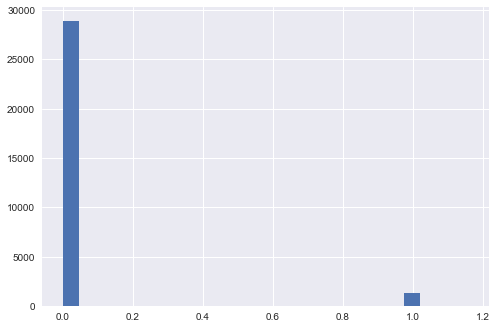

 | is numeric | 10 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                   price_doc  price_doc  price_doc     price_doc
leisure_count_500                                               
0                      28901    6980112    6229540  4.436258e+06
1                       1299    9034489    6850000  7.463158e+06
2                        133   12132111   10000000  9.042452e+06
3                         54   10955851    9250000  8.940252e+06
4                         54   11841900    7158500  1.313297e+07
5                          9   16920555   17400000  1.022255e+07
6                          4   27189500   25379000  2.246297e+07
7                          6   47570416   42000000  2.748015e+07
8                          2   18400000   18400000  1.187939e+07
9                          9   16674309   18500000  9.293222e+06


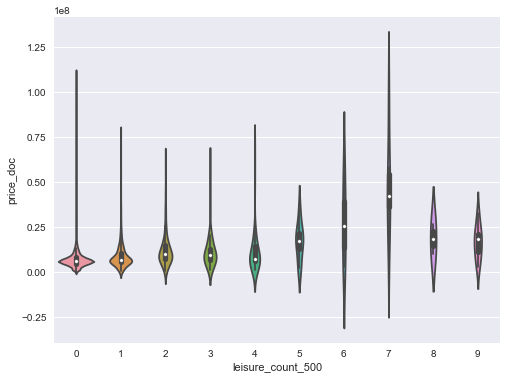


sport_count_500 -- Feature 
count    30471.00
mean         0.91
std          1.64
min          0.00
25%          0.00
50%          0.00
75%          1.00
max         11.00
Name: sport_count_500, dtype: float64
0.0 5.91642699504


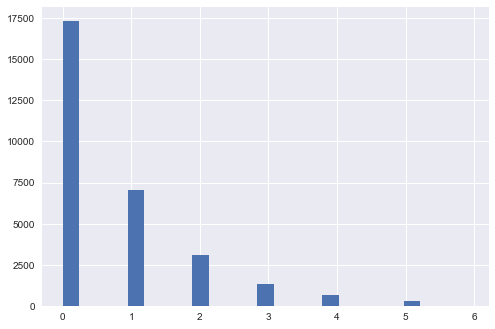

 | is numeric | 12 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                 price_doc  price_doc  price_doc     price_doc
sport_count_500                                               
0                    17327    6460631    5877000  3.790302e+06
1                     7041    7698542    6750000  5.164606e+06
2                     3089    8550677    7259647  6.165624e+06
3                     1302    8425101    7125000  6.717432e+06
4                      654    8541692    7300000  7.176391e+06
5                      265    9091202    7400000  6.249389e+06
6                       79   10077066    8300000  7.728923e+06
7                       52   10701087   11050000  5.432625e+06
8                       18   11676944    9750000  8.506756e+06
9                      625    5923158    5411262  3.436783e+06
10                      17   13473529   13000000  5.869761e+06
11                       2   12750000   12750000  4.596194e+06


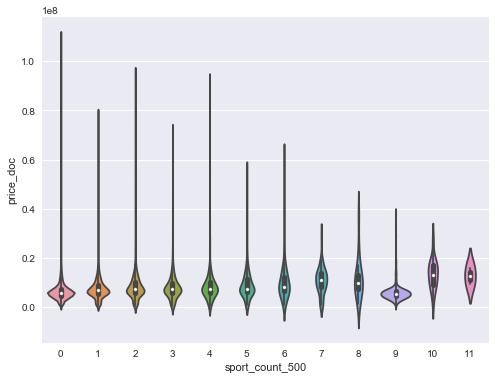


market_count_500 -- Feature 
count    30471.00
mean         0.12
std          0.40
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          4.00
Name: market_count_500, dtype: float64
0.0 1.20311821556


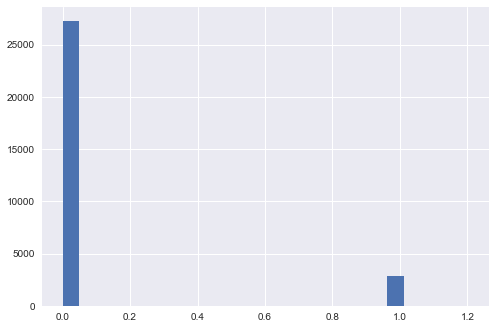

 | is numeric | 5 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                  price_doc  price_doc  price_doc     price_doc
market_count_500                                               
0                     27253    7075281    6200000  4.785691e+06
1                      2834    7470127    6650000  4.638413e+06
2                       281    6938727    6500000  3.912571e+06
3                        34    7075000    7275000  2.693124e+06
4                        69   12502551   10586822  7.847606e+06


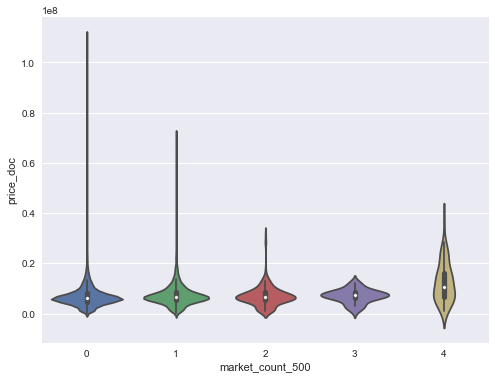


green_part_1000 -- Feature 
count    30471.00
mean        16.96
std         14.51
min          0.00
25%          6.31
50%         13.04
75%         24.18
max        100.00
Name: green_part_1000, dtype: float64
0.0 67.7248992076


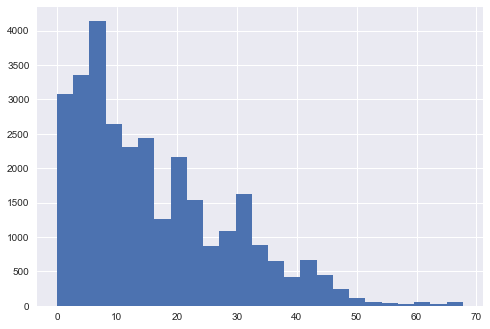

 | is numeric | 3735 unique values 

prom_part_1000 -- Feature 
count    30471.00
mean         8.78
std         11.52
min          0.00
25%          0.00
50%          4.02
75%         12.62
max         72.20
Name: prom_part_1000, dtype: float64
0.0 47.1731658186


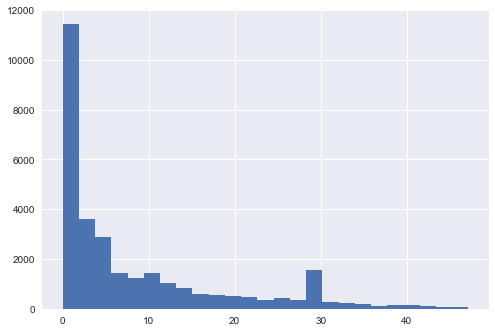

 | is numeric | 3175 unique values 

office_count_1000 -- Feature 
count    30471.00
mean         3.09
std          8.88
min          0.00
25%          0.00
50%          0.00
75%          2.00
max         91.00
Name: office_count_1000, dtype: float64
0.0 28.6352558882


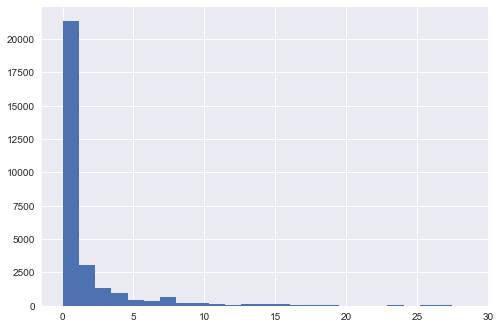

 | is numeric | 84 unique values  | consider one-hot? (ordinal?) 

office_sqm_1000 -- Feature 
count      30471.0
mean       62267.0
std       143853.0
min            0.0
25%            0.0
50%            0.0
75%        54500.0
max      2244723.0
Name: office_sqm_1000, dtype: float64
0.0 486058.891647


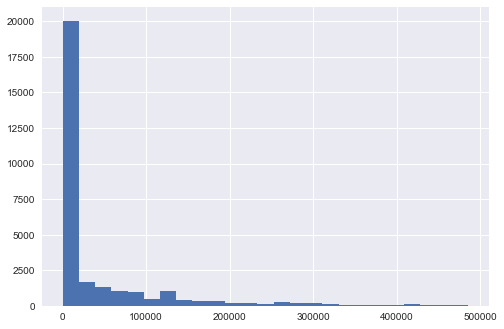

 | is numeric | 1942 unique values 

trc_count_1000 -- Feature 
count    30471.00
mean         1.98
std          3.25
min          0.00
25%          0.00
50%          1.00
75%          3.00
max         20.00
Name: trc_count_1000, dtype: float64
0.0 12.7389833803


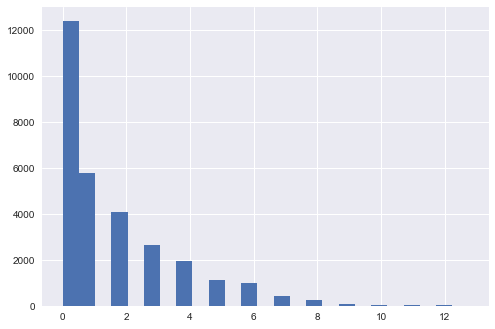

 | is numeric | 19 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                price_doc  price_doc  price_doc     price_doc
trc_count_1000                                               
0                   12407    6078258    5625900  3.235253e+06
1                    5800    7479359    6350000  5.501356e+06
2                    4083    7587688    6800000  4.790473e+06
3                    2643    8681449    7200000  6.706186e+06
4                    1966    7875591    6953562  5.162242e+06
5                    1128    8110021    7050000  4.958510e+06
6                     991    8732938    8016840  5.285882e+06
7                     413    8227865    7350000  5.775649e+06
8                     243    8431733    7600000  5.040838e+06
9                      83    9582598    8100000  6.044855e+06
10                     39   15383332   12112500  1.324040e+07
11                     26    9250769    8945000  4.300153e+06
12                     23    

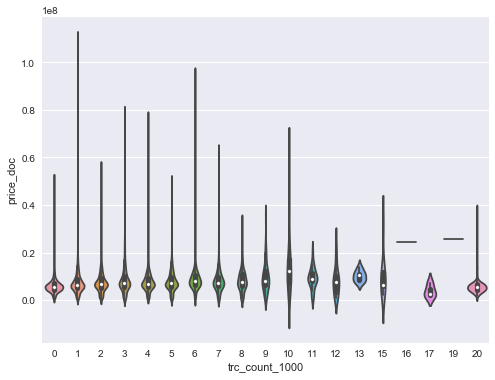


trc_sqm_1000 -- Feature 
count      30471.0
mean       65881.0
std       150280.0
min            0.0
25%            0.0
50%         7800.0
75%        67183.0
max      1500000.0
Name: trc_sqm_1000, dtype: float64
0.0 518021.963317


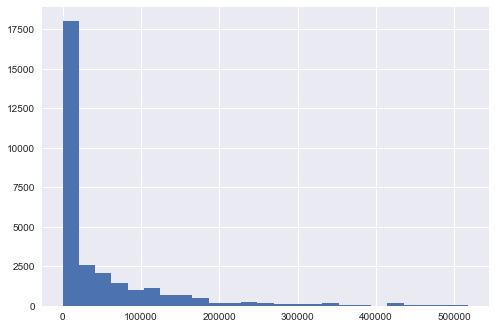

 | is numeric | 1063 unique values  | consider one-hot? (ordinal?) 

cafe_count_1000 -- Feature 
count    30471.00
mean        15.41
std         47.63
min          0.00
25%          1.00
50%          4.00
75%         11.00
max        449.00
Name: cafe_count_1000, dtype: float64
0.0 153.891823089


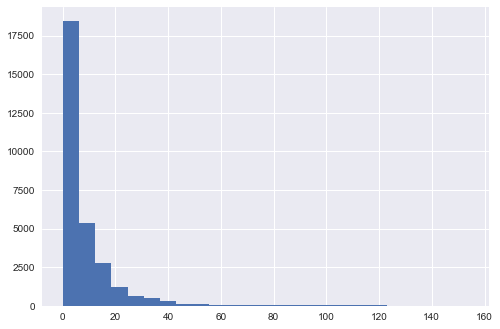

 | is numeric | 235 unique values  | consider one-hot? (ordinal?) 

cafe_sum_1000_min_price_avg -- Feature 
count    23947.0
mean       711.0
std        224.0
min        300.0
25%        543.0
50%        669.0
75%        839.0
max       2500.0
Name: cafe_sum_1000_min_price_avg, dtype: float64
300.0 1512.58105808


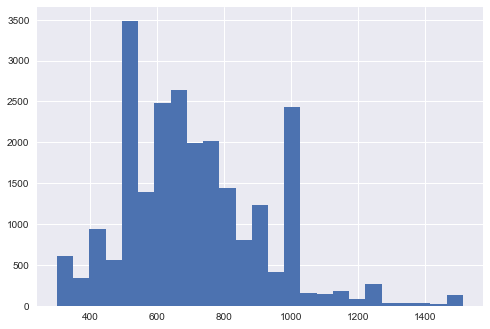

 | NaN 0.21 | is numeric | 1628 unique values 

cafe_sum_1000_max_price_avg -- Feature 
count    23947.0
mean      1207.0
std        343.0
min        500.0
25%       1000.0
50%       1143.0
75%       1400.0
max       4000.0
Name: cafe_sum_1000_max_price_avg, dtype: float64
500.0 2429.39540811


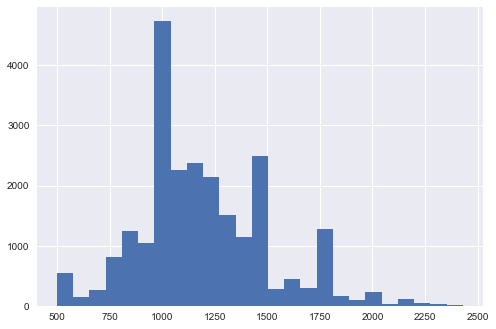

 | NaN 0.21 | is numeric | 1055 unique values  | consider one-hot? (ordinal?) 

cafe_avg_price_1000 -- Feature 
count    23947.0
mean       959.0
std        283.0
min        400.0
25%        750.0
50%        912.0
75%       1120.0
max       3250.0
Name: cafe_avg_price_1000, dtype: float64
400.0 1967.88282879


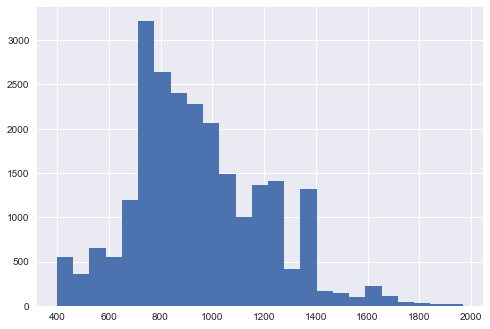

 | NaN 0.21 | is numeric | 2135 unique values 

cafe_count_1000_na_price -- Feature 
count    30471.00
mean         1.02
std          3.17
min          0.00
25%          0.00
50%          0.00
75%          1.00
max         28.00
Name: cafe_count_1000_na_price, dtype: float64
0.0 10.4968863701


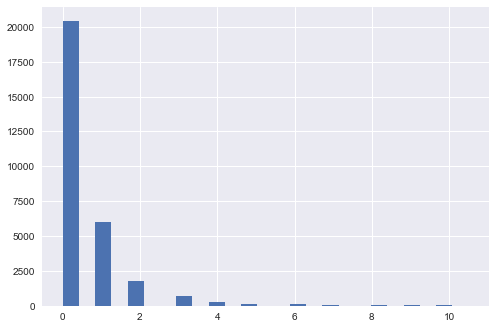

 | is numeric | 28 unique values  | consider one-hot? (ordinal?) 

cafe_count_1000_price_500 -- Feature 
count    30471.00
mean         4.15
std         13.86
min          0.00
25%          0.00
50%          1.00
75%          3.00
max        112.00
Name: cafe_count_1000_price_500, dtype: float64
0.0 44.5813507454


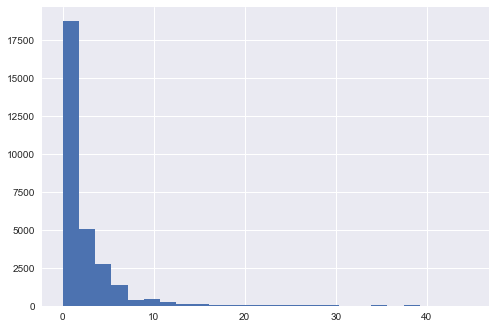

 | is numeric | 82 unique values  | consider one-hot? (ordinal?) 

cafe_count_1000_price_1000 -- Feature 
count    30471.00
mean         3.94
std          9.20
min          0.00
25%          0.00
50%          1.00
75%          4.00
max        107.00
Name: cafe_count_1000_price_1000, dtype: float64
0.0 31.5953774391


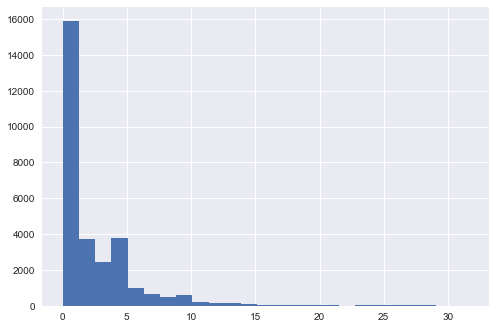

 | is numeric | 83 unique values  | consider one-hot? (ordinal?) 

cafe_count_1000_price_1500 -- Feature 
count    30471.00
mean         3.52
std         10.50
min          0.00
25%          0.00
50%          1.00
75%          3.00
max        104.00
Name: cafe_count_1000_price_1500, dtype: float64
0.0 34.4969251905


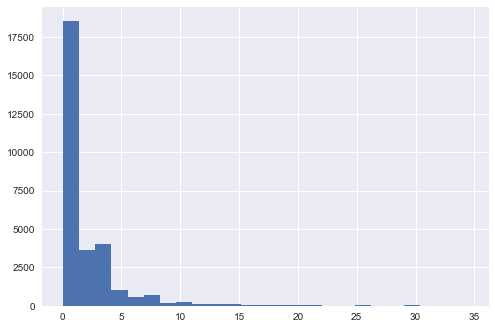

 | is numeric | 84 unique values  | consider one-hot? (ordinal?) 

cafe_count_1000_price_2500 -- Feature 
count    30471.00
mean         1.95
std          7.51
min          0.00
25%          0.00
50%          0.00
75%          1.00
max         79.00
Name: cafe_count_1000_price_2500, dtype: float64
0.0 23.5294355852


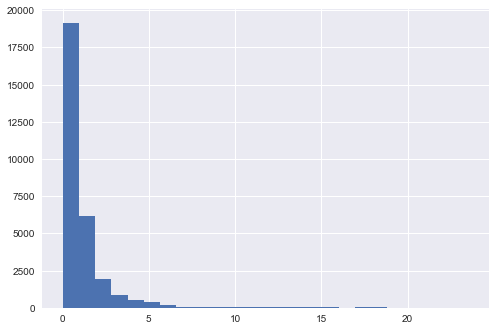

 | is numeric | 57 unique values  | consider one-hot? (ordinal?) 

cafe_count_1000_price_4000 -- Feature 
count    30471.00
mean         0.77
std          3.96
min          0.00
25%          0.00
50%          0.00
75%          0.00
max         40.00
Name: cafe_count_1000_price_4000, dtype: float64
0.0 11.8797194457


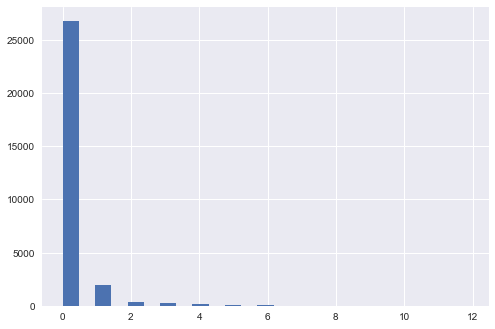

 | is numeric | 29 unique values  | consider one-hot? (ordinal?) 

cafe_count_1000_price_high -- Feature 
count    30471.00
mean         0.06
std          0.33
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          7.00
Name: cafe_count_1000_price_high, dtype: float64
0.0 0.997512721687


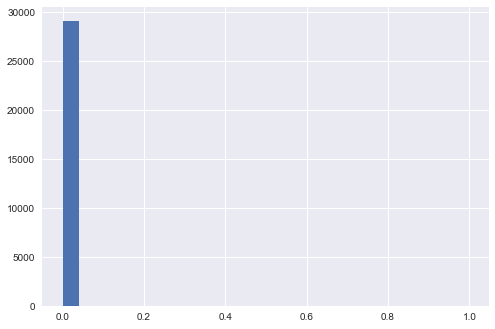

 | is numeric | 8 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                            price_doc  price_doc  price_doc     price_doc
cafe_count_1000_price_high                                               
0                               29108    6991693    6250000  4.445154e+06
1                                1104    8651879    6552000  7.174440e+06
2                                 145   14226791   11000000  1.058330e+07
3                                  51   14943131   11000000  1.256356e+07
4                                  39   16830263   12400000  1.296900e+07
5                                  15   22349899   14600000  2.811340e+07
6                                   8   20063500   19304000  1.073506e+07
7                                   1    3000000    3000000           NaN


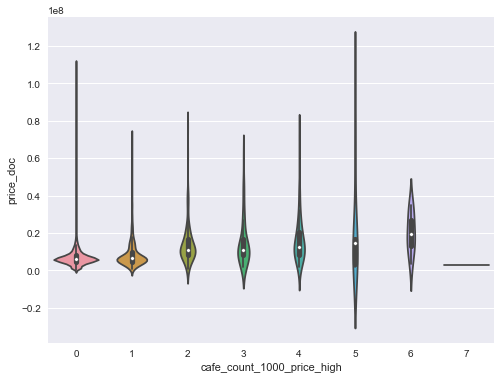


big_church_count_1000 -- Feature 
count    30471.00
mean         0.81
std          2.49
min          0.00
25%          0.00
50%          0.00
75%          1.00
max         27.00
Name: big_church_count_1000, dtype: float64
0.0 8.47812596361


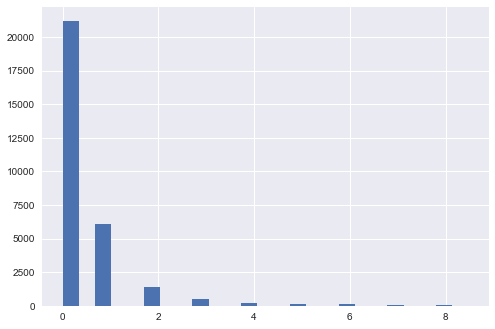

 | is numeric | 24 unique values  | consider one-hot? (ordinal?) 

church_count_1000 -- Feature 
count    30471.00
mean         1.82
std          5.11
min          0.00
25%          0.00
50%          1.00
75%          1.00
max         38.00
Name: church_count_1000, dtype: float64
0.0 16.3251062088


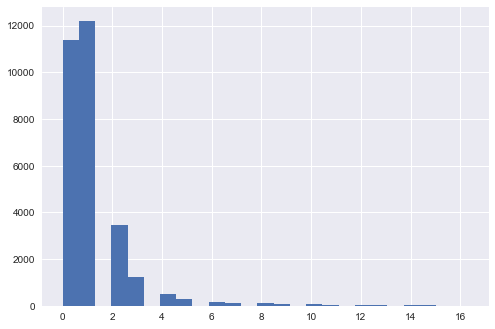

 | is numeric | 36 unique values  | consider one-hot? (ordinal?) 

mosque_count_1000 -- Feature 
count    30471.00
mean         0.02
std          0.14
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: mosque_count_1000, dtype: float64
0.0 0.41132893336


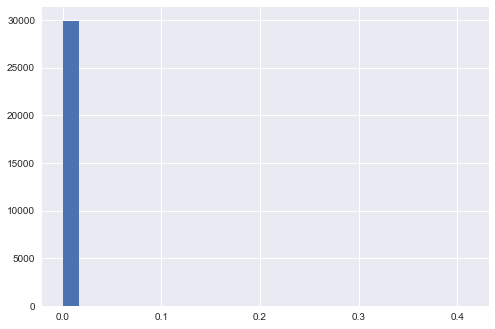

 | is numeric | 2 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                   price_doc  price_doc  price_doc     price_doc
mosque_count_1000                                               
0                      29887    7063361    6250000  4.710014e+06
1                        584   10176941    8300000  6.889482e+06


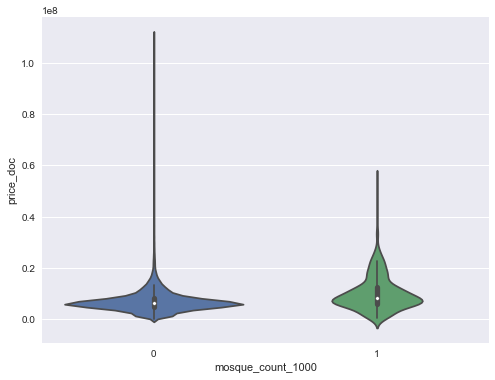


leisure_count_1000 -- Feature 
count    30471.00
mean         0.47
std          1.82
min          0.00
25%          0.00
50%          0.00
75%          0.00
max         30.00
Name: leisure_count_1000, dtype: float64
0.0 5.46076108502


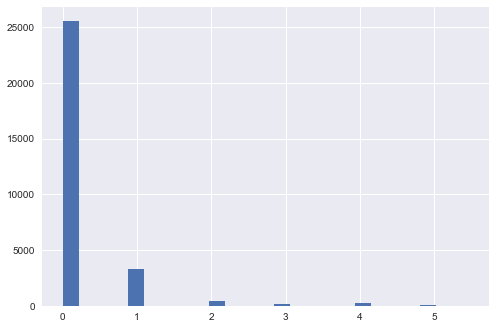

 | is numeric | 26 unique values  | consider one-hot? (ordinal?) 

sport_count_1000 -- Feature 
count    30471.00
mean         2.91
std          3.33
min          0.00
25%          0.00
50%          2.00
75%          4.00
max         25.00
Name: sport_count_1000, dtype: float64
0.0 13.9967725483


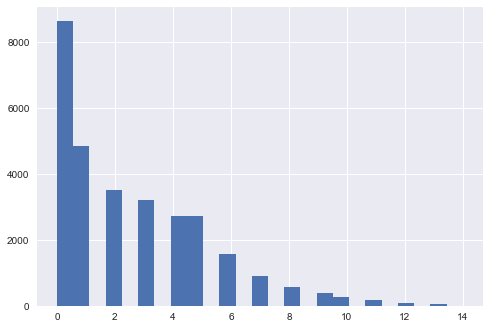

 | is numeric | 23 unique values  | consider one-hot? (ordinal?) 

market_count_1000 -- Feature 
count    30471.00
mean         0.38
std          0.73
min          0.00
25%          0.00
50%          0.00
75%          1.00
max          6.00
Name: market_count_1000, dtype: float64
0.0 3.19963490902


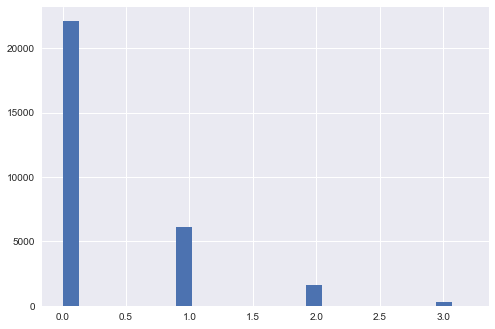

 | is numeric | 7 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                   price_doc  price_doc  price_doc     price_doc
market_count_1000                                               
0                      22101    6870122    6100000  4.573930e+06
1                       6128    7945032    6800000  5.522842e+06
2                       1635    7228357    6650000  4.246478e+06
3                        281    6864041    6300000  3.194181e+06
4                        287    8746806    7500000  5.279775e+06
5                         37    6989891    6800000  2.904729e+06
6                          2    3074500    3074500  2.935200e+06


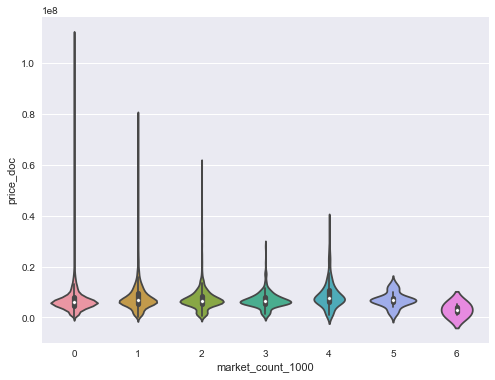


green_part_1500 -- Feature 
count    30471.00
mean        19.20
std         14.20
min          0.00
25%          8.47
50%         14.95
75%         26.69
max         90.41
Name: green_part_1500, dtype: float64
0.0 69.2908175711


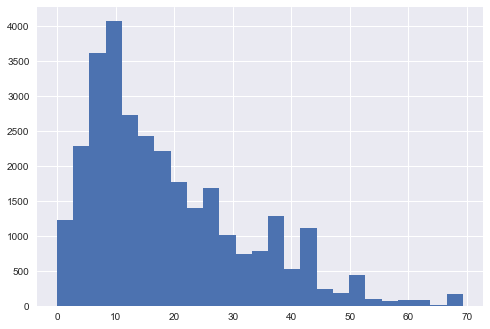

 | is numeric | 3934 unique values 

prom_part_1500 -- Feature 
count    30471.00
mean        10.60
std         10.98
min          0.00
25%          1.52
50%          7.82
75%         15.34
max         63.00
Name: prom_part_1500, dtype: float64
0.0 48.2784364549


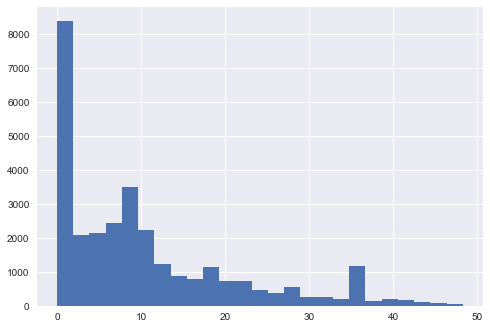

 | is numeric | 3332 unique values 

office_count_1500 -- Feature 
count    30471.00
mean         7.31
std         20.97
min          0.00
25%          0.00
50%          1.00
75%          4.00
max        173.00
Name: office_count_1500, dtype: float64
0.0 66.9171016748


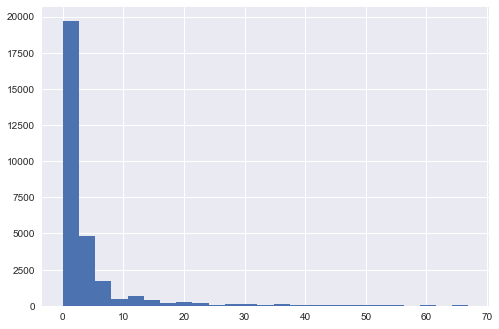

 | is numeric | 154 unique values  | consider one-hot? (ordinal?) 

office_sqm_1500 -- Feature 
count      30471.0
mean      140371.0
std       301684.0
min            0.0
25%            0.0
50%        16650.0
75%       117300.0
max      2908344.0
Name: office_sqm_1500, dtype: float64
0.0 1022353.28193


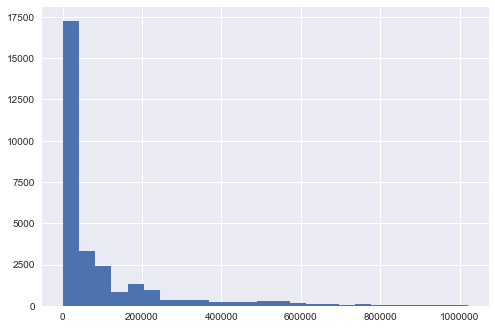

 | is numeric | 2639 unique values 

trc_count_1500 -- Feature 
count    30471.00
mean         3.73
std          4.48
min          0.00
25%          0.00
50%          3.00
75%          5.00
max         27.00
Name: trc_count_1500, dtype: float64
0.0 18.4544345221


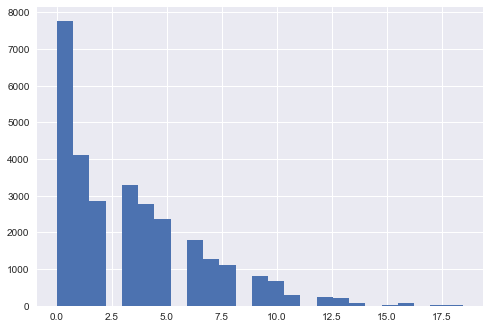

 | is numeric | 27 unique values  | consider one-hot? (ordinal?) 

trc_sqm_1500 -- Feature 
count      30471.0
mean      127715.0
std       212631.0
min            0.0
25%            0.0
50%        49410.0
75%       154590.0
max      1533000.0
Name: trc_sqm_1500, dtype: float64
0.0 792483.488612


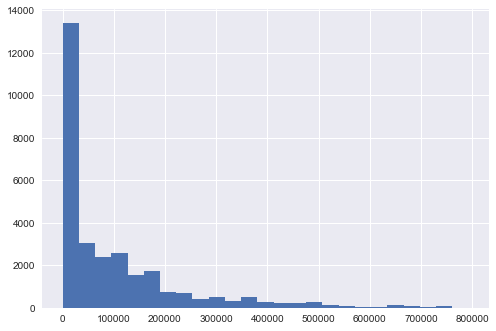

 | is numeric | 1785 unique values 

cafe_count_1500 -- Feature 
count    30471.00
mean        32.46
std         97.45
min          0.00
25%          2.00
50%         10.00
75%         23.00
max        784.00
Name: cafe_count_1500, dtype: float64
0.0 315.337109697


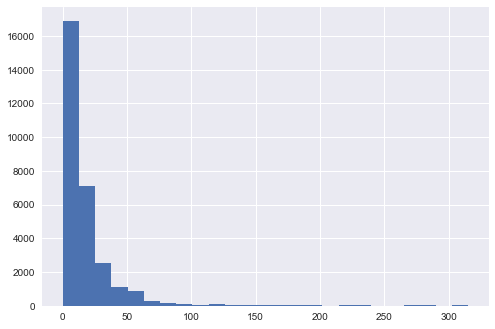

 | is numeric | 374 unique values  | consider one-hot? (ordinal?) 

cafe_sum_1500_min_price_avg -- Feature 
count    26272.0
mean       714.0
std        192.0
min        300.0
25%        586.0
50%        692.0
75%        821.0
max       2500.0
Name: cafe_sum_1500_min_price_avg, dtype: float64
300.0 1398.20952285


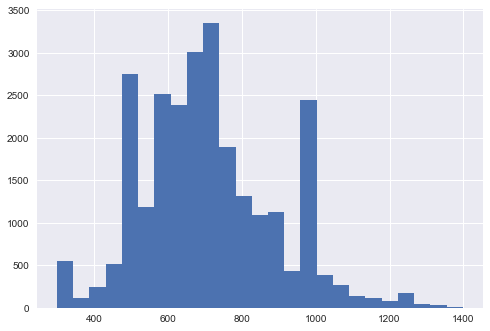

 | NaN 0.14 | is numeric | 2583 unique values 

cafe_sum_1500_max_price_avg -- Feature 
count    26272.0
mean      1206.0
std        291.0
min        500.0
25%       1000.0
50%       1167.0
75%       1367.0
max       4000.0
Name: cafe_sum_1500_max_price_avg, dtype: float64
500.0 2240.56358633


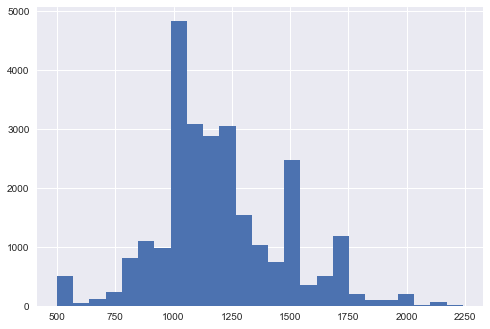

 | NaN 0.14 | is numeric | 1724 unique values 

cafe_avg_price_1500 -- Feature 
count    26272.0
mean       960.0
std        241.0
min        400.0
25%        795.0
50%        926.0
75%       1094.0
max       3250.0
Name: cafe_avg_price_1500, dtype: float64
400.0 1815.75728379


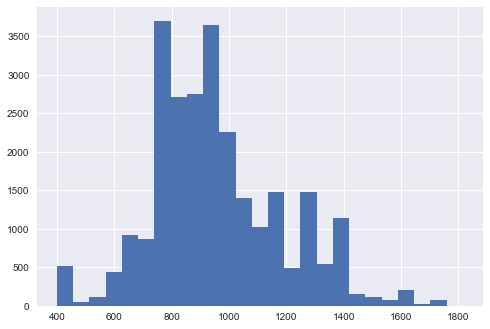

 | NaN 0.14 | is numeric | 3331 unique values 

cafe_count_1500_na_price -- Feature 
count    30471.00
mean         2.11
std          5.98
min          0.00
25%          0.00
50%          1.00
75%          2.00
max         54.00
Name: cafe_count_1500_na_price, dtype: float64
0.0 19.927526924


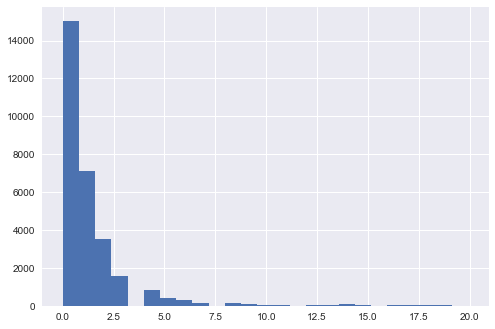

 | is numeric | 48 unique values  | consider one-hot? (ordinal?) 

cafe_count_1500_price_500 -- Feature 
count    30471.00
mean         8.23
std         24.89
min          0.00
25%          0.00
50%          2.00
75%          6.00
max        195.00
Name: cafe_count_1500_price_500, dtype: float64
0.0 80.669734024


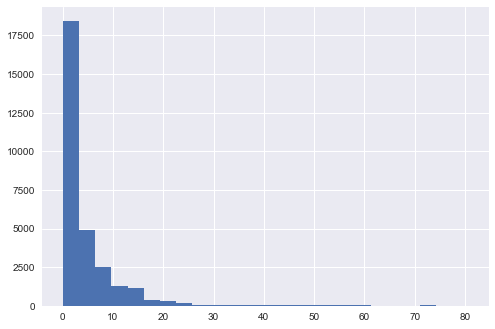

 | is numeric | 147 unique values  | consider one-hot? (ordinal?) 

cafe_count_1500_price_1000 -- Feature 
count    30471.00
mean         8.76
std         22.13
min          0.00
25%          1.00
50%          3.00
75%          8.00
max        177.00
Name: cafe_count_1500_price_1000, dtype: float64
0.0 74.391284422


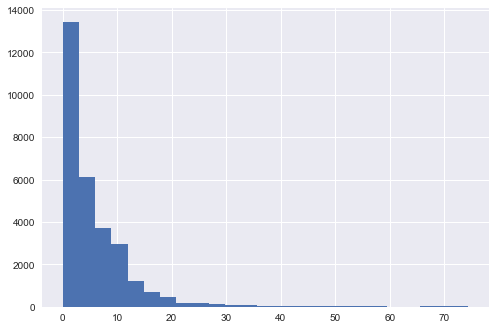

 | is numeric | 145 unique values  | consider one-hot? (ordinal?) 

cafe_count_1500_price_1500 -- Feature 
count    30471.00
mean         7.88
std         24.13
min          0.00
25%          0.00
50%          2.00
75%          6.00
max        183.00
Name: cafe_count_1500_price_1500, dtype: float64
0.0 78.3947730202


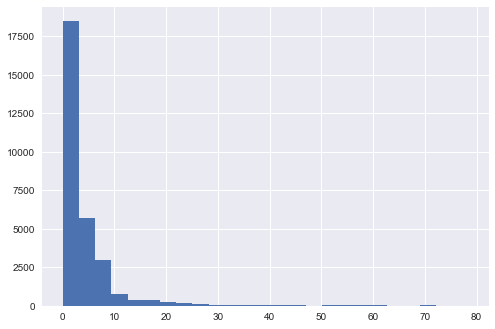

 | is numeric | 135 unique values  | consider one-hot? (ordinal?) 

cafe_count_1500_price_2500 -- Feature 
count    30471.00
mean         3.83
std         13.51
min          0.00
25%          0.00
50%          1.00
75%          2.00
max        127.00
Name: cafe_count_1500_price_2500, dtype: float64
0.0 42.5347884495


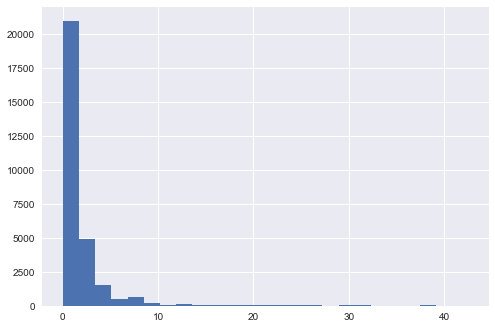

 | is numeric | 97 unique values  | consider one-hot? (ordinal?) 

cafe_count_1500_price_4000 -- Feature 
count    30471.00
mean         1.46
std          6.74
min          0.00
25%          0.00
50%          0.00
75%          0.00
max         58.00
Name: cafe_count_1500_price_4000, dtype: float64
0.0 20.2179410692


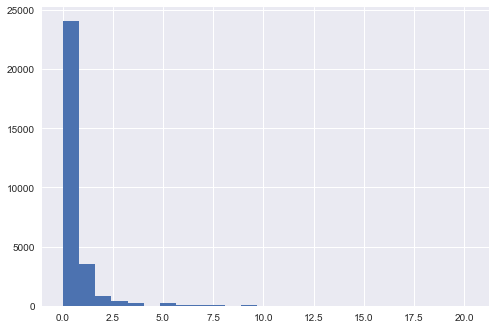

 | is numeric | 53 unique values  | consider one-hot? (ordinal?) 

cafe_count_1500_price_high -- Feature 
count    30471.00
mean         0.19
std          0.91
min          0.00
25%          0.00
50%          0.00
75%          0.00
max         12.00
Name: cafe_count_1500_price_high, dtype: float64
0.0 2.72360944619


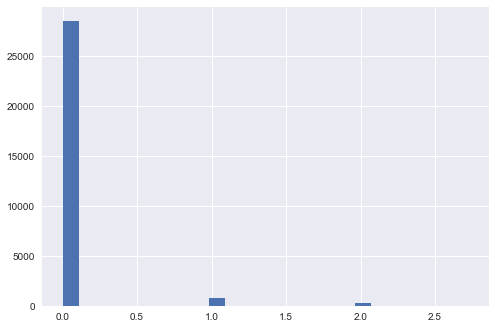

 | is numeric | 13 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                            price_doc  price_doc  price_doc     price_doc
cafe_count_1500_price_high                                               
0                               28523    6861153    6200000  4.107814e+06
1                                 740   12393415    9375000  9.940101e+06
2                                 318   13436396   10250000  1.070576e+07
3                                  71   14188546   11500000  9.868804e+06
4                                  46   12682797   11550000  8.217322e+06
5                                 665    6598272    5577808  4.798048e+06
6                                  42   18052978   11207710  1.458373e+07
7                                  27   15256644   13800000  1.310157e+07
8                                   9   16927777    9500000  1.602535e+07
9                                  19   21793289   13300000  2.186185e+07
10       

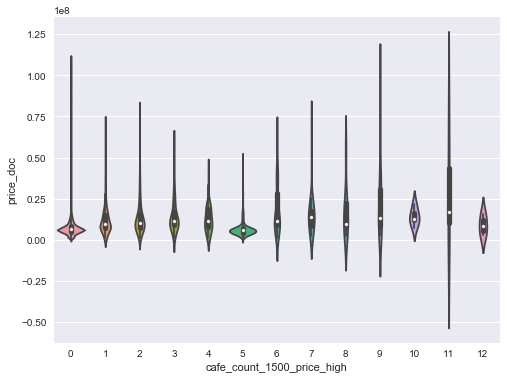


big_church_count_1500 -- Feature 
count    30471.00
mean         1.97
std          6.48
min          0.00
25%          0.00
50%          1.00
75%          1.00
max         44.00
Name: big_church_count_1500, dtype: float64
0.0 20.4367259936


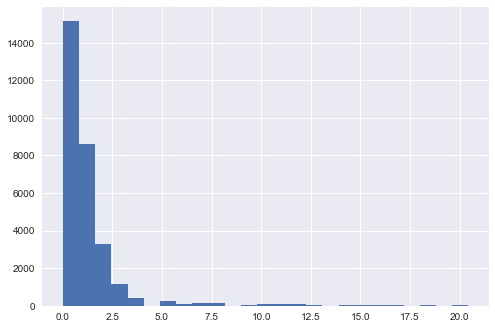

 | is numeric | 42 unique values  | consider one-hot? (ordinal?) 

church_count_1500 -- Feature 
count    30471.00
mean         3.66
std          9.74
min          0.00
25%          1.00
50%          1.00
75%          3.00
max         75.00
Name: church_count_1500, dtype: float64
0.0 32.2128778114


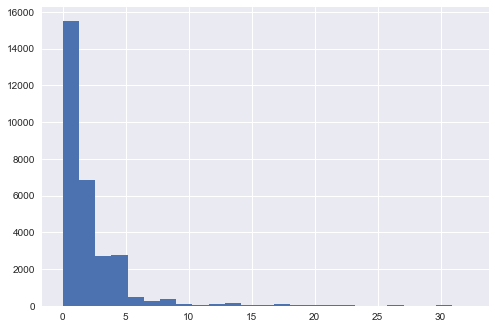

 | is numeric | 62 unique values  | consider one-hot? (ordinal?) 

mosque_count_1500 -- Feature 
count    30471.00
mean         0.04
std          0.19
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: mosque_count_1500, dtype: float64
0.0 0.572192933872


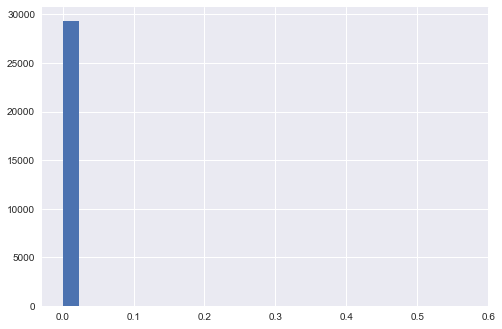

 | is numeric | 2 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                   price_doc  price_doc  price_doc     price_doc
mosque_count_1500                                               
0                      29319    7017829    6210540  4.599461e+06
1                       1152    9800568    8000000  7.653234e+06


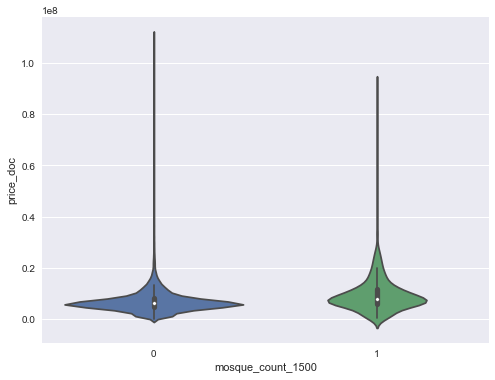


leisure_count_1500 -- Feature 
count    30471.00
mean         0.95
std          3.35
min          0.00
25%          0.00
50%          0.00
75%          1.00
max         44.00
Name: leisure_count_1500, dtype: float64
0.0 11.0429795381


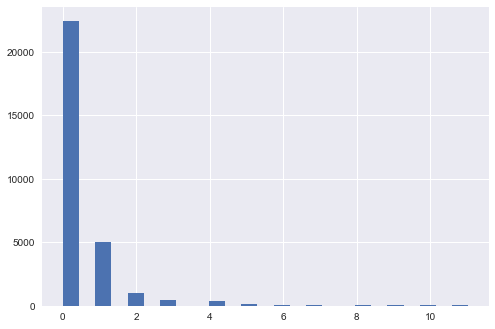

 | is numeric | 41 unique values  | consider one-hot? (ordinal?) 

sport_count_1500 -- Feature 
count    30471.00
mean         5.87
std          5.76
min          0.00
25%          1.00
50%          5.00
75%          9.00
max         37.00
Name: sport_count_1500, dtype: float64
0.0 26.2703639361


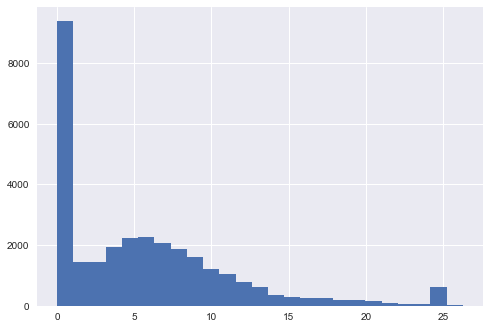

 | is numeric | 34 unique values  | consider one-hot? (ordinal?) 

market_count_1500 -- Feature 
count    30471.00
mean         0.77
std          1.12
min          0.00
25%          0.00
50%          0.00
75%          1.00
max          7.00
Name: market_count_1500, dtype: float64
0.0 4.36146813182


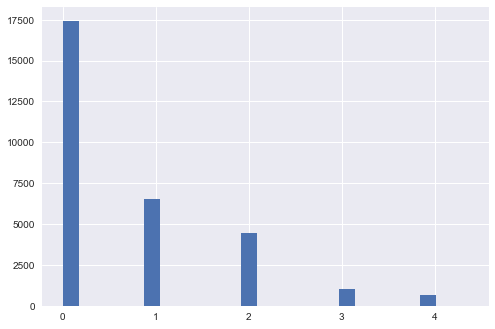

 | is numeric | 8 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                   price_doc  price_doc  price_doc     price_doc
market_count_1500                                               
0                      17415    6599092    5903808  4.241259e+06
1                       6507    8208824    7000000  6.022911e+06
2                       4436    7284711    6500000  4.525400e+06
3                       1025    7998061    6800000  4.865620e+06
4                        655    7144490    6600000  3.465285e+06
5                        332    8490550    7227348  5.143164e+06
6                         80    6853833    6460000  3.420579e+06
7                         21    7057142    6900000  4.393953e+06


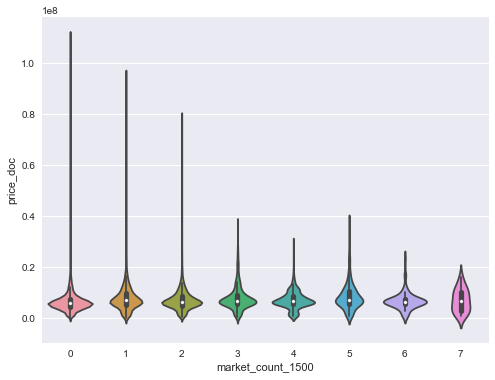


green_part_2000 -- Feature 
count    30471.00
mean        20.84
std         14.19
min          0.01
25%         10.16
50%         17.63
75%         28.33
max         75.30
Name: green_part_2000, dtype: float64
0.01 70.9110985056


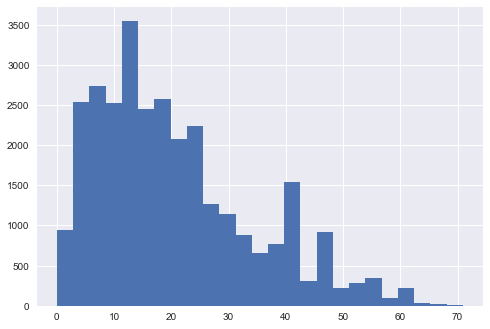

 | is numeric | 3981 unique values 

prom_part_2000 -- Feature 
count    30471.00
mean        11.22
std          9.64
min          0.00
25%          3.12
50%          8.80
75%         16.21
max         56.10
Name: prom_part_2000, dtype: float64
0.0 45.1358909656


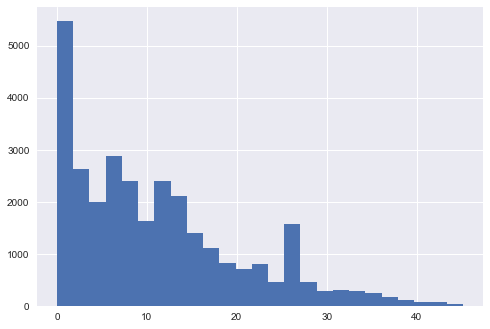

 | is numeric | 3348 unique values 

office_count_2000 -- Feature 
count    30471.00
mean        13.32
std         38.72
min          0.00
25%          0.00
50%          2.00
75%          7.00
max        250.00
Name: office_count_2000, dtype: float64
0.0 123.169181984


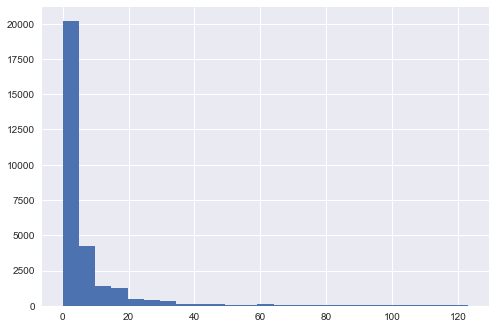

 | is numeric | 226 unique values  | consider one-hot? (ordinal?) 

office_sqm_2000 -- Feature 
count      30471.0
mean      246497.0
std       503636.0
min            0.0
25%            0.0
50%        58411.0
75%       207193.0
max      3602982.0
Name: office_sqm_2000, dtype: float64
0.0 1718102.16873


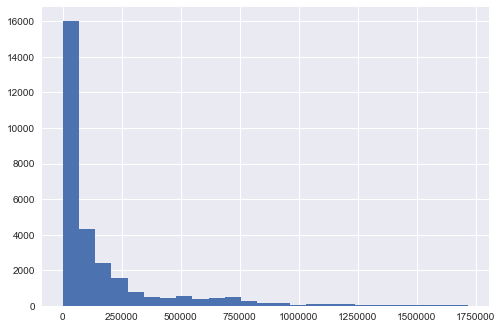

 | is numeric | 3288 unique values 

trc_count_2000 -- Feature 
count    30471.00
mean         5.97
std          6.34
min          0.00
25%          1.00
50%          5.00
75%          9.00
max         37.00
Name: trc_count_2000, dtype: float64
0.0 28.0240778392


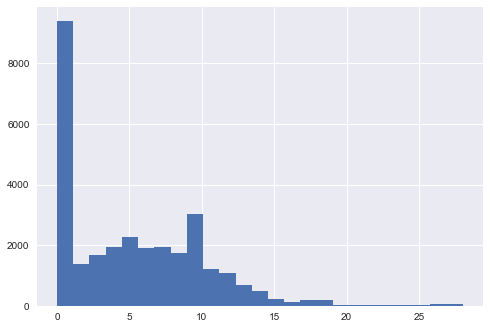

 | is numeric | 37 unique values  | consider one-hot? (ordinal?) 

trc_sqm_2000 -- Feature 
count      30471.0
mean      212759.0
std       290832.0
min            0.0
25%        12065.0
50%       117300.0
75%       286681.0
max      2448300.0
Name: trc_sqm_2000, dtype: float64
0.0 1159175.56276


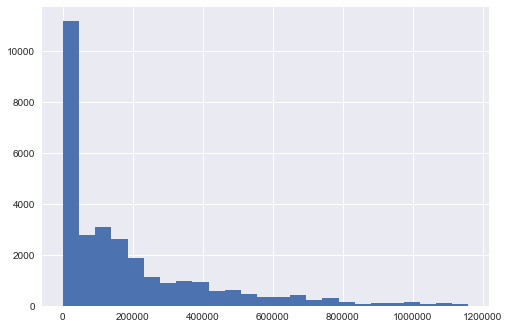

 | is numeric | 2397 unique values 

cafe_count_2000 -- Feature 
count    30471.00
mean        55.03
std        161.63
min          0.00
25%          3.00
50%         18.00
75%         37.00
max       1115.00
Name: cafe_count_2000, dtype: float64
0.0 521.901899704


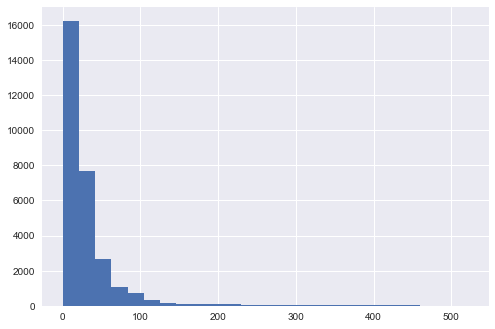

 | is numeric | 529 unique values  | consider one-hot? (ordinal?) 

cafe_sum_2000_min_price_avg -- Feature 
count    28746.0
mean       720.0
std        199.0
min        300.0
25%        608.0
50%        683.0
75%        792.0
max       2167.0
Name: cafe_sum_2000_min_price_avg, dtype: float64
300.0 1389.78733021


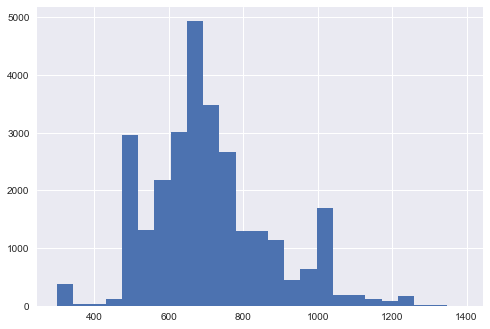

 | NaN 0.06 | is numeric | 3538 unique values 

cafe_sum_2000_max_price_avg -- Feature 
count    28746.0
mean      1211.0
std        303.0
min        500.0
25%       1000.0
50%       1156.0
75%       1322.0
max       3500.0
Name: cafe_sum_2000_max_price_avg, dtype: float64
500.0 2230.10386692


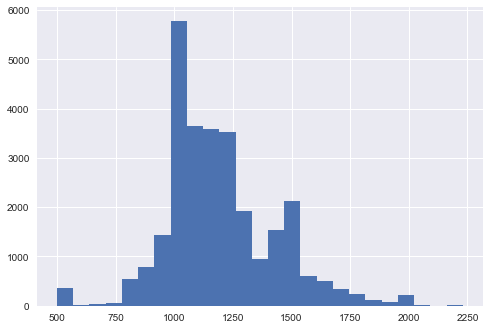

 | NaN 0.06 | is numeric | 2430 unique values 

cafe_avg_price_2000 -- Feature 
count    28746.0
mean       965.0
std        250.0
min        400.0
25%        823.0
50%        919.0
75%       1057.0
max       2833.0
Name: cafe_avg_price_2000, dtype: float64
400.0 1807.28306043


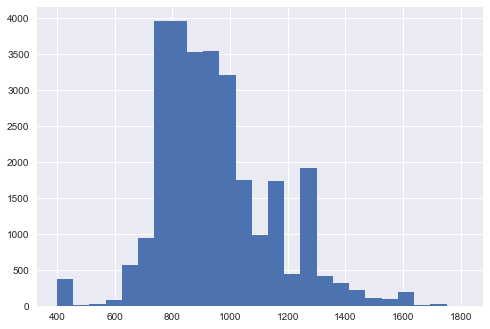

 | NaN 0.06 | is numeric | 4506 unique values 

cafe_count_2000_na_price -- Feature 
count    30471.00
mean         3.59
std         10.22
min          0.00
25%          0.00
50%          1.00
75%          3.00
max         70.00
Name: cafe_count_2000_na_price, dtype: float64
0.0 33.6698152151


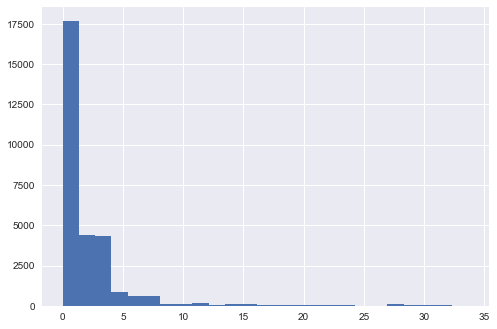

 | is numeric | 68 unique values  | consider one-hot? (ordinal?) 

cafe_count_2000_price_500 -- Feature 
count    30471.00
mean        13.60
std         39.16
min          0.00
25%          1.00
50%          4.00
75%         10.00
max        278.00
Name: cafe_count_2000_price_500, dtype: float64
0.0 127.476910939


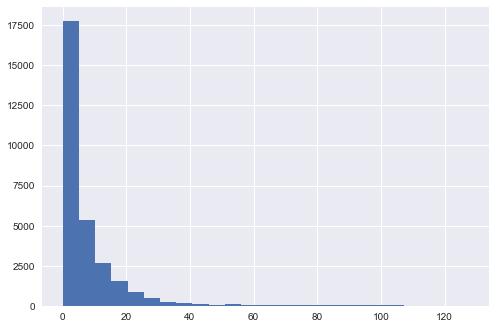

 | is numeric | 212 unique values  | consider one-hot? (ordinal?) 

cafe_count_2000_price_1000 -- Feature 
count    30471.00
mean        15.23
std         39.26
min          0.00
25%          1.00
50%          6.00
75%         13.00
max        262.00
Name: cafe_count_2000_price_1000, dtype: float64
0.0 130.773311945


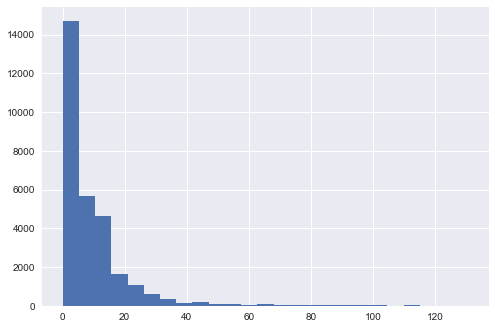

 | is numeric | 210 unique values  | consider one-hot? (ordinal?) 

cafe_count_2000_price_1500 -- Feature 
count    30471.00
mean        13.27
std         39.21
min          0.00
25%          1.00
50%          4.00
75%          9.00
max        261.00
Name: cafe_count_2000_price_1500, dtype: float64
0.0 126.61727335


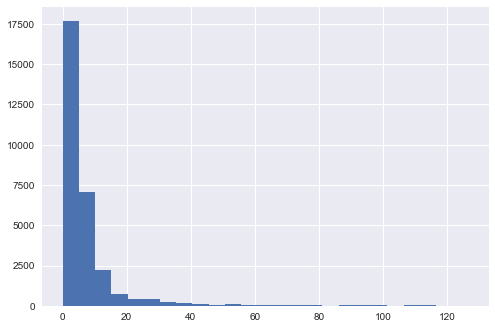

 | is numeric | 215 unique values  | consider one-hot? (ordinal?) 

cafe_count_2000_price_2500 -- Feature 
count    30471.00
mean         6.65
std         23.23
min          0.00
25%          0.00
50%          1.00
75%          3.00
max        170.00
Name: cafe_count_2000_price_2500, dtype: float64
0.0 72.6843656547


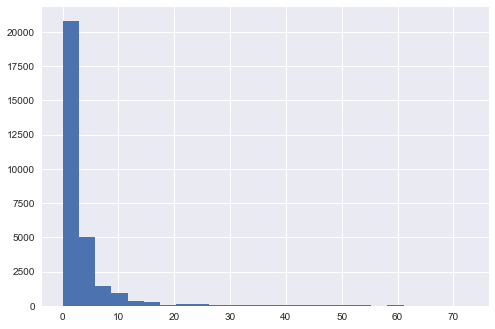

 | is numeric | 145 unique values  | consider one-hot? (ordinal?) 

cafe_count_2000_price_4000 -- Feature 
count    30471.00
mean         2.32
std          9.72
min          0.00
25%          0.00
50%          0.00
75%          1.00
max         81.00
Name: cafe_count_2000_price_4000, dtype: float64
0.0 30.1676495606


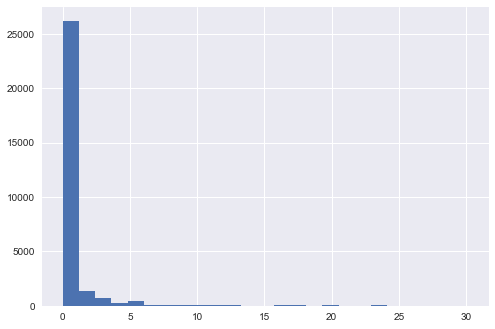

 | is numeric | 73 unique values  | consider one-hot? (ordinal?) 

cafe_count_2000_price_high -- Feature 
count    30471.00
mean         0.38
std          1.69
min          0.00
25%          0.00
50%          0.00
75%          0.00
max         16.00
Name: cafe_count_2000_price_high, dtype: float64
0.0 5.06558074705


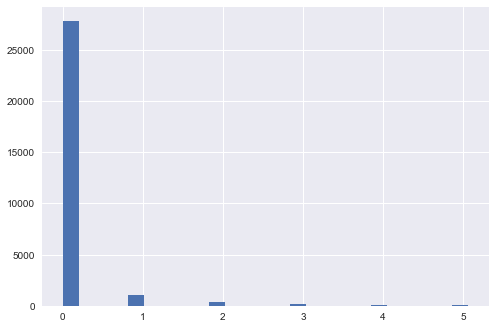

 | is numeric | 17 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                            price_doc  price_doc  price_doc     price_doc
cafe_count_2000_price_high                                               
0                               27832    6797777    6200000  3.992723e+06
1                                1073   10817888    8404830  8.586032e+06
2                                 329   11152263    8500000  9.012368e+06
3                                 192   12061840   10000000  9.338786e+06
4                                  94   11336406    9935040  8.529123e+06
5                                  53   11866886   10500000  7.468384e+06
6                                  93   17387355   13979706  1.151934e+07
7                                  43   17208548   13500000  1.366622e+07
8                                  32   14206999   12645000  8.133351e+06
9                                  42   15122381   11057710  1.293252e+07
10       

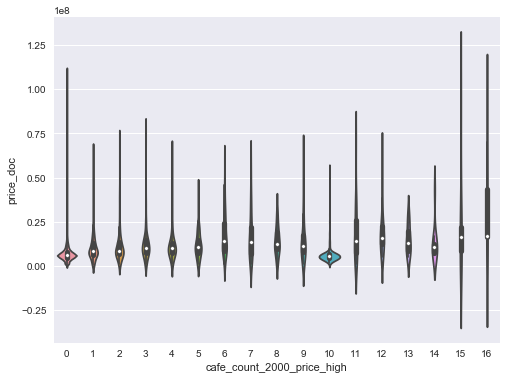


big_church_count_2000 -- Feature 
count    30471.00
mean         3.25
std         10.00
min          0.00
25%          0.00
50%          1.00
75%          2.00
max         70.00
Name: big_church_count_2000, dtype: float64
0.0 32.000171972


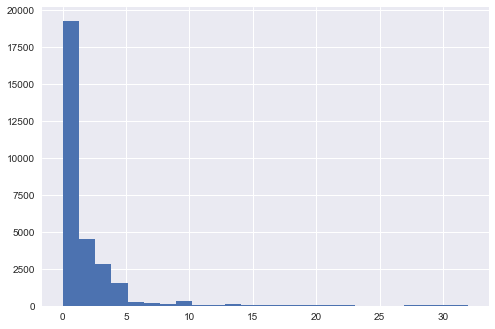

 | is numeric | 63 unique values  | consider one-hot? (ordinal?) 

church_count_2000 -- Feature 
count    30471.00
mean         6.20
std         15.49
min          0.00
25%          2.00
50%          3.00
75%          5.00
max        108.00
Name: church_count_2000, dtype: float64
0.0 51.4821544256


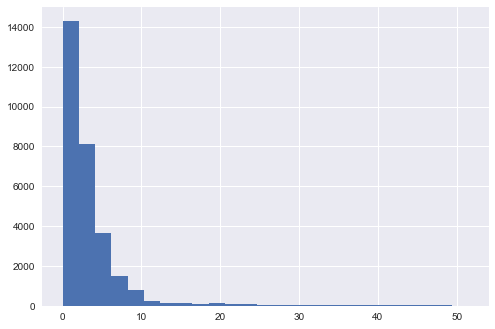

 | is numeric | 95 unique values  | consider one-hot? (ordinal?) 

mosque_count_2000 -- Feature 
count    30471.00
mean         0.09
std          0.28
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: mosque_count_2000, dtype: float64
0.0 0.85012082588


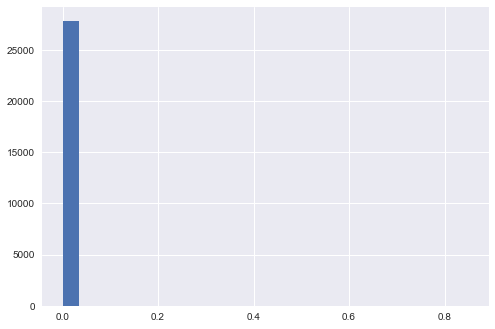

 | is numeric | 2 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                   price_doc  price_doc  price_doc     price_doc
mosque_count_2000                                               
0                      27788    6974166    6200000  4.493275e+06
1                       2683    8664875    7008120  6.914386e+06


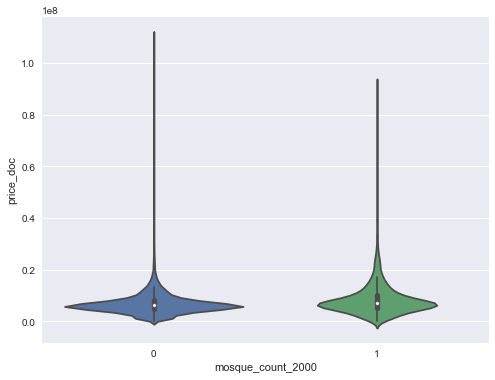


leisure_count_2000 -- Feature 
count    30471.00
mean         1.92
std          7.19
min          0.00
25%          0.00
50%          0.00
75%          1.00
max         55.00
Name: leisure_count_2000, dtype: float64
0.0 22.5572787891


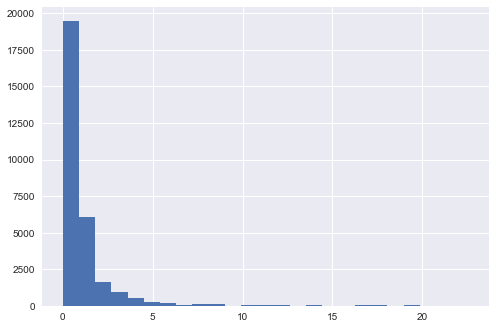

 | is numeric | 52 unique values  | consider one-hot? (ordinal?) 

sport_count_2000 -- Feature 
count    30471.00
mean         9.85
std          9.22
min          0.00
25%          2.00
50%          9.00
75%         14.00
max         54.00
Name: sport_count_2000, dtype: float64
0.0 41.6551092906


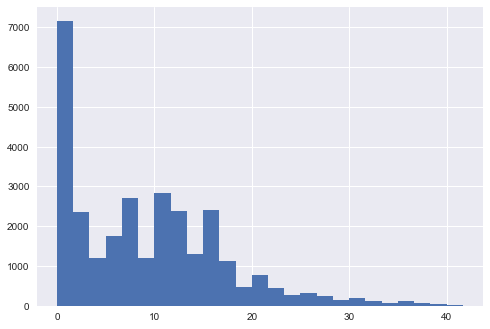

 | is numeric | 53 unique values  | consider one-hot? (ordinal?) 

market_count_2000 -- Feature 
count    30471.00
mean         1.17
std          1.43
min          0.00
25%          0.00
50%          1.00
75%          2.00
max          8.00
Name: market_count_2000, dtype: float64
0.0 6.3044078928


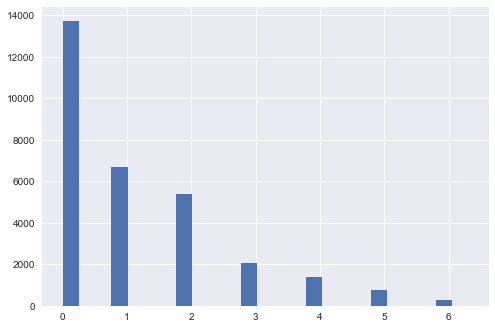

 | is numeric | 9 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                   price_doc  price_doc  price_doc     price_doc
market_count_2000                                               
0                      13730    6265759    5742437  3.775439e+06
1                       6706    7952342    6800000  5.771852e+06
2                       5391    7638342    6600000  5.229710e+06
3                       2087    8379931    7100000  5.639949e+06
4                       1389    7243882    6500000  3.892431e+06
5                        782    7482953    6800000  4.055022e+06
6                        268    8460790    6850000  5.518211e+06
7                        104    7034476    6925000  3.314170e+06
8                         14    7785000    6695000  4.081609e+06


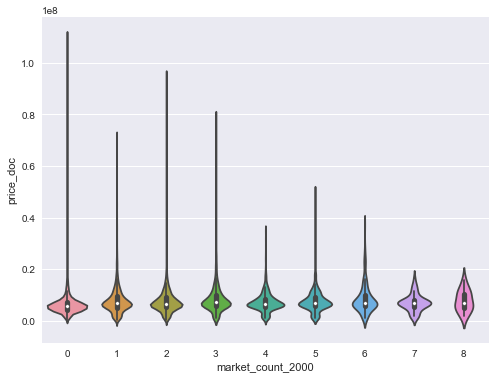


green_part_3000 -- Feature 
count    30471.00
mean        22.73
std         14.02
min          0.31
25%         12.15
50%         20.26
75%         30.36
max         74.02
Name: green_part_3000, dtype: float64
0.31 72.4118501695


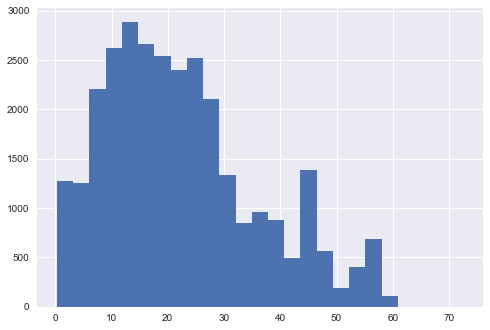

 | is numeric | 3924 unique values 

prom_part_3000 -- Feature 
count    30471.00
mean        10.98
std          7.94
min          0.00
25%          4.24
50%          9.66
75%         15.73
max         45.10
Name: prom_part_3000, dtype: float64
0.0 39.5447295259


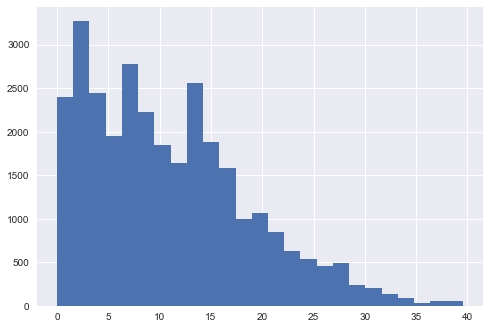

 | is numeric | 3061 unique values 

office_count_3000 -- Feature 
count    30471.00
mean        29.37
std         81.35
min          0.00
25%          0.00
50%          5.00
75%         17.00
max        493.00
Name: office_count_3000, dtype: float64
0.0 261.056377497


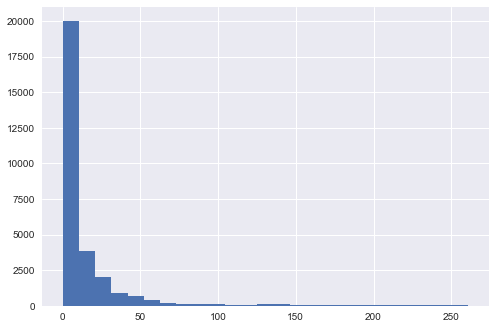

 | is numeric | 395 unique values  | consider one-hot? (ordinal?) 

office_sqm_3000 -- Feature 
count      30471.0
mean      543262.0
std      1056128.0
min            0.0
25%            0.0
50%       130303.0
75%       494706.0
max      6106112.0
Name: office_sqm_3000, dtype: float64
0.0 3663089.61396


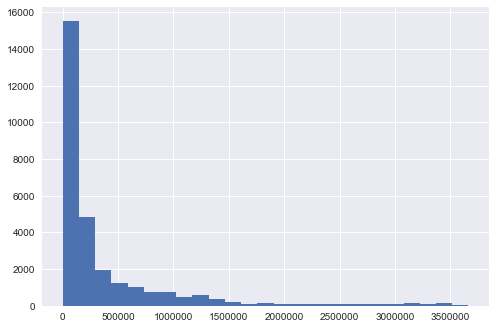

 | is numeric | 4281 unique values 

trc_count_3000 -- Feature 
count    30471.00
mean        11.83
std         10.91
min          0.00
25%          2.00
50%         11.00
75%         17.00
max         66.00
Name: trc_count_3000, dtype: float64
0.0 49.7432835871


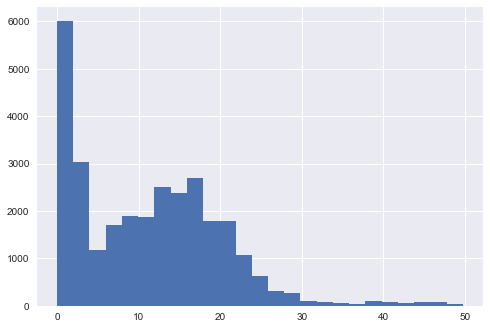

 | is numeric | 65 unique values  | consider one-hot? (ordinal?) 

trc_sqm_3000 -- Feature 
count      30471.0
mean      438132.0
std       469732.0
min            0.0
25%        41100.0
50%       294350.0
75%       659453.0
max      2654102.0
Name: trc_sqm_3000, dtype: float64
0.0 2068647.66407


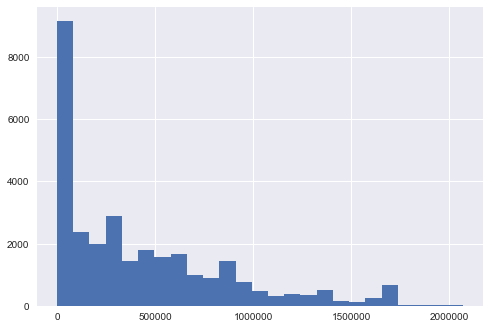

 | is numeric | 3419 unique values 

cafe_count_3000 -- Feature 
count    30471.0
mean       111.0
std        290.0
min          0.0
25%          6.0
50%         41.0
75%         78.0
max       1815.0
Name: cafe_count_3000, dtype: float64
0.0 948.404498774


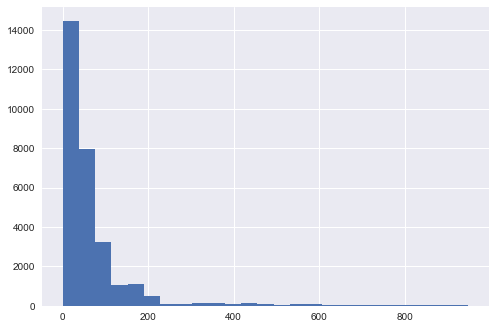

 | is numeric | 877 unique values  | consider one-hot? (ordinal?) 

cafe_sum_3000_min_price_avg -- Feature 
count    29480.0
mean       766.0
std        224.0
min        300.0
25%        650.0
50%        711.0
75%        816.0
max       1833.0
Name: cafe_sum_3000_min_price_avg, dtype: float64
300.0 1487.65015821


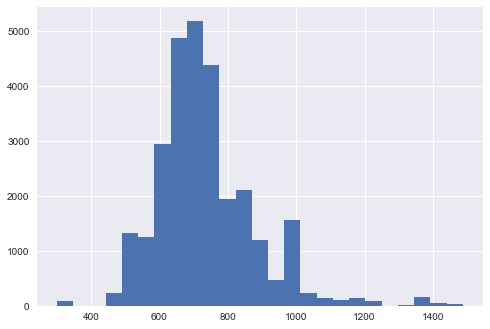

 | NaN 0.03 | is numeric | 5164 unique values 

cafe_sum_3000_max_price_avg -- Feature 
count    29480.0
mean      1283.0
std        353.0
min        500.0
25%       1102.0
50%       1212.0
75%       1333.0
max       3000.0
Name: cafe_sum_3000_max_price_avg, dtype: float64
500.0 2393.22899035


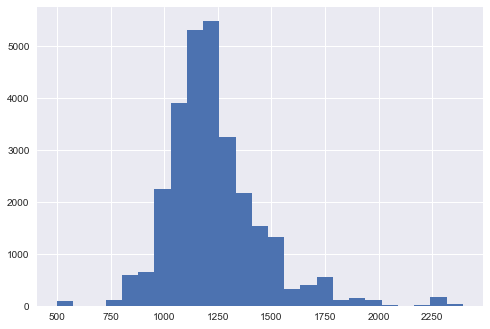

 | NaN 0.03 | is numeric | 3886 unique values 

cafe_avg_price_3000 -- Feature 
count    29480.0
mean      1025.0
std        288.0
min        400.0
25%        876.0
50%        961.0
75%       1083.0
max       2417.0
Name: cafe_avg_price_3000, dtype: float64
400.0 1947.82035445


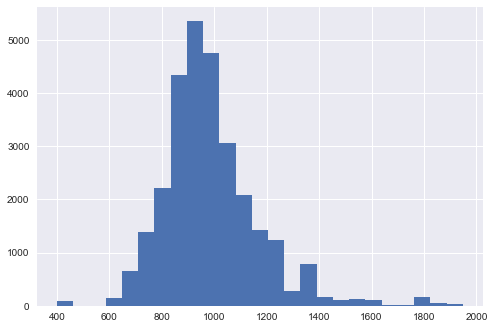

 | NaN 0.03 | is numeric | 6088 unique values 

cafe_count_3000_na_price -- Feature 
count    30471.00
mean         7.27
std         18.24
min          0.00
25%          0.00
50%          3.00
75%          6.00
max        119.00
Name: cafe_count_3000_na_price, dtype: float64
0.0 60.7272005615


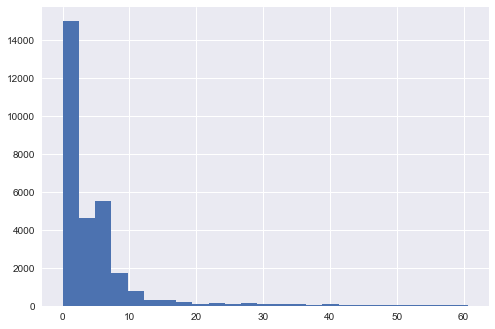

 | is numeric | 112 unique values  | consider one-hot? (ordinal?) 

cafe_count_3000_price_500 -- Feature 
count    30471.00
mean        27.78
std         71.83
min          0.00
25%          1.00
50%          9.00
75%         22.00
max        449.00
Name: cafe_count_3000_price_500, dtype: float64
0.0 237.479475938


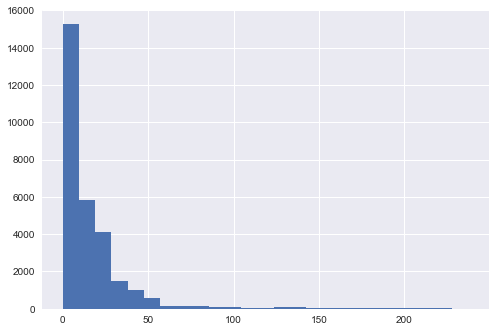

 | is numeric | 360 unique values  | consider one-hot? (ordinal?) 

cafe_count_3000_price_1000 -- Feature 
count    30471.00
mean        30.45
std         69.53
min          0.00
25%          2.00
50%         14.00
75%         26.00
max        441.00
Name: cafe_count_3000_price_1000, dtype: float64
0.0 234.586046123


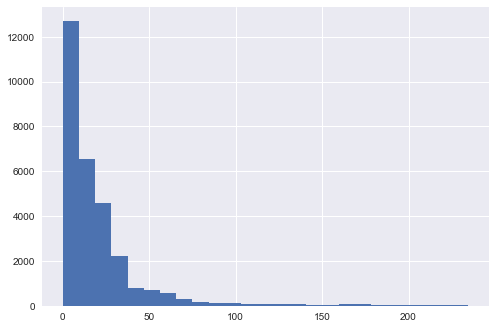

 | is numeric | 358 unique values  | consider one-hot? (ordinal?) 

cafe_count_3000_price_1500 -- Feature 
count    30471.00
mean        26.69
std         70.86
min          0.00
25%          2.00
50%         10.00
75%         17.00
max        446.00
Name: cafe_count_3000_price_1500, dtype: float64
0.0 229.567197356


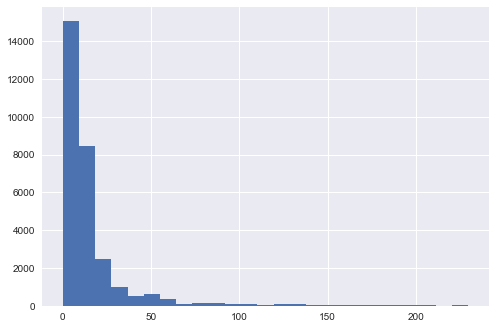

 | is numeric | 343 unique values  | consider one-hot? (ordinal?) 

cafe_count_3000_price_2500 -- Feature 
count    30471.00
mean        13.32
std         41.28
min          0.00
25%          1.00
50%          3.00
75%          6.00
max        266.00
Name: cafe_count_3000_price_2500, dtype: float64
0.0 129.84600035


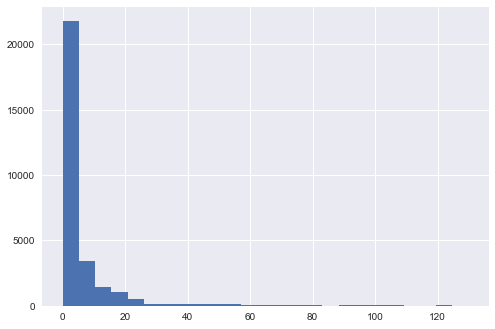

 | is numeric | 244 unique values  | consider one-hot? (ordinal?) 

cafe_count_3000_price_4000 -- Feature 
count    30471.00
mean         4.65
std         16.88
min          0.00
25%          0.00
50%          1.00
75%          2.00
max        113.00
Name: cafe_count_3000_price_4000, dtype: float64
0.0 52.6535724248


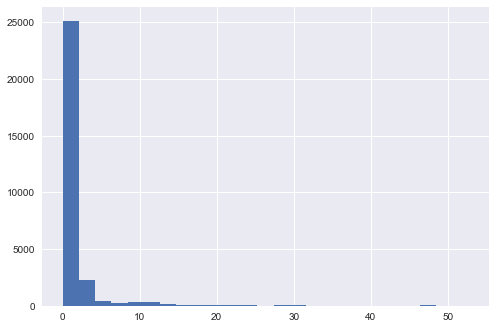

 | is numeric | 112 unique values  | consider one-hot? (ordinal?) 

cafe_count_3000_price_high -- Feature 
count    30471.00
mean         0.71
std          2.78
min          0.00
25%          0.00
50%          0.00
75%          0.00
max         23.00
Name: cafe_count_3000_price_high, dtype: float64
0.0 8.32649706872


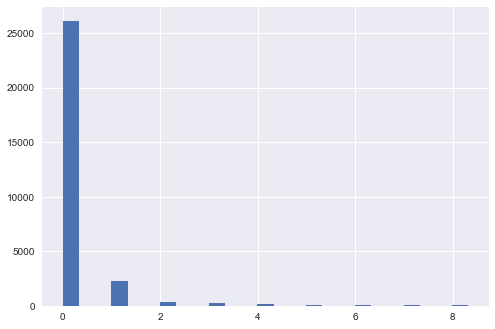

 | is numeric | 24 unique values  | consider one-hot? (ordinal?) 

big_church_count_3000 -- Feature 
count    30471.00
mean         6.12
std         15.41
min          0.00
25%          1.00
50%          2.00
75%          5.00
max        102.00
Name: big_church_count_3000, dtype: float64
0.0 51.2410917101


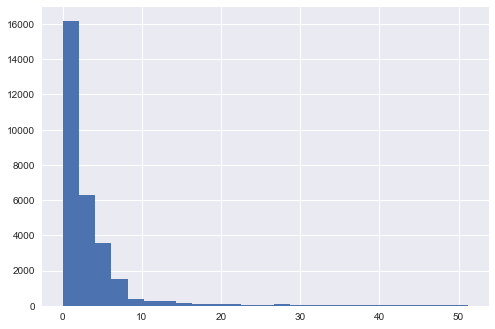

 | is numeric | 101 unique values  | consider one-hot? (ordinal?) 

church_count_3000 -- Feature 
count    30471.00
mean        12.29
std         25.79
min          0.00
25%          3.00
50%          6.00
75%         10.00
max        164.00
Name: church_count_3000, dtype: float64
0.0 87.3557218863


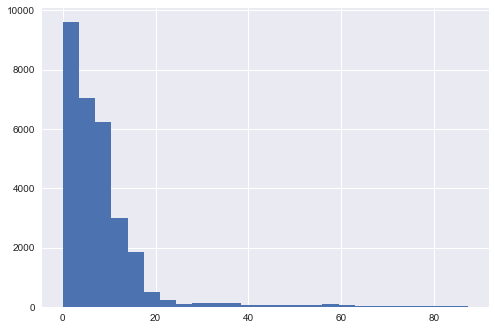

 | is numeric | 160 unique values  | consider one-hot? (ordinal?) 

mosque_count_3000 -- Feature 
count    30471.00
mean         0.20
std          0.45
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          2.00
Name: mosque_count_3000, dtype: float64
0.0 1.3434463946


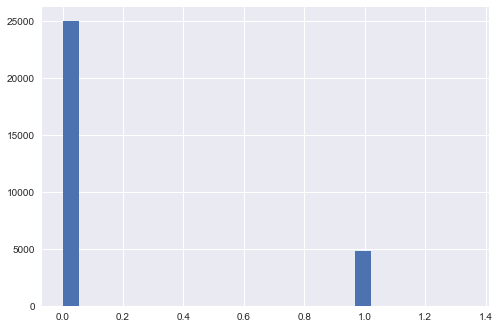

 | is numeric | 3 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                   price_doc  price_doc  price_doc     price_doc
mosque_count_3000                                               
0                      25031    6848427    6200000  4.261260e+06
1                       4814    8675358    7100000  6.706643e+06
2                        626    6165868    5408587  4.228365e+06


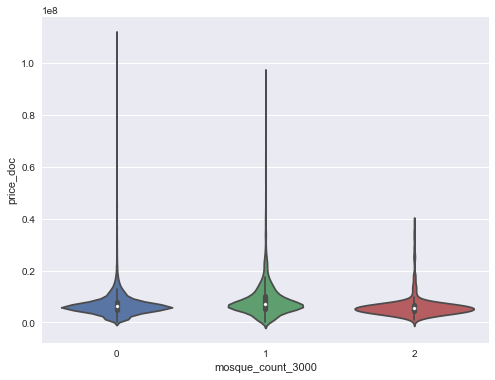


leisure_count_3000 -- Feature 
count    30471.00
mean         3.88
std         13.19
min          0.00
25%          0.00
50%          0.00
75%          2.00
max         85.00
Name: leisure_count_3000, dtype: float64
0.0 41.566245259


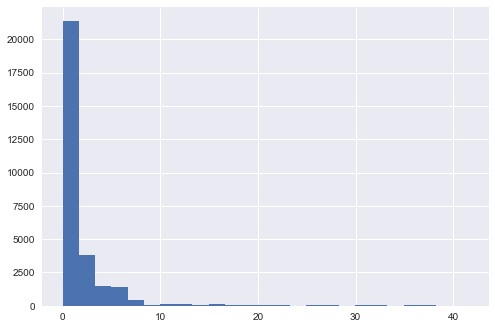

 | is numeric | 80 unique values  | consider one-hot? (ordinal?) 

sport_count_3000 -- Feature 
count    30471.00
mean        20.24
std         18.84
min          0.00
25%          5.00
50%         18.00
75%         29.00
max        100.00
Name: sport_count_3000, dtype: float64
0.0 85.5316018559


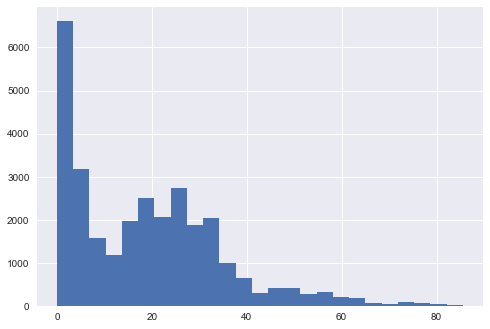

 | is numeric | 101 unique values  | consider one-hot? (ordinal?) 

market_count_3000 -- Feature 
count    30471.00
mean         2.32
std          2.27
min          0.00
25%          0.00
50%          2.00
75%          4.00
max         10.00
Name: market_count_3000, dtype: float64
0.0 10.0


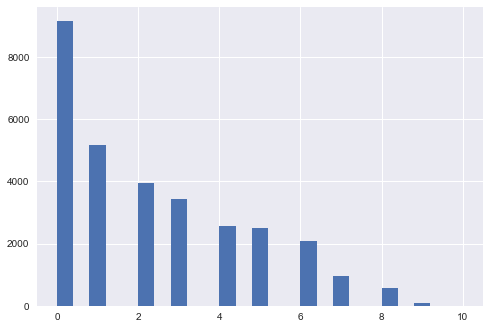

 | is numeric | 11 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                   price_doc  price_doc  price_doc     price_doc
market_count_3000                                               
0                       9150    5838773    5406676  3.094047e+06
1                       5183    6838137    6070000  4.986973e+06
2                       3954    7810258    6900000  4.936764e+06
3                       3416    8452186    7500000  5.608351e+06
4                       2567    7949022    6900000  5.474821e+06
5                       2498    7891791    6700000  5.685481e+06
6                       2095    7187633    6300000  4.948615e+06
7                        944    8142756    6900000  5.362317e+06
8                        568    8061343    7235728  4.099886e+06
9                         88   10436900   11091908  3.758565e+06
10                         8    7968750    8725000  4.162669e+06


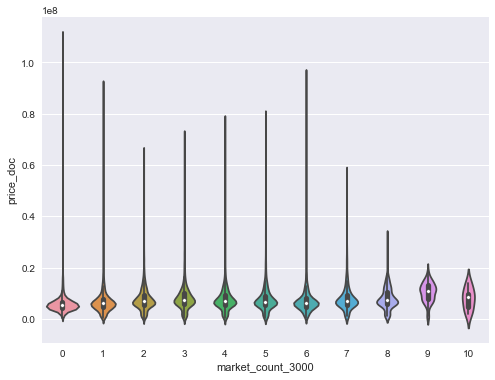


green_part_5000 -- Feature 
count    30471.00
mean        22.77
std         11.21
min          3.52
25%         14.78
50%         19.76
75%         31.40
max         75.46
Name: green_part_5000, dtype: float64
3.52 65.0304143706


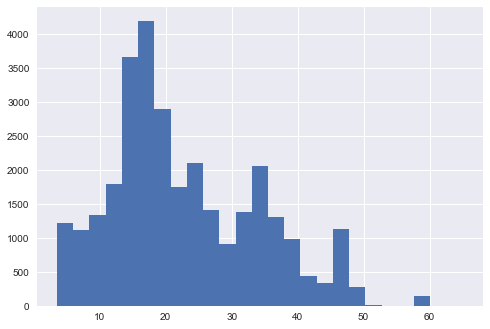

 | is numeric | 3514 unique values 

prom_part_5000 -- Feature 
count    30293.00
mean        10.35
std          5.67
min          0.21
25%          6.05
50%          8.98
75%         14.00
max         28.56
Name: prom_part_5000, dtype: float64
0.21 28.56


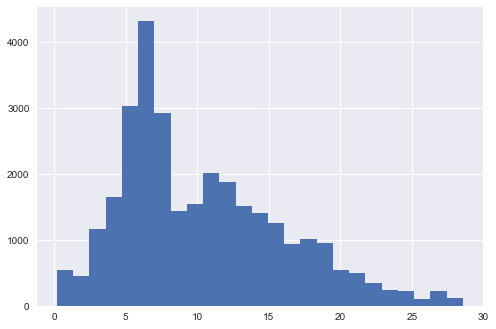

 | NaN 0.01 | is numeric | 2400 unique values 

office_count_5000 -- Feature 
count    30471.00
mean        71.36
std        155.34
min          0.00
25%          2.00
50%         15.00
75%         53.00
max        789.00
Name: office_count_5000, dtype: float64
0.0 519.024086748


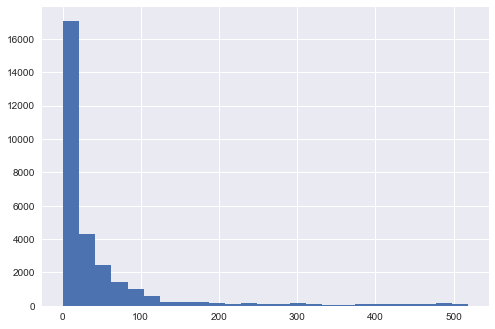

 | is numeric | 725 unique values  | consider one-hot? (ordinal?) 

office_sqm_5000 -- Feature 
count       30471.0
mean      1401057.0
std       2303052.0
min             0.0
25%         85159.0
50%        432438.0
75%       1433847.0
max      12702114.0
Name: office_sqm_5000, dtype: float64
0.0 8343004.48404


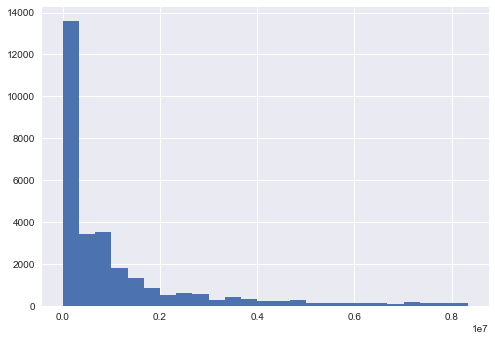

 | is numeric | 5970 unique values 

trc_count_5000 -- Feature 
count    30471.00
mean        30.13
std         23.92
min          0.00
25%          6.00
50%         31.00
75%         43.00
max        120.00
Name: trc_count_5000, dtype: float64
0.0 114.772153792


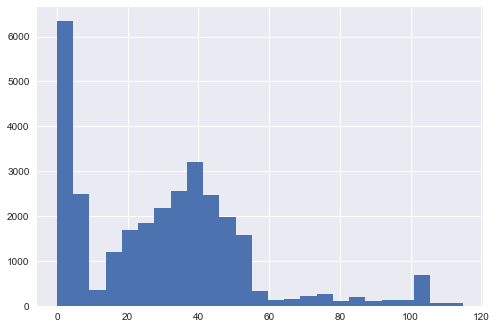

 | is numeric | 121 unique values  | consider one-hot? (ordinal?) 

trc_sqm_5000 -- Feature 
count      30471.0
mean     1173871.0
std      1004810.0
min            0.0
25%       262000.0
50%      1075495.0
75%      1683836.0
max      4585477.0
Name: trc_sqm_5000, dtype: float64
0.0 4585477.0


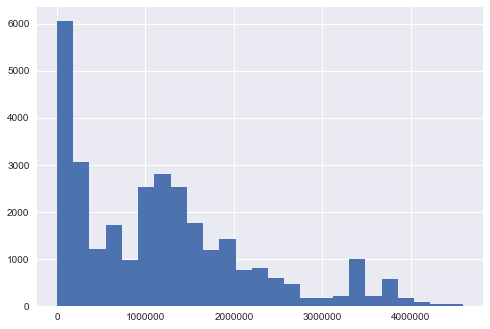

 | is numeric | 5204 unique values 

cafe_count_5000 -- Feature 
count    30471.0
mean       266.0
std        515.0
min          0.0
25%         20.0
50%        108.0
75%        222.0
max       2645.0
Name: cafe_count_5000, dtype: float64
0.0 1765.61601393


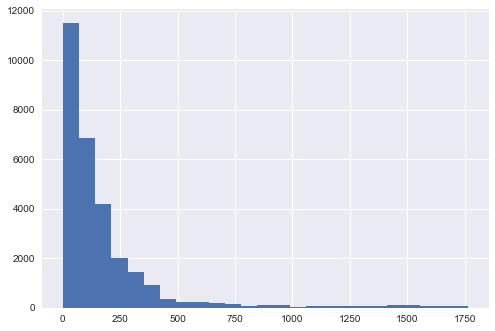

 | is numeric | 1580 unique values 

cafe_sum_5000_min_price_avg -- Feature 
count    30174.0
mean       765.0
std        152.0
min        300.0
25%        671.0
50%        722.0
75%        817.0
max       1875.0
Name: cafe_sum_5000_min_price_avg, dtype: float64
300.0 1273.88435346


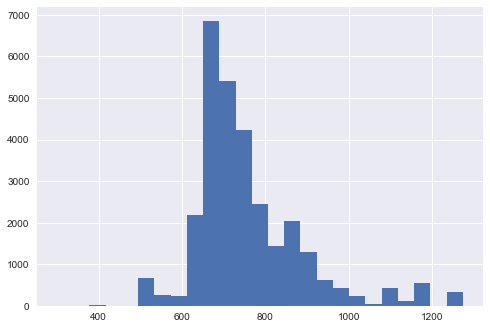

 | NaN 0.01 | is numeric | 7250 unique values 

cafe_sum_5000_max_price_avg -- Feature 
count    30174.0
mean      1278.0
std        236.0
min        500.0
25%       1144.0
50%       1212.0
75%       1346.0
max       3000.0
Name: cafe_sum_5000_max_price_avg, dtype: float64
500.0 2054.71305878


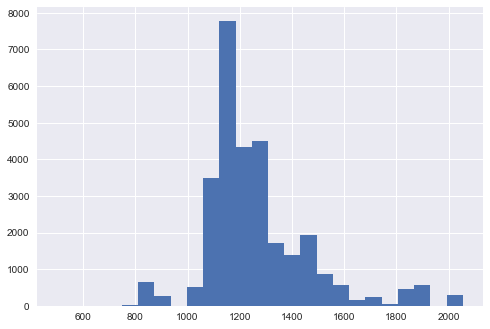

 | NaN 0.01 | is numeric | 6306 unique values 

cafe_avg_price_5000 -- Feature 
count    30174.0
mean      1022.0
std        194.0
min        400.0
25%        909.0
50%        967.0
75%       1092.0
max       2438.0
Name: cafe_avg_price_5000, dtype: float64
400.0 1674.02308697


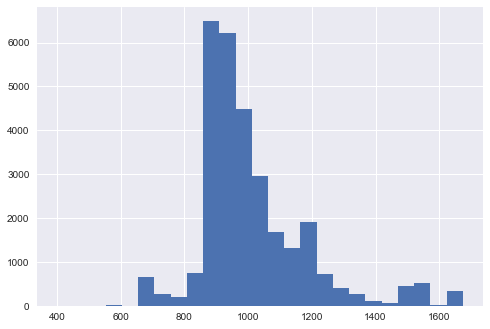

 | NaN 0.01 | is numeric | 7858 unique values 

cafe_count_5000_na_price -- Feature 
count    30471.00
mean        17.81
std         33.27
min          0.00
25%          1.00
50%          8.00
75%         15.00
max        174.00
Name: cafe_count_5000_na_price, dtype: float64
0.0 114.807169532


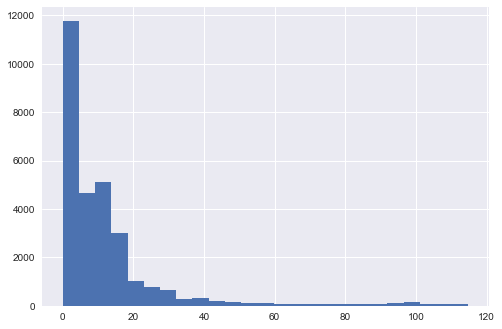

 | is numeric | 175 unique values  | consider one-hot? (ordinal?) 

cafe_count_5000_price_500 -- Feature 
count    30471.00
mean        66.20
std        125.93
min          0.00
25%          4.00
50%         28.00
75%         59.00
max        650.00
Name: cafe_count_5000_price_500, dtype: float64
0.0 436.803752576


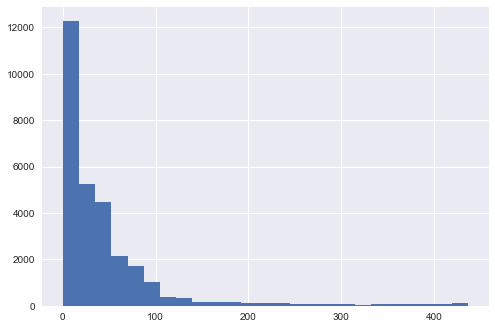

 | is numeric | 610 unique values  | consider one-hot? (ordinal?) 

cafe_count_5000_price_1000 -- Feature 
count    30471.00
mean        73.44
std        126.17
min          0.00
25%          8.00
50%         36.00
75%         69.00
max        648.00
Name: cafe_count_5000_price_1000, dtype: float64
0.0 447.503011593


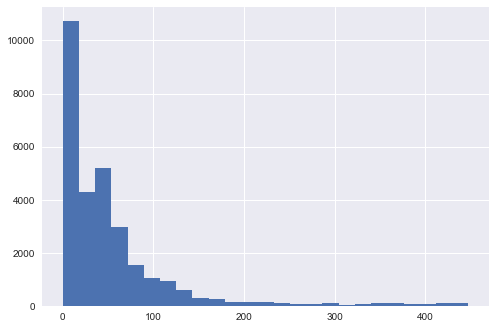

 | is numeric | 603 unique values  | consider one-hot? (ordinal?) 

cafe_count_5000_price_1500 -- Feature 
count    30471.00
mean        63.47
std        124.08
min          0.00
25%          6.00
50%         24.00
75%         51.00
max        641.00
Name: cafe_count_5000_price_1500, dtype: float64
0.0 423.229985851


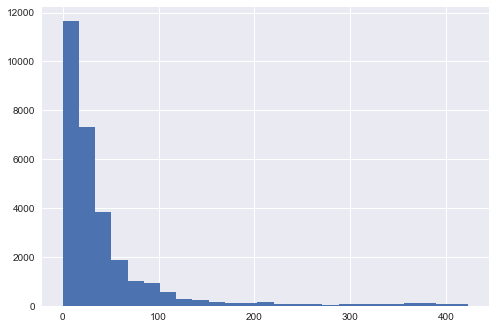

 | is numeric | 599 unique values  | consider one-hot? (ordinal?) 

cafe_count_5000_price_2500 -- Feature 
count    30471.00
mean        32.06
std         73.47
min          0.00
25%          2.00
50%          8.00
75%         21.00
max        377.00
Name: cafe_count_5000_price_2500, dtype: float64
0.0 241.396832505


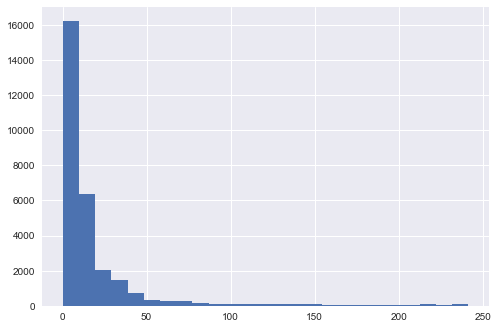

 | is numeric | 375 unique values  | consider one-hot? (ordinal?) 

cafe_count_5000_price_4000 -- Feature 
count    30471.00
mean        10.78
std         28.39
min          0.00
25%          1.00
50%          2.00
75%          5.00
max        147.00
Name: cafe_count_5000_price_4000, dtype: float64
0.0 90.1570376082


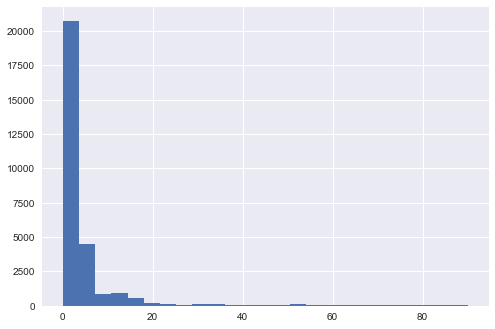

 | is numeric | 148 unique values  | consider one-hot? (ordinal?) 

cafe_count_5000_price_high -- Feature 
count    30471.00
mean         1.77
std          5.42
min          0.00
25%          0.00
50%          0.00
75%          1.00
max         30.00
Name: cafe_count_5000_price_high, dtype: float64
0.0 17.2564216301


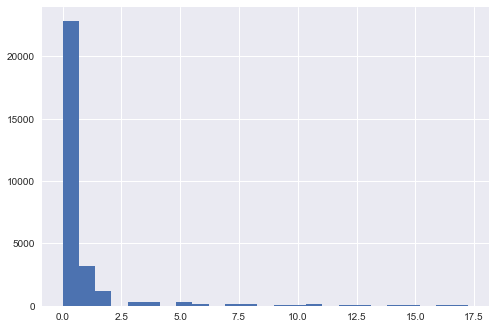

 | is numeric | 31 unique values  | consider one-hot? (ordinal?) 

big_church_count_5000 -- Feature 
count    30471.00
mean        15.05
std         29.12
min          0.00
25%          2.00
50%          7.00
75%         12.00
max        151.00
Name: big_church_count_5000, dtype: float64
0.0 99.3560048173


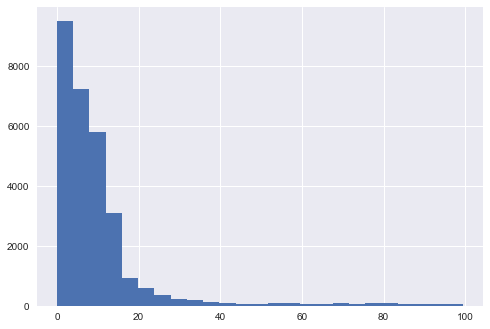

 | is numeric | 152 unique values  | consider one-hot? (ordinal?) 

church_count_5000 -- Feature 
count    30471.00
mean        30.25
std         47.35
min          0.00
25%          9.00
50%         16.00
75%         28.00
max        250.00
Name: church_count_5000, dtype: float64
0.0 170.043814605


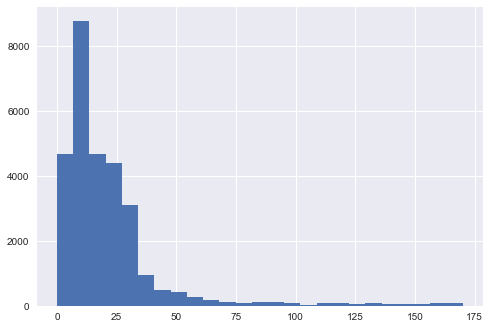

 | is numeric | 251 unique values  | consider one-hot? (ordinal?) 

mosque_count_5000 -- Feature 
count    30471.00
mean         0.44
std          0.61
min          0.00
25%          0.00
50%          0.00
75%          1.00
max          2.00
Name: mosque_count_5000, dtype: float64
0.0 2.0


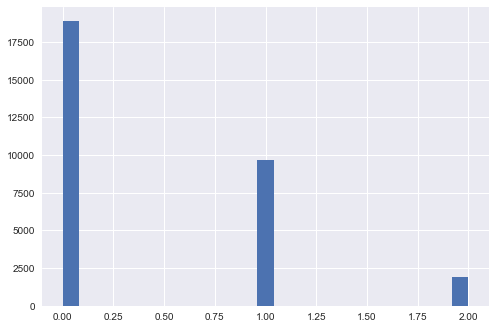

 | is numeric | 3 unique values  | consider one-hot? (ordinal?) 
Levels | Count | Mean | Median | std
                   price_doc  price_doc  price_doc     price_doc
mosque_count_5000                                               
0                      18887    6545463    6050000  3.646816e+06
1                       9687    7771140    6600000  5.572418e+06
2                       1897    9563943    7200000  8.041731e+06


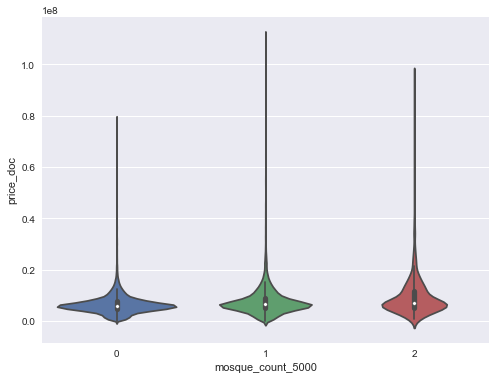


leisure_count_5000 -- Feature 
count    30471.00
mean         8.65
std         20.58
min          0.00
25%          0.00
50%          2.00
75%          7.00
max        106.00
Name: leisure_count_5000, dtype: float64
0.0 68.7422218238


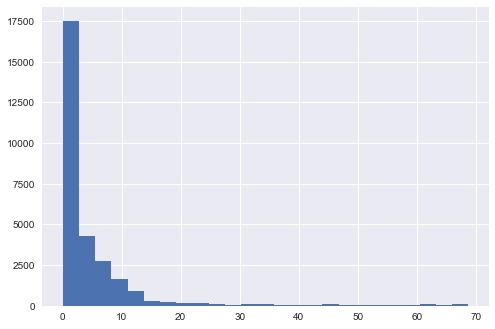

 | is numeric | 107 unique values  | consider one-hot? (ordinal?) 

sport_count_5000 -- Feature 
count    30471.00
mean        52.80
std         46.29
min          0.00
25%         11.00
50%         48.00
75%         76.00
max        218.00
Name: sport_count_5000, dtype: float64
0.0 214.877979273


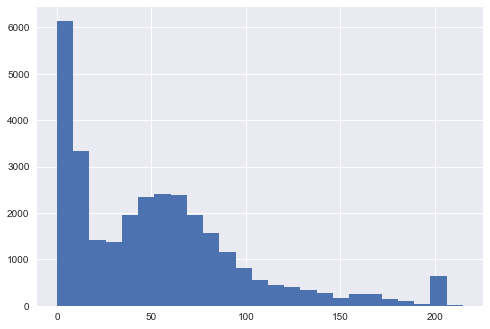

 | is numeric | 216 unique values  | consider one-hot? (ordinal?) 

market_count_5000 -- Feature 
count    30471.00
mean         5.99
std          4.89
min          0.00
25%          1.00
50%          5.00
75%         10.00
max         21.00
Name: market_count_5000, dtype: float64
0.0 21.0


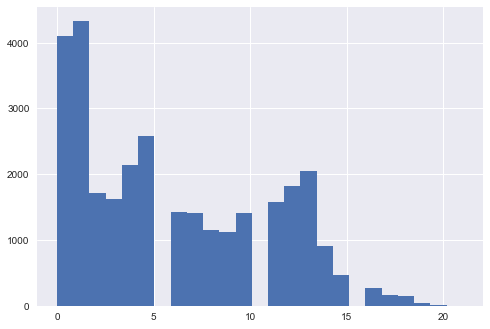

 | is numeric | 22 unique values  | consider one-hot? (ordinal?) 

price_doc -- Feature 
count        30471.0
mean       7123035.0
std        4780111.0
min         100000.0
25%        4740002.0
50%        6274411.0
75%        8300000.0
max      111111112.0
Name: price_doc, dtype: float64
100000.0 22640333.9889


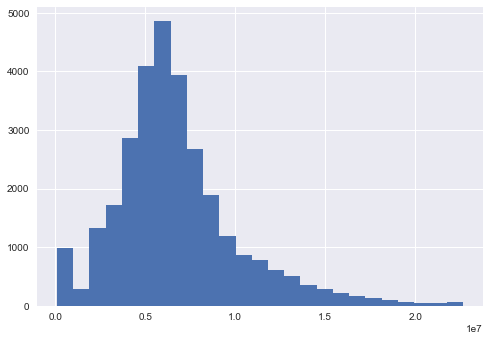

 | is numeric | 9296 unique values 


In [79]:
describe_features(df_train,'price_doc',False)

In [234]:
#simple outlier detection
#detects outliers based on how far from median value

from IPython.display import display 

def get_step(feature_col,Q1,Q3,iqr_range):
    step = (Q3-Q1)*iqr_range
    if step == 0:
        step = np.std(feature_col) * iqr_range
    return step

def find_outliers(df, iqr_range, outlier_percentage):
    # For each feature find the data points with extreme high or low values
    for feature in df.keys():
        if np.issubdtype(df[feature].dtype, np.number) == False:
            continue
        
        #print ("\n Data points considered outliers for the feature '{}':".format(feature))    
       
        df_feature = df[feature].dropna()
        
        df_describe = df_feature.describe()
        #Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = df_describe['25%']#np.percentile(df[feature], 25)
        #Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = df_describe['75%']#np.percentile(df[feature], 75)

        step = get_step(df_feature,Q1,Q3,iqr_range)
        
        
        #df_temp = df[feature][~((df[feature] >= Q1 - step) & (df[feature] <= Q3 + step))]
        df_temp = df_feature[~((df_feature >= Q1 - step) & (df_feature <= Q3 + step))]
        #print(len(df_temp),len(df_feature),Q1,Q3,step )
        #break
        
        z_break = 0
        
        #while len(df_temp) / len(df) > outlier_percentage:
        while True:
            #print(len(df_temp) / len(df) )
            if len(df_temp) / len(df_feature) > outlier_percentage:
                #print(len(df_temp),len(df_feature),Q1,Q3,step )
                print(feature, ": more than {} of data considered outliers, increasing iqr".format(outlier_percentage))
                iqr_range += 1.
                step = get_step(df_feature,Q1,Q3,iqr_range)
                df_temp = df_feature[~((df_feature >= Q1 - step) & (df_feature <= Q3 + step))]
                #print(len(df_temp))
            else:
                #print(len(df_temp),len(df_feature),Q1,Q3,step )
                if len(df_temp) > 0:
                    print ("\nData points considered outliers for the feature '{}':".format(feature))
                    print("Count, IQR, Median, Min, Max: ", len(df_temp), iqr_range, df_describe['50%'],
                      df_temp.min(),df_temp.max())
                    #temp2 = [~((df_feature >= Q1 - step) & (df_feature <= Q3 + step))]
                    #display(temp2.sort_values(ascending=False))
                    display(df_temp.sort_values(ascending=False))
                    break
                else:
                    break
                    
            z_break += 1
            if z_break > 5:
                print("Count, IQR, Median, Min, Max: ", len(df_temp), iqr_range, df_describe['50%'],
                      df_temp.min(),df_temp.max())
                break


In [235]:
find_outliers(df_train,3.5,0.05)


Data points considered outliers for the feature 'full_sq':
Count, IQR, Median, Min, Max:  170 3.5 49.0 151 5326


3527     5326
2780      729
22785     637
5944      634
18341     634
23715     603
7207      461
2425      412
27793     407
1610      394
3596      388
1478      353
128       325
16743     303
1307      291
18525     275
8827      226
17277     220
28326     220
28081     219
17710     219
23896     218
25183     216
15145     215
29656     211
6146      211
5728      210
18669     209
27496     209
3530      208
         ... 
27283     157
10178     156
2782      156
5297      156
20198     156
6110      156
6246      156
4260      156
6631      156
1632      155
22665     155
10691     155
7585      155
1943      155
1985      155
2267      155
5675      155
5348      155
998       155
297       154
18078     154
29078     154
25786     154
25149     153
16627     153
17700     153
22885     151
27460     151
22778     151
30320     151
Name: full_sq, dtype: int64


Data points considered outliers for the feature 'life_sq':
Count, IQR, Median, Min, Max:  119 3.5 30.0 124.0 7478.0


13546    7478.0
9646      802.0
22785     637.0
9256      458.0
26342     435.0
4385      426.0
27793     407.0
21080     349.0
128       325.0
9237      301.0
1084      281.0
13629     259.0
18525     232.0
18669     209.0
22073     197.0
29310     197.0
1029      197.0
7208      195.0
6336      191.0
1307      189.0
997       183.0
27289     179.0
1863      178.0
7443      178.0
5502      178.0
17277     176.0
23896     174.0
17138     172.0
14709     167.0
7439      166.0
          ...  
7153      136.0
26923     134.0
19513     134.0
28415     134.0
17396     134.0
16369     134.0
15145     134.0
21110     134.0
27454     134.0
11531     134.0
17404     134.0
3942      134.0
21512     133.0
10178     130.0
6319      128.0
9534      126.0
11769     126.0
10858     126.0
10601     126.0
12549     126.0
10053     125.0
8169      125.0
8693      125.0
12246     124.0
7309      124.0
6954      124.0
8902      124.0
18344     124.0
10295     124.0
19928     124.0
Name: life_sq, dtype: fl


Data points considered outliers for the feature 'floor':
Count, IQR, Median, Min, Max:  4 3.5 6.5 41.0 77.0


23584    77.0
30311    44.0
2499     44.0
21606    41.0
Name: floor, dtype: float64


Data points considered outliers for the feature 'max_floor':
Count, IQR, Median, Min, Max:  14 3.5 12.0 47.0 117.0


25940    117.0
21852     99.0
21734     99.0
20722     99.0
24020     57.0
30311     48.0
26665     48.0
21606     48.0
20487     48.0
20102     48.0
19417     48.0
17710     48.0
19095     47.0
15105     47.0
Name: max_floor, dtype: float64


Data points considered outliers for the feature 'material':
Count, IQR, Median, Min, Max:  803 3.5 1.0 6.0 6.0


30453    6.0
17862    6.0
18170    6.0
18160    6.0
18129    6.0
18054    6.0
18042    6.0
18019    6.0
18014    6.0
17941    6.0
17910    6.0
17875    6.0
17827    6.0
15964    6.0
17819    6.0
17766    6.0
17762    6.0
17750    6.0
17727    6.0
17723    6.0
17708    6.0
17703    6.0
17572    6.0
17566    6.0
18195    6.0
18249    6.0
18273    6.0
18280    6.0
18792    6.0
18748    6.0
        ... 
24106    6.0
24104    6.0
24055    6.0
24050    6.0
24537    6.0
24602    6.0
25204    6.0
24626    6.0
25187    6.0
25124    6.0
25118    6.0
25090    6.0
25077    6.0
25053    6.0
24981    6.0
24980    6.0
24939    6.0
24935    6.0
24933    6.0
24915    6.0
24882    6.0
24859    6.0
24852    6.0
24747    6.0
24724    6.0
24712    6.0
24653    6.0
24646    6.0
24643    6.0
8153     6.0
Name: material, dtype: float64

build_year : more than 0.05 of data considered outliers, increasing iqr
build_year : more than 0.05 of data considered outliers, increasing iqr
build_year : more than 0.05 of data considered outliers, increasing iqr
build_year : more than 0.05 of data considered outliers, increasing iqr
build_year : more than 0.05 of data considered outliers, increasing iqr
build_year : more than 0.05 of data considered outliers, increasing iqr
Count, IQR, Median, Min, Max:  905 9.5 1979.0 0.0 20052009.0

Data points considered outliers for the feature 'num_room':
Count, IQR, Median, Min, Max:  2 9.5 2.0 17.0 19.0


11621    19.0
26713    17.0
Name: num_room, dtype: float64


Data points considered outliers for the feature 'kitch_sq':
Count, IQR, Median, Min, Max:  13 9.5 6.0 86.0 2014.0


21415    2014.0
10368    2013.0
28734    1974.0
13117    1970.0
11520     620.0
8949      123.0
27996     112.0
27931     112.0
20053     112.0
28997      97.0
28434      96.0
26813      95.0
26850      86.0
Name: kitch_sq, dtype: float64


Data points considered outliers for the feature 'state':
Count, IQR, Median, Min, Max:  1 9.5 2.0 33.0 33.0


10089    33.0
Name: state, dtype: float64


Data points considered outliers for the feature 'area_m':
Count, IQR, Median, Min, Max:  187 9.5 10508030.1 119986402.6 206071809.2


14769    206071809.2
7717     206071809.2
10761    206071809.2
28258    206071809.2
14435    206071809.2
21033    206071809.2
21343    206071809.2
18959    176246410.0
22487    176246410.0
17396    176246410.0
17404    176246410.0
17761    176246410.0
18074    176246410.0
18356    176246410.0
21938    176246410.0
23656    176246410.0
21663    176246410.0
21565    176246410.0
29136    176246410.0
26923    176246410.0
27371    176246410.0
20863    176246410.0
20324    176246410.0
17059    176246410.0
25876    176246410.0
17010    176246410.0
15902    176246410.0
12742    176246410.0
23483    176246410.0
23397    176246410.0
            ...     
25442    148701635.4
25203    148701635.4
25102    148701635.4
24839    148701635.4
30329    148701635.4
24338    148701635.4
26609    148701635.4
26880    148701635.4
27039    148701635.4
27064    148701635.4
28430    148701635.4
28416    148701635.4
28401    148701635.4
28347    148701635.4
28329    148701635.4
28311    148701635.4
28305    1487


Data points considered outliers for the feature 'office_raion':
Count, IQR, Median, Min, Max:  1373 9.5 2.0 56 141


30467    141
10262    141
21790    141
10067    141
21743    141
21738    141
21709    141
10075    141
10081    141
10146    141
21620    141
21832    141
10326    141
10393    141
10480    141
21600    141
10509    141
10557    141
10568    141
21524    141
10042    141
21834    141
10581    141
9640     141
22267    141
9444     141
22259    141
22176    141
22170    141
9477     141
        ... 
2631      56
20951     56
2562      56
20905     56
11147     56
11250     56
3009      56
21706     56
21760     56
10020     56
3829      56
8967      56
9037      56
22542     56
22434     56
28256     56
28289     56
3571      56
22261     56
3485      56
9485      56
3415      56
9546      56
3352      56
9659      56
3177      56
9871      56
28715     56
21908     56
16836     56
Name: office_raion, dtype: int64


Data points considered outliers for the feature 'full_all':
Count, IQR, Median, Min, Max:  1315 9.5 85219.0 1100773 1716730


10350    1716730
11770    1716730
12496    1716730
12388    1716730
12287    1716730
12251    1716730
12234    1716730
24276    1716730
11948    1716730
11938    1716730
24530    1716730
12692    1716730
11748    1716730
24633    1716730
24646    1716730
11563    1716730
11425    1716730
11412    1716730
11369    1716730
11317    1716730
12673    1716730
12730    1716730
11205    1716730
13487    1716730
13947    1716730
13747    1716730
22969    1716730
13673    1716730
13649    1716730
13598    1716730
          ...   
25484    1100773
11873    1100773
12868    1100773
4522     1100773
17087    1100773
11783    1100773
3760     1100773
13058    1100773
3785     1100773
11541    1100773
11442    1100773
16854    1100773
9391     1100773
16752    1100773
16678    1100773
21585    1100773
16597    1100773
9566     1100773
16523    1100773
2429     1100773
1299     1100773
16341    1100773
7028     1100773
16307    1100773
2371     1100773
16210    1100773
28560    1100773
5179     11007


Data points considered outliers for the feature 'male_f':
Count, IQR, Median, Min, Max:  1315 9.5 39261.0 502659 774585


10350    774585
11770    774585
12496    774585
12388    774585
12287    774585
12251    774585
12234    774585
24276    774585
11948    774585
11938    774585
24530    774585
12692    774585
11748    774585
24633    774585
24646    774585
11563    774585
11425    774585
11412    774585
11369    774585
11317    774585
12673    774585
12730    774585
11205    774585
13487    774585
13947    774585
13747    774585
22969    774585
13673    774585
13649    774585
13598    774585
          ...  
16854    502659
25490    502659
3057     502659
12820    502659
16678    502659
16597    502659
9123     502659
16523    502659
11783    502659
16341    502659
12868    502659
16307    502659
16210    502659
11541    502659
9391     502659
21585    502659
25484    502659
21755    502659
1299     502659
9566     502659
13058    502659
21863    502659
11442    502659
19615    502659
28560    502659
2158     502659
3785     502659
15462    502659
22025    502659
16752    502659
Name: male_f, dtype: int


Data points considered outliers for the feature 'female_f':
Count, IQR, Median, Min, Max:  1315 9.5 45729.0 598114 942145


10350    942145
11770    942145
12496    942145
12388    942145
12287    942145
12251    942145
12234    942145
24276    942145
11948    942145
11938    942145
24530    942145
12692    942145
11748    942145
24633    942145
24646    942145
11563    942145
11425    942145
11412    942145
11369    942145
11317    942145
12673    942145
12730    942145
11205    942145
13487    942145
13947    942145
13747    942145
22969    942145
13673    942145
13649    942145
13598    942145
          ...  
25484    598114
11873    598114
12868    598114
4522     598114
17087    598114
11783    598114
3760     598114
13058    598114
3785     598114
11541    598114
11442    598114
16854    598114
9391     598114
16752    598114
16678    598114
21585    598114
16597    598114
9566     598114
16523    598114
2429     598114
1299     598114
16341    598114
7028     598114
16307    598114
2371     598114
16210    598114
28560    598114
5179     598114
13792    598114
21863    598114
Name: female_f, dtype: i


Data points considered outliers for the feature '16_29_all':
Count, IQR, Median, Min, Max:  1315 9.5 17864.0 234407 367659


10350    367659
11770    367659
12496    367659
12388    367659
12287    367659
12251    367659
12234    367659
24276    367659
11948    367659
11938    367659
24530    367659
12692    367659
11748    367659
24633    367659
24646    367659
11563    367659
11425    367659
11412    367659
11369    367659
11317    367659
12673    367659
12730    367659
11205    367659
13487    367659
13947    367659
13747    367659
22969    367659
13673    367659
13649    367659
13598    367659
          ...  
16854    234407
25490    234407
3057     234407
12820    234407
16678    234407
16597    234407
9123     234407
16523    234407
11783    234407
16341    234407
12868    234407
16307    234407
16210    234407
11541    234407
9391     234407
21585    234407
25484    234407
21755    234407
1299     234407
9566     234407
13058    234407
21863    234407
11442    234407
19615    234407
28560    234407
2158     234407
3785     234407
15462    234407
22025    234407
16752    234407
Name: 16_29_all, dtype: 


Data points considered outliers for the feature '16_29_male':
Count, IQR, Median, Min, Max:  1192 9.5 8896.0 137389 172958


6983     172958
21914    172958
18616    172958
1539     172958
25529    172958
1511     172958
22008    172958
18670    172958
25689    172958
25470    172958
25693    172958
2668     172958
25790    172958
25800    172958
7405     172958
21909    172958
1559     172958
15276    172958
25951    172958
22109    172958
18607    172958
15668    172958
25178    172958
1654     172958
6464     172958
6785     172958
15522    172958
19987    172958
22063    172958
25358    172958
          ...  
16938    137389
16933    137389
18946    137389
5624     137389
16876    137389
16781    137389
5835     137389
16697    137389
16567    137389
16476    137389
17342    137389
17477    137389
17809    137389
17857    137389
18926    137389
18845    137389
18832    137389
18791    137389
18719    137389
18615    137389
4553     137389
18548    137389
18531    137389
18111    137389
18037    137389
17982    137389
17979    137389
4925     137389
17939    137389
3315     137389
Name: 16_29_male, dtype:


Data points considered outliers for the feature '16_29_female':
Count, IQR, Median, Min, Max:  1192 9.5 9353.0 138678 194701


20003    194701
20303    194701
19822    194701
2923     194701
2910     194701
19938    194701
19987    194701
2823     194701
20159    194701
20211    194701
20225    194701
20299    194701
20426    194701
3026     194701
20674    194701
20699    194701
20808    194701
20834    194701
20901    194701
2668     194701
21015    194701
21062    194701
2567     194701
21140    194701
2982     194701
19469    194701
1462     194701
18607    194701
17972    194701
17988    194701
          ...  
8743     138678
12586    138678
8908     138678
12531    138678
12233    138678
9266     138678
9270     138678
10087    138678
15034    138678
5900     138678
1177     138678
5662     138678
26117    138678
24801    138678
24233    138678
23775    138678
21537    138678
21190    138678
20004    138678
19295    138678
18701    138678
18576    138678
18043    138678
3960     138678
4012     138678
4261     138678
17762    138678
4726     138678
16462    138678
20       138678
Name: 16_29_female, dtyp

build_count_wood : more than 0.05 of data considered outliers, increasing iqr
build_count_wood : more than 0.05 of data considered outliers, increasing iqr
build_count_wood : more than 0.05 of data considered outliers, increasing iqr
build_count_wood : more than 0.05 of data considered outliers, increasing iqr
build_count_wood : more than 0.05 of data considered outliers, increasing iqr
build_count_wood : more than 0.05 of data considered outliers, increasing iqr
Count, IQR, Median, Min, Max:  2376 15.5 0.0 116.0 793.0
build_count_frame : more than 0.05 of data considered outliers, increasing iqr
build_count_frame : more than 0.05 of data considered outliers, increasing iqr
build_count_frame : more than 0.05 of data considered outliers, increasing iqr
build_count_frame : more than 0.05 of data considered outliers, increasing iqr
build_count_frame : more than 0.05 of data considered outliers, increasing iqr
build_count_frame : more than 0.05 of data considered outliers, increasing iqr
C

30453    84.0
13263    84.0
12494    84.0
12640    84.0
12676    84.0
12734    84.0
12775    84.0
12807    84.0
12812    84.0
12830    84.0
12848    84.0
12849    84.0
12998    84.0
13022    84.0
13065    84.0
13221    84.0
13290    84.0
12402    84.0
13437    84.0
13511    84.0
13671    84.0
13698    84.0
13917    84.0
13931    84.0
13959    84.0
13982    84.0
14036    84.0
14115    84.0
14170    84.0
14197    84.0
         ... 
15024    64.0
24546    64.0
20490    64.0
10066    64.0
9970     64.0
9964     64.0
9834     64.0
15184    64.0
24791    64.0
9775     64.0
15186    64.0
9540     64.0
9376     64.0
9364     64.0
9334     64.0
15190    64.0
9172     64.0
8981     64.0
8980     64.0
25059    64.0
8899     64.0
15232    64.0
15266    64.0
8629     64.0
8539     64.0
25289    64.0
10       64.0
15708    58.0
23753    58.0
28428    58.0
Name: build_count_slag, dtype: float64

build_count_before_1920 : more than 0.05 of data considered outliers, increasing iqr
build_count_before_1920 : more than 0.05 of data considered outliers, increasing iqr
build_count_before_1920 : more than 0.05 of data considered outliers, increasing iqr
build_count_before_1920 : more than 0.05 of data considered outliers, increasing iqr
build_count_before_1920 : more than 0.05 of data considered outliers, increasing iqr
build_count_before_1920 : more than 0.05 of data considered outliers, increasing iqr
Count, IQR, Median, Min, Max:  1452 27.5 0.0 139.0 371.0

Data points considered outliers for the feature 'kindergarten_km':
Count, IQR, Median, Min, Max:  180 27.5 0.353761554 22.52919643 29.08577383


25826    29.085774
14426    27.655479
24820    25.506443
17761    25.506443
17059    25.506443
21565    25.506443
17396    25.506443
17404    25.506443
20863    25.506443
18074    25.506443
26923    25.506443
21663    25.506443
18356    25.506443
22487    25.506443
18959    25.506443
27371    25.506443
21938    25.506443
17010    25.506443
25876    25.506443
16790    25.506443
23397    25.506443
20324    25.506443
25769    25.506443
15902    25.506443
23483    25.506443
12742    25.506443
15868    25.506443
14895    25.506443
28074    25.506443
23656    25.506443
           ...    
25827    23.526686
25779    23.526686
25711    23.526686
25442    23.526686
25203    23.526686
25102    23.526686
27377    23.526686
27441    23.526686
27599    23.526686
27654    23.526686
28456    23.526686
28430    23.526686
28416    23.526686
28401    23.526686
28347    23.526686
28329    23.526686
28311    23.526686
28305    23.526686
28284    23.526686
28275    23.526686
28109    23.526686
28009    23.


Data points considered outliers for the feature 'school_km':
Count, IQR, Median, Min, Max:  194 27.5 0.474862136 18.26545752 47.39470605


23656    47.394706
18356    47.394706
17010    47.394706
17059    47.394706
17396    47.394706
25876    47.394706
17761    47.394706
22487    47.394706
18074    47.394706
18959    47.394706
16790    47.394706
21938    47.394706
21663    47.394706
26923    47.394706
21565    47.394706
27371    47.394706
20324    47.394706
28074    47.394706
25769    47.394706
17404    47.394706
23483    47.394706
15868    47.394706
12742    47.394706
14685    47.394706
14729    47.394706
24820    47.394706
14895    47.394706
20863    47.394706
23397    47.394706
15902    47.394706
           ...    
27039    26.499723
27064    26.499723
27377    26.499723
28416    26.499723
28401    26.499723
28347    26.499723
28329    26.499723
28311    26.499723
28305    26.499723
28284    26.499723
28275    26.499723
28109    26.499723
28009    26.499723
28000    26.499723
27944    26.499723
27721    26.499723
27654    26.499723
27599    26.499723
27441    26.499723
30168    26.499723
18591    26.031705
18996    25.


Data points considered outliers for the feature 'public_transport_station_km':
Count, IQR, Median, Min, Max:  185 27.5 0.160275052 5.539612615 17.41300179


24820    17.413002
17010    17.413002
17396    17.413002
17404    17.413002
17761    17.413002
18074    17.413002
18356    17.413002
18959    17.413002
20324    17.413002
28074    17.413002
20863    17.413002
21565    17.413002
27371    17.413002
21663    17.413002
26923    17.413002
21938    17.413002
22487    17.413002
25876    17.413002
25769    17.413002
23397    17.413002
23483    17.413002
17059    17.413002
23656    17.413002
15902    17.413002
12742    17.413002
14685    17.413002
14729    17.413002
15868    17.413002
16790    17.413002
14895    17.413002
           ...    
25203    14.490989
25102    14.490989
24839    14.490989
30329    14.490989
28430    14.490989
26880    14.490989
28109    14.490989
28009    14.490989
28347    14.490989
28329    14.490989
28311    14.490989
28305    14.490989
28284    14.490989
28275    14.490989
27064    14.490989
28000    14.490989
28416    14.490989
27944    14.490989
27721    14.490989
27654    14.490989
27599    14.490989
27441    14.


Data points considered outliers for the feature 'public_transport_station_min_walk':
Count, IQR, Median, Min, Max:  185 27.5 1.923300624 66.47535138 208.9560215


24820    208.956022
17010    208.956022
17396    208.956022
17404    208.956022
17761    208.956022
18074    208.956022
18356    208.956022
18959    208.956022
20324    208.956022
28074    208.956022
20863    208.956022
21565    208.956022
27371    208.956022
21663    208.956022
26923    208.956022
21938    208.956022
22487    208.956022
25876    208.956022
25769    208.956022
23397    208.956022
23483    208.956022
17059    208.956022
23656    208.956022
15902    208.956022
12742    208.956022
14685    208.956022
14729    208.956022
15868    208.956022
16790    208.956022
14895    208.956022
            ...    
25203    173.891866
25102    173.891866
24839    173.891866
30329    173.891866
28430    173.891866
26880    173.891866
28109    173.891866
28009    173.891866
28347    173.891866
28329    173.891866
28311    173.891866
28305    173.891866
28284    173.891866
28275    173.891866
27064    173.891866
28000    173.891866
28416    173.891866
27944    173.891866
27721    173.891866



Data points considered outliers for the feature 'preschool_km':
Count, IQR, Median, Min, Max:  190 27.5 0.493048083 25.09553694 47.39470605


23656    47.394706
25876    47.394706
18959    47.394706
21663    47.394706
16790    47.394706
26923    47.394706
21565    47.394706
17010    47.394706
17059    47.394706
27371    47.394706
17396    47.394706
17404    47.394706
17761    47.394706
20863    47.394706
18074    47.394706
28074    47.394706
18356    47.394706
22487    47.394706
21938    47.394706
15902    47.394706
14729    47.394706
12742    47.394706
23483    47.394706
23397    47.394706
14685    47.394706
24820    47.394706
25769    47.394706
14895    47.394706
15868    47.394706
20324    47.394706
           ...    
25203    26.499723
25102    26.499723
24839    26.499723
24390    26.499723
28456    26.499723
27064    26.499723
27441    26.499723
28275    26.499723
28430    26.499723
28416    26.499723
28401    26.499723
28347    26.499723
28329    26.499723
28311    26.499723
28305    26.499723
27599    26.499723
28284    26.499723
28109    26.499723
28009    26.499723
28000    26.499723
27944    26.499723
27721    26.

trc_sqm_500 : more than 0.05 of data considered outliers, increasing iqr
trc_sqm_500 : more than 0.05 of data considered outliers, increasing iqr
trc_sqm_500 : more than 0.05 of data considered outliers, increasing iqr
trc_sqm_500 : more than 0.05 of data considered outliers, increasing iqr
trc_sqm_500 : more than 0.05 of data considered outliers, increasing iqr
trc_sqm_500 : more than 0.05 of data considered outliers, increasing iqr
Count, IQR, Median, Min, Max:  6641 33.5 0.0 4200 1500000

Data points considered outliers for the feature 'cafe_count_500':
Count, IQR, Median, Min, Max:  9 33.5 1.0 105 120


23602    120
18990    120
948      118
26487    113
1402     113
12282    108
9502     106
8073     106
9804     105
Name: cafe_count_500, dtype: int64


Data points considered outliers for the feature 'cafe_count_500_price_1000':
Count, IQR, Median, Min, Max:  2 33.5 0.0 37 39


16308    39
22778    37
Name: cafe_count_500_price_1000, dtype: int64


Data points considered outliers for the feature 'office_count_1000':
Count, IQR, Median, Min, Max:  46 33.5 0.0 70 91


9876     91
8191     91
9671     91
7304     91
9161     90
6134     90
9502     86
8073     86
15306    84
17212    82
810      82
26487    81
22694    81
6191     81
1402     81
27146    80
1113     80
18990    80
22664    80
2934     80
12079    79
17787    76
948      76
12282    76
26820    76
2904     76
5951     76
723      74
419      74
8895     74
27753    74
23602    74
22777    73
24396    72
23174    72
13663    72
16911    71
7977     71
2289     71
7955     71
29508    71
22037    70
2438     70
24580    70
26882    70
26904    70
Name: office_count_1000, dtype: int64


Data points considered outliers for the feature 'office_sqm_1000':
Count, IQR, Median, Min, Max:  5 33.5 0.0 1977564 2244723


26507    2244723
20460    2084526
4425     2005497
3294     1977564
2958     1977564
Name: office_sqm_1000, dtype: int64


Data points considered outliers for the feature 'cafe_count_1000':
Count, IQR, Median, Min, Max:  12 33.5 4.0 372 449


9502     449
8073     449
18990    445
26487    444
12282    444
1402     444
23602    400
948      400
9876     372
9671     372
8191     372
7304     372
Name: cafe_count_1000, dtype: int64


Data points considered outliers for the feature 'cafe_count_1000_price_500':
Count, IQR, Median, Min, Max:  4 33.5 1.0 105 112


18990    112
9502     106
8073     106
12282    105
Name: cafe_count_1000_price_500, dtype: int64


Data points considered outliers for the feature 'cafe_count_1000_price_1500':
Count, IQR, Median, Min, Max:  2 33.5 1.0 104 104


26487    104
1402     104
Name: cafe_count_1000_price_1500, dtype: int64


Data points considered outliers for the feature 'cafe_count_1000_price_2500':
Count, IQR, Median, Min, Max:  647 33.5 0.0 35 79


1402     79
26487    79
18990    73
12282    72
8073     69
9502     69
23602    68
948      67
9876     61
7304     61
8191     61
9671     61
7977     54
28326    52
11037    50
12365    50
12784    50
12737    50
12708    50
12703    50
12604    50
12386    50
10704    50
12928    50
12316    50
10746    50
12249    50
10787    50
12202    50
12862    50
         ..
19708    49
22694    49
6191     48
11278    48
1153     48
12462    48
29656    47
6134     47
9161     47
18933    46
9737     46
15366    46
28969    46
22664    44
2934     44
17212    42
15306    40
5951     39
17296    39
8933     39
12560    39
26820    39
8895     38
810      37
2904     36
24620    36
24396    36
5728     36
4732     36
2696     35
Name: cafe_count_1000_price_2500, dtype: int64


Data points considered outliers for the feature 'church_count_1000':
Count, IQR, Median, Min, Max:  610 33.5 1.0 35 38


10587    38
15366    38
10901    37
18933    37
12365    35
12784    35
12737    35
12708    35
12703    35
12604    35
12386    35
30465    35
12316    35
12928    35
12249    35
12202    35
12188    35
12134    35
12112    35
12102    35
12862    35
13003    35
12931    35
11932    35
14044    35
14029    35
13951    35
13938    35
13896    35
13798    35
         ..
22899    35
22877    35
22806    35
22785    35
22758    35
22732    35
22729    35
22725    35
22697    35
22672    35
23227    35
23290    35
23857    35
23300    35
23855    35
23825    35
23676    35
23672    35
23670    35
23632    35
23631    35
23625    35
23562    35
23553    35
23546    35
23515    35
23488    35
23484    35
23351    35
313      35
Name: church_count_1000, dtype: int64


Data points considered outliers for the feature 'office_count_1500':
Count, IQR, Median, Min, Max:  34 33.5 1.0 140 173


23602    173
948      172
26487    163
1402     163
6134     162
18990    162
9161     162
22694    161
7977     158
9502     157
15306    157
8073     157
7304     153
8191     153
9876     153
9671     153
26820    150
5951     150
6191     149
723      148
17212    147
2696     146
12282    146
5728     146
1153     145
28326    144
6505     144
23174    143
2934     142
9444     142
22664    142
8895     142
810      141
17787    140
Name: office_count_1500, dtype: int64


Data points considered outliers for the feature 'cafe_count_1500':
Count, IQR, Median, Min, Max:  8 33.5 10.0 730 784


18990    784
26487    764
1402     764
12282    760
948      750
23602    737
9502     730
8073     730
Name: cafe_count_1500, dtype: int64


Data points considered outliers for the feature 'cafe_count_1500_price_2500':
Count, IQR, Median, Min, Max:  658 33.5 1.0 70 127


26487    127
1402     127
948      125
23602    124
12282    124
8933     121
18990    117
22694    105
7977     105
9502     105
8073     105
28326    103
6191     103
7304     102
8191     102
9671     102
9876     102
9161      99
6134      99
28969     96
15306     94
1153      94
5951      91
26820     91
11278     88
22664     88
2934      88
12102     87
12249     87
13721     87
        ... 
23488     87
23484     87
23553     87
23300     87
23351     87
19708     86
29656     86
810       85
12462     84
2696      84
18933     82
8895      80
23174     80
12560     79
723       79
9737      79
1113      78
9444      78
2904      78
15366     78
27146     78
419       76
24396     76
27753     76
22777     75
17787     74
6505      72
23052     71
12079     70
19653     70
Name: cafe_count_1500_price_2500, dtype: int64


Data points considered outliers for the feature 'big_church_count_1500':
Count, IQR, Median, Min, Max:  617 33.5 1.0 35 44


30465    44
13124    44
13003    44
12931    44
12928    44
12862    44
12784    44
12737    44
12708    44
12703    44
12604    44
12386    44
12365    44
12316    44
12249    44
12202    44
12188    44
13069    44
13406    44
12112    44
13408    44
14328    44
14292    44
14133    44
14119    44
14044    44
14029    44
13951    44
13938    44
13896    44
         ..
23351    44
23484    44
23488    44
23515    44
23546    44
23553    44
23562    44
23625    44
23631    44
23632    44
23670    44
23672    44
23676    44
23825    44
25697    44
23855    44
25380    44
10650    42
24118    42
8755     42
25823    42
10901    41
726      41
11278    40
18933    40
10587    37
17296    36
18265    35
16681    35
12353    35
Name: big_church_count_1500, dtype: int64


Data points considered outliers for the feature 'church_count_1500':
Count, IQR, Median, Min, Max:  3 33.5 1.0 74 75


10901    75
8755     75
726      74
Name: church_count_1500, dtype: int64


Data points considered outliers for the feature 'leisure_count_1500':
Count, IQR, Median, Min, Max:  13 33.5 0.0 35 44


8933     44
19708    40
28326    39
1153     38
28969    37
26487    37
1402     37
29656    36
12282    36
23602    35
22778    35
18990    35
948      35
Name: leisure_count_1500, dtype: int64


Data points considered outliers for the feature 'office_count_2000':
Count, IQR, Median, Min, Max:  7 33.5 2.0 242 250


9161     250
6134     250
22694    249
12282    244
9502     244
8073     244
23602    242
Name: office_count_2000, dtype: int64


Data points considered outliers for the feature 'cafe_count_2000_price_2500':
Count, IQR, Median, Min, Max:  705 33.5 1.0 104 170


8933     170
12282    167
22694    163
23602    162
26487    162
948      162
1402     162
6134     160
9161     160
9671     159
18990    159
7304     159
9876     159
8191     159
9502     157
8073     157
28326    157
19708    153
28969    153
15306    152
12604    150
12703    150
12737    150
14292    150
12784    150
12386    150
12365    150
12862    150
12928    150
12931    150
        ... 
26882    111
26904    111
24580    111
15808    111
427      111
13663    111
22037    111
12079    111
2438     111
7955     110
26459    110
16911    110
2289     110
2470     110
29508    110
9196     109
726      109
24620    108
11972    108
17851    108
23052    107
30406    106
8755     106
4732     106
27621    105
10901    105
28821    105
23163    105
19063    104
6469     104
Name: cafe_count_2000_price_2500, dtype: int64


Data points considered outliers for the feature 'cafe_count_2000_price_4000':
Count, IQR, Median, Min, Max:  777 33.5 0.0 35 81


19708    81
8933     80
12282    74
28969    72
28326    72
29656    71
26487    71
1402     71
16308    69
1366     69
948      69
18990    68
22778    67
23602    67
8073     65
9502     65
8191     64
9876     64
7304     64
9671     64
1153     64
15757    63
15544    63
15515    63
15696    63
15709    63
15466    63
15353    63
15348    63
15291    63
         ..
27146    38
4732     38
6383     38
28542    38
18506    38
18999    38
26650    38
18079    37
1850     37
20219    37
20727    37
2464     37
11282    37
16358    36
6469     36
16159    36
29517    36
22989    36
17851    36
29154    36
19063    36
11738    36
8628     36
7485     35
24426    35
26459    35
25823    35
24118    35
13242    35
10650    35
Name: cafe_count_2000_price_4000, dtype: int64


Data points considered outliers for the feature 'big_church_count_2000':
Count, IQR, Median, Min, Max:  1 33.5 1.0 70 70


15366    70
Name: big_church_count_2000, dtype: int64


Data points considered outliers for the feature 'church_count_2000':
Count, IQR, Median, Min, Max:  1 33.5 3.0 108 108


15366    108
Name: church_count_2000, dtype: int64


Data points considered outliers for the feature 'leisure_count_2000':
Count, IQR, Median, Min, Max:  670 33.5 0.0 35 55


12282    55
18990    52
23602    51
2426     51
28969    51
16308    51
19708    50
26487    50
8933     50
1366     50
1402     50
22778    50
22694    50
28326    49
948      49
29656    48
18354    47
12604    47
12862    47
12784    47
12737    47
12708    47
12703    47
18600    47
12560    47
12931    47
12386    47
12365    47
12316    47
18754    47
         ..
5728     42
9737     42
26820    42
2904     41
22777    41
9804     39
27621    39
17212    39
9196     39
17787    38
6128     37
16119    37
1113     37
9444     37
8035     37
27146    37
6024     36
810      36
22664    36
2934     36
7774     36
15808    36
16694    36
16611    36
1592     35
6505     35
3402     35
9160     35
17207    35
6833     35
Name: leisure_count_2000, dtype: int64


Data points considered outliers for the feature 'cafe_count_3000_price_2500':
Count, IQR, Median, Min, Max:  771 33.5 3.0 174 266


8933     266
15366    263
28326    258
12282    257
30465    255
13679    255
13951    255
13938    255
13896    255
13798    255
13727    255
13721    255
13702    255
13561    255
14044    255
13408    255
13406    255
13124    255
13069    255
13003    255
12931    255
14029    255
14119    255
12862    255
14720    255
15039    255
14995    255
14977    255
14871    255
14862    255
        ... 
28447    187
26699    187
24426    187
14217    186
13359    186
1409     186
4051     185
18265    185
26075    185
2280     185
2091     184
12486    184
29005    183
28310    181
7095     181
10058    181
28622    181
28319    181
13286    179
29062    179
10228    179
7145     178
28102    178
1800     177
7523     176
9966     176
6079     175
28127    175
535      174
3184     174
Name: cafe_count_3000_price_2500, dtype: int64


Data points considered outliers for the feature 'cafe_count_3000_price_4000':
Count, IQR, Median, Min, Max:  777 33.5 1.0 70 113


8933     113
1153     112
1366     112
28969    112
12462    111
28326    111
29656    111
16308    110
948      110
22778    109
26487    109
23602    109
19708    109
1402     109
9737     108
14477    108
28821    108
7977     107
12560    107
12282    107
13702    105
13679    105
13561    105
13408    105
13406    105
14691    105
13124    105
13721    105
13069    105
13003    105
        ... 
9697      72
18265     72
28102     72
1142      72
6554      71
22037     71
28447     71
24580     71
419       71
26904     71
26882     71
21385     71
27753     71
2438      71
29517     71
29508     71
21314     71
14217     71
7955      71
16911     71
2289      71
3976      71
29094     71
8909      71
23550     71
2280      70
7523      70
28530     70
22864     70
29005     70
Name: cafe_count_3000_price_4000, dtype: int64


Data points considered outliers for the feature 'leisure_count_3000':
Count, IQR, Median, Min, Max:  622 33.5 0.0 70 85


30465    85
12708    85
13069    85
13003    85
12931    85
12928    85
12862    85
12784    85
12737    85
12703    85
19199    85
12604    85
12386    85
12365    85
12316    85
12249    85
12202    85
12188    85
13124    85
13406    85
13408    85
13561    85
14431    85
14328    85
14292    85
14133    85
14119    85
14044    85
14029    85
13951    85
         ..
23825    85
23672    85
23859    85
23857    85
23855    85
23676    85
313      85
23625    85
23632    85
23670    85
23631    85
15366    84
8933     78
8755     77
1402     76
12282    76
26487    76
18933    75
11278    75
726      75
1153     74
10901    74
28326    73
10587    72
28969    72
19708    71
1366     71
29656    71
9502     70
8073     70
Name: leisure_count_3000, dtype: int64


Data points considered outliers for the feature 'cafe_count_5000_price_4000':
Count, IQR, Median, Min, Max:  657 33.5 2.0 140 147


8035     147
6128     146
16119    146
2426     146
27621    145
9804     145
9196     145
1409     145
28326    145
16694    144
28969    144
15808    144
14477    144
22778    144
29656    144
6024     144
3402     144
14016    144
1366     144
7977     143
22694    143
7774     143
24620    143
1402     143
23602    143
26487    143
12282    143
1592     143
19708    143
1153     143
        ... 
22546    141
22513    141
22510    141
22455    141
22338    141
22315    141
22308    141
22877    141
22899    141
313      141
23300    141
23515    141
23488    141
23562    141
23484    141
23351    141
23027    141
23290    141
23553    141
23272    141
23227    141
23211    141
23142    141
23035    141
23625    141
23546    141
26820    140
26650    140
5951     140
1850     140
Name: cafe_count_5000_price_4000, dtype: int64